# Beam Training using Fully Connected Neural Networks
The first section loads the data, while the next two sections run FC NNs for beam training via classification and regression.

## THIS NOTEBOOK CONTAINS SAVED RESULTS FOR NR=24, 48, 60, and 72 AND D=0.57 (nn_sim7 - SIXTH POST-EXPERIMENT SIMULATION WITH FIXED SIM SCRIPT)
### NOT COMPLETE; RERUN IF RESULTS NEEDED

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import comb

print(tf.__version__)

2.1.0


# Load data
Load data for a given SNR.  Repeat this cell for every SNR run.

Data directory: ../data/nn_sim7/
Nr: 24, SNR: 20
	DFT data:  (10000, 34)
	PN data:   (10000, 24)
	Labels:    (10000, 1)
Nr: 24, SNR: 30
	DFT data:  (10000, 34)
	PN data:   (10000, 24)
	Labels:    (10000, 1)
Num DFT beams to use:  34
Num samples to use:    20000
Num PN beam combos:    1
	NOT USING RANDOM BEAMS -> FIRST 4 PN MEASUREMENTS USED!


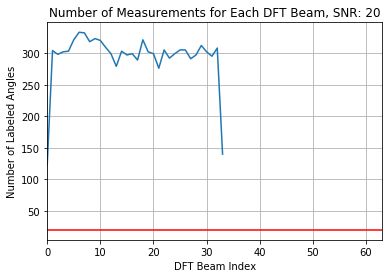

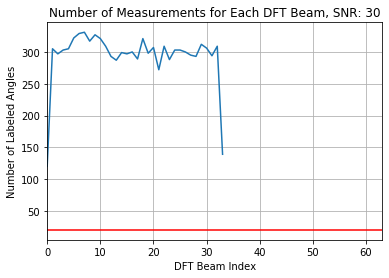

In [17]:
### Load Experimental Data ###
## Dataset Constants
Nr = 24                     # 24, 48, 60, or 72
DATA_SNR = [20, 30]
NN_NUM = 6                  # Number in the name of this notebook
SIM_NUM = NN_NUM + 1        # Number used for simulation results (data input)

NUM_DFT = 34                # Number of DFT beams measured - (34 for Nr=24), (68 for Nr=48), (85 for Nr=60), or (101 for Nr=72) 
NUM_ANGLES_PER_DFT = 20     # Number of measurements to use for a DFT (per each date; minimum required to be included)
NUM_TOTAL_MEAS = Nr         # Number of total PN beam/measurements/features collected (in a file)
NUM_MEAS = 7               # Number of PN beams/measurements/features to use (5, 10, 15 typically) #TODO: NEED TO CHOOSE THE ANGLES SOMEHOW
NUM_PN_COMBO = 1           # Number of random combinations of measurements to run with the algorithm (to ensure the results aren't dependent on beam)(limit NUM_TOTAL_MEAS choose NUM_MEAS)
                            # Set the NUM_PN_COMBO to 1 for the first NUM_MEAS PN beams (i.e. NOT random)
    
DATA_LINEAR_SCALE = True   # Rescale the data from log to linear (pRx is in dB)
DATA_ZERO_MEAN = False      # Offset the data by the mean features of the training data (same offset used for test data)
DATA_NORMALIZATION = True  # Scale the data (training and testing) to the maximum norm of the training data

DATA_DIR = "../data/nn_sim{}/".format(SIM_NUM)
print("Data directory: {}".format(DATA_DIR))
DATA_DFT_FILESTEM = DATA_DIR + "DFT_output_nr{}_{}dB.csv" #"../data/results_awv0_{}_{}_dft.csv"
DATA_PN_FILESTEM = DATA_DIR + "measurement_RSS_nr{}_{}dB.csv" #"../data/results_awv0_{}_{}_pn.csv"
DATA_LABELS_FILESTEM = DATA_DIR + "DFT_label_nr{}_{}dB.csv" #"../data/results_awv0_{}_{}_labels.csv"
ANGLE_LABEL_FILESTEM = DATA_DIR + "label_nr{}_{}dB.csv"

## Computed Constants
NUM_SNRS = len(DATA_SNR)
max_pn_combos = comb(NUM_TOTAL_MEAS, NUM_MEAS)
if (NUM_PN_COMBO > max_pn_combos):
    NUM_PN_COMBO = max_pn_combos.astype(int)

# Compute the PN beams to use for each PN combo set (number of combos = NUM_PN_COMBO)
PN_USE_BEAMS = np.zeros((NUM_PN_COMBO, NUM_MEAS))
if NUM_PN_COMBO > 1:
    # Using more than 1 combo -> randomly choose the combinations of beams
    for pn_i in np.arange(NUM_PN_COMBO):
        PN_USE_BEAMS[pn_i, :] = np.random.choice(NUM_TOTAL_MEAS, NUM_MEAS, replace=False)
elif NUM_PN_COMBO == 1:
    # Using only 1 combo -> Use the first NUM_MEAS beams
    PN_USE_BEAMS[0, :] = np.arange(NUM_MEAS)
else:
    # Invalid number of combos -> error out
    print("INVALID NUMBER OF PN MEASUREMENTS {} -- RERUN WITH A NEW NUMBER".format(NUM_PN_COMBO))
    
PN_USE_BEAMS = PN_USE_BEAMS.astype(int)

## Loop through each test date and determine the data to use
dft_use_all = np.zeros((NUM_SNRS, NUM_DFT))
dft_use_all_num = np.zeros((NUM_SNRS, NUM_DFT))
for snr_ind in np.arange(NUM_SNRS):

    ## Get the file names
    SNR_i = DATA_SNR[snr_ind]
    print("Nr: {}, SNR: {}".format(Nr, SNR_i))
    dft_file = DATA_DFT_FILESTEM.format(Nr, SNR_i)
    pn_file = DATA_PN_FILESTEM.format(Nr, SNR_i)
    labels_file = DATA_LABELS_FILESTEM.format(Nr, SNR_i)

    ## Extract the data into Pandas dataframes
    # Number of rows = number of measurements/physical angles
    # Number of columns = number of beams (for DFT and PN; labels should only have 1)
    df_dft = pd.read_csv(dft_file, header=None)
    df_pn = pd.read_csv(pn_file, header=None)
    df_labels = pd.read_csv(labels_file, header=None)
    df_dft = df_dft.T
    df_pn = df_pn.T
    df_labels = (df_labels - 1).T
    print("\tDFT data: ", df_dft.shape)
    print("\tPN data:  ", df_pn.shape)
    print("\tLabels:   ", df_labels.shape)

    ## Pickout the data to use
    u, c = np.unique(df_labels, return_counts=True)
    plt.figure()
    plt.plot(u, c)
    plt.title("Number of Measurements for Each DFT Beam, SNR: {}".format(SNR_i))
    plt.xlabel("DFT Beam Index")
    plt.ylabel("Number of Labeled Angles")
    plt.grid(True)
    plt.xlim(0, 63)
    plt.axhline(y=NUM_ANGLES_PER_DFT, color='r', linestyle='-')

    # Pick the DFT indices just based on meeting the minimum number of angles required
    dft_valid_mask = u[c >= NUM_ANGLES_PER_DFT].astype(int)
    dft_use_all[snr_ind, dft_valid_mask] = True
    dft_use_all_num[snr_ind, dft_valid_mask] = c[c >= NUM_ANGLES_PER_DFT]
    
pick_dft = np.all(dft_use_all, 0)
dft_use = np.nonzero(pick_dft)[0]
dft_use_num = dft_use_all_num[:,pick_dft].astype(int)
NUM_CLASSES = len(dft_use)
print("Num DFT beams to use: ", NUM_CLASSES)
print("Num samples to use:   ", np.sum(dft_use_num))
print("Num PN beam combos:   ", NUM_PN_COMBO)
if NUM_PN_COMBO == 1:
    print("\tNOT USING RANDOM BEAMS -> FIRST {} PN MEASUREMENTS USED!".format(NUM_MEAS))

In [18]:
# Running dictonaries for the data
train_data_dict = {}
test_data_dict = {}
val_data_dict = {}
train_labels_dict = {}
test_labels_dict = {}
val_labels_dict = {}
train_classes_dict = {}
test_classes_dict = {}
dft_rssi_dict = {}

# The actual loop
for snr_ind in np.arange(NUM_SNRS):
#for date_i in np.arange(NUM_DATES):

    ## Get the file names
    SNR_i = DATA_SNR[snr_ind]
    print("Nr: {}, SNR: {}".format(Nr, SNR_i))
    dft_file = DATA_DFT_FILESTEM.format(Nr, SNR_i)
    pn_file = DATA_PN_FILESTEM.format(Nr, SNR_i)
    labels_file = DATA_LABELS_FILESTEM.format(Nr, SNR_i)

    ## Extract the data into Pandas dataframes
    # Number of rows = number of measurements/physical angles
    # Number of columns = number of beams (for DFT and PN; labels should only have 1)
    df_dft = pd.read_csv(dft_file, header=None)
    df_pn = pd.read_csv(pn_file, header=None)
    df_labels = pd.read_csv(labels_file, header=None)
    df_dft = df_dft.T
    df_pn = df_pn.T
    df_labels = (df_labels - 1).T
    print("\tDFT data: ", df_dft.shape)
    print("\tPN data:  ", df_pn.shape)
    print("\tLabels:   ", df_labels.shape)
    arr_pn = df_pn.to_numpy()
    arr_dft = df_dft.to_numpy()

#     ## Pickout the data to use
#     u, c = np.unique(df_labels, return_counts=True)
#     plt.figure()
#     plt.plot(u, c)
#     plt.title("Number of Measurements for Each DFT Beam, Date: {}".format(SNR_i))
#     plt.xlabel("DFT Beam Index")
#     plt.ylabel("Number of Labeled Angles")
#     plt.grid(True)
#     plt.xlim(0, 63)
#     plt.axhline(y=NUM_ANGLES_PER_DFT, color='r', linestyle='-')

#     # Pick the DFT indices just based on meeting the minimum number of angles required
#     dft_use = u[c >= NUM_ANGLES_PER_DFT].astype(int)
#     dft_use_num = c[c >= NUM_ANGLES_PER_DFT]
    
    # Running dictionary for the data for each PN beam combo
    train_data_datei_dict = {}
    test_data_datei_dict = {}
    #val_data_datei_dict = {}
    train_labels_datei_dict = {}
    test_labels_datei_dict = {}
    #val_labels_datei_dict = {}
    train_classes_datei_dict = {}
    test_classes_datei_dict = {}
    dft_rssi_datei_dict = {}
    
    # Loop through all the PN beam combos
    for pn_i in np.arange(NUM_PN_COMBO):

        # Choose the points randomly from the points available (per each used DFT beam)
        train_data = np.array([])
        train_labels = np.array([])
        test_data = np.array([])
        test_labels = np.array([])
        train_classes = np.array([])
        test_classes = np.array([])
        test_dftrssi = np.array([])
        
        for dft_i in np.arange(len(dft_use)):

            # Find all potential PN beam measurements to use for this DFT beam label
            wh = np.where(df_labels == dft_use[dft_i])
            pn_all_i_temp = arr_pn[wh[0], :]
            pn_all_i = pn_all_i_temp[:,PN_USE_BEAMS[pn_i]]
            dft_all_i = arr_dft[wh[0], :]
            #print("------ PN select size: {}".format(pn_all_i.shape))
#             print(dft_use[dft_i])
#             print(len(wh[0]))
#             print(pn_all_i.shape)

            # Randomly pick the indices to include
            pn_all_ind = np.arange(dft_use_num[snr_ind, dft_i])
            pn_choice_ind = np.random.choice(pn_all_ind, NUM_ANGLES_PER_DFT, replace=False)
            pn_choice = pn_all_i[pn_choice_ind, :]
            pn_nchoice_ind = np.delete(pn_all_ind, pn_choice_ind)
            pn_nchoice = pn_all_i[pn_nchoice_ind, :]
            dft_nchoice = dft_all_i[pn_nchoice_ind, :]
    
            choice_labels = dft_use[dft_i] * np.ones((NUM_ANGLES_PER_DFT, 1))
            nchoice_labels = dft_use[dft_i] * np.ones((dft_use_num[snr_ind, dft_i] - NUM_ANGLES_PER_DFT, 1))
            choice_classes = dft_i * np.ones((NUM_ANGLES_PER_DFT, 1))
            nchoice_classes = dft_i * np.ones((dft_use_num[snr_ind, dft_i] - NUM_ANGLES_PER_DFT, 1))
            if dft_i == 0:
                train_data = pn_choice
                train_labels = choice_labels
                test_data = pn_nchoice
                test_labels = nchoice_labels
                train_classes = choice_classes
                test_classes = nchoice_classes
                test_dftrssi = dft_nchoice
            else:
                train_data = np.vstack((train_data, pn_choice))
                train_labels = np.vstack((train_labels, choice_labels))
                test_data = np.vstack((test_data, pn_nchoice))
                test_labels = np.vstack((test_labels, nchoice_labels))
                train_classes = np.vstack((train_classes, choice_classes))
                test_classes = np.vstack((test_classes, nchoice_classes))
                test_dftrssi = np.vstack((test_dftrssi, dft_nchoice))
        
        # Store the results in the date dictionary
        print("\t\tTraining data: {}; labels: {}; classes: {} - PN combo {}".format(train_data.shape, train_labels.shape, train_classes.shape, pn_i))
        print("\t\tTesting data:  {}; labels: {}; classes: {} - PN combo {}".format(test_data.shape, test_labels.shape, test_classes.shape, pn_i))
        train_data_datei_dict[pn_i] = train_data
        test_data_datei_dict[pn_i] = test_data
        #val_data_datei_dict[pn_i] = val_data
        train_labels_datei_dict[pn_i] = train_labels.astype(int)
        test_labels_datei_dict[pn_i] = test_labels.astype(int)
        #val_labels_datei_dict[pn_i] = val_labels
        train_classes_datei_dict[pn_i] = train_classes.astype(int)
        test_classes_datei_dict[pn_i] = test_classes.astype(int)
        
        # Save the DFT beam RSSI for future gain loss performance evaluation
        dft_rssi_datei_dict[pn_i] = test_dftrssi
        
    # Store the results in the overall dictionaries
    print("\tTraining dictionaries - data: {}; labels: {}; classes: {}".format(len(train_data_datei_dict), len(train_labels_datei_dict), len(train_classes_datei_dict)))
    print("\tTesting dictionaries - data:  {}; labels: {}; classes: {}".format(len(test_data_datei_dict), len(test_labels_datei_dict), len(test_classes_datei_dict)))
    train_data_dict[SNR_i] = train_data_datei_dict
    test_data_dict[SNR_i] = test_data_datei_dict
    #val_data_dict[SNR_i] = val_data_datei_dict
    train_labels_dict[SNR_i] = train_labels_datei_dict
    test_labels_dict[SNR_i] = test_labels_datei_dict
    #val_labels_dict[SNR_i] = val_labels_datei_dict
    train_classes_dict[SNR_i] = train_classes_datei_dict
    test_classes_dict[SNR_i] = test_classes_datei_dict
    dft_rssi_dict[SNR_i] = dft_rssi_datei_dict
    
## Final variable cleanup
train_data_all = {}
train_labels_all = {}
train_classes_all = {}
# val_data_all = {}
# val_labels_all = {}
# val_classes_all = {}
test_data_all = {}
test_labels_all = {}
test_classes_all = {}
test_dftrssi_all = {}

print("\nCreating total training/validation/test datasets:")
for pn_i in np.arange(NUM_PN_COMBO):
    # Running variables
    train_data_pni = np.array([])
    train_labels_pni = np.array([])
    train_classes_pni = np.array([])
    # val_data_pni = np.array([])
    # val_labels_pni = np.array([])
    # val_classes_pni = np.array([])
    test_data_pni = np.array([])
    test_labels_pni = np.array([])
    test_classes_pni = np.array([])
    test_dftrssi_pni = np.array([])
    importeddata = False
    
    # Combine the data for each set of PN beams/measurements
    for snr_i in np.arange(len(train_data_dict)):
        #print("\ttrain: {}, val: {}".format(train_data_dict[DATA_SNR[snr_i]][pn_i].shape, val_data_dict[DATA_SNR[snr_i]][pn_i].shape))
        print("\ttrain: {}".format(train_data_dict[DATA_SNR[snr_i]][pn_i].shape))
        if not importeddata:
            train_data_pni = train_data_dict[DATA_SNR[snr_i]][pn_i]
            train_labels_pni = train_labels_dict[DATA_SNR[snr_i]][pn_i]
            train_classes_pni = train_classes_dict[DATA_SNR[snr_i]][pn_i]
    #         val_data_pni = val_data_dict[DATA_SNR[snr_i]][pn_i]
    #         val_labels_pni = val_labels_dict[DATA_SNR[snr_i]][pn_i]
            test_data_pni = test_data_dict[DATA_SNR[snr_i]][pn_i]
            test_labels_pni = test_labels_dict[DATA_SNR[snr_i]][pn_i]
            test_classes_pni = test_classes_dict[DATA_SNR[snr_i]][pn_i]
            test_dftrssi_pni = dft_rssi_dict[DATA_SNR[snr_i]][pn_i]
            importeddata = True
        else:
            train_data_pni = np.vstack((train_data_pni, train_data_dict[DATA_SNR[snr_i]][pn_i]))
            train_labels_pni = np.vstack((train_labels_pni, train_labels_dict[DATA_SNR[snr_i]][pn_i]))
            train_classes_pni = np.vstack((train_classes_pni, train_classes_dict[DATA_SNR[snr_i]][pn_i]))
    #         val_data_pni = np.vstack((val_data_pni, val_data_dict[DATA_SNR[snr_i]][pn_i]))
    #         val_labels_pni = np.vstack((val_labels_pni, val_labels_dict[DATA_SNRR[snr_i]][pn_i]))
            test_data_pni = np.vstack((test_data_pni, test_data_dict[DATA_SNR[snr_i]][pn_i]))
            test_labels_pni = np.vstack((test_labels_pni, test_labels_dict[DATA_SNR[snr_i]][pn_i]))
            test_classes_pni = np.vstack((test_classes_pni, test_classes_dict[DATA_SNR[snr_i]][pn_i]))
            test_dftrssi_pni = np.vstack((test_dftrssi_pni, dft_rssi_dict[DATA_SNR[snr_i]][pn_i]))
    
    # Store the combined data for this set of features into the overall dictionary
    train_data_all[pn_i] = train_data_pni
    train_labels_all[pn_i] = train_labels_pni
    train_classes_all[pn_i] = train_classes_pni
    test_data_all[pn_i] = test_data_pni
    test_labels_all[pn_i] = test_labels_pni
    test_classes_all[pn_i] = test_classes_pni
    test_dftrssi_all[pn_i] = test_dftrssi_pni

## Data scaling and normalization
print("\nRunning data scaling and normalization...")
NUM_TRAIN = np.zeros((NUM_PN_COMBO, 1))
for pn_i in np.arange(NUM_PN_COMBO):
    print("\tTraining data range: ({}, {}) --- PN set {}".format(np.min(train_data_all[pn_i]), np.max(train_data_all[pn_i]), pn_i))
    if DATA_LINEAR_SCALE:
        print("\t\tUsing linear scale data...")
        train_data_all[pn_i] = 10**(train_data_all[pn_i]/10)
        test_data_all[pn_i] = 10**(test_data_all[pn_i]/10)
        for snr_i in np.arange(len(test_data_dict)):
            test_data_dict[DATA_SNR[snr_i]][pn_i] = 10**(test_data_dict[DATA_SNR[snr_i]][pn_i]/10)

    if DATA_ZERO_MEAN:
        train_mean = np.mean(train_data_all[pn_i], 0)
        print("\t\tUsing zero-mean offset; offset by {}...".format(train_mean))
        train_data_all[pn_i] = train_data_all[pn_i] - train_mean
        test_data_all[pn_i] = test_data_all[pn_i] - train_mean
        for snr_i in np.arange(len(test_data_dict)):
            test_data_dict[DATA_SNR[snr_i]][pn_i] = test_data_dict[DATA_SNR[snr_i]][pn_i] - train_mean

    if DATA_NORMALIZATION:
        data_scale = np.max(np.linalg.norm(train_data_all[pn_i], 2, 1))
        print("\t\tData scale factor (max norm): {}...".format(data_scale))
        train_data_all[pn_i] = train_data_all[pn_i]/data_scale
        test_data_all[pn_i] = test_data_all[pn_i]/data_scale
        for snr_i in np.arange(len(test_data_dict)):
            test_data_dict[DATA_SNR[snr_i]][pn_i] = test_data_dict[DATA_SNR[snr_i]][pn_i]/data_scale
        print("\t\tNew training data range: {}, {}".format(np.min(train_data_all[pn_i]), np.max(train_data_all[pn_i])))

    NUM_TRAIN[pn_i] = int(train_data_all[pn_i].shape[0])
    print("\t\tTotal training dataset size (PN set {}): {}".format(pn_i, train_data_all[pn_i].shape))
    print("\t\tTotal test dataset size     (PN set {}): {}".format(pn_i, test_data_all[pn_i].shape))
    # NUM_VAL = int(val_data_all.shape[0])
    # print("Total validation dataset size: {}".format(val_data_all.shape))
    
# Save the total test data to a new dictionary key (useful for test loops)
test_data_dict['ALL'] = test_data_all
test_labels_dict['ALL'] = test_labels_all
test_classes_dict['ALL'] = test_classes_all
dft_rssi_dict['ALL'] = test_dftrssi_all

Nr: 24, SNR: 20
	DFT data:  (10000, 34)
	PN data:   (10000, 24)
	Labels:    (10000, 1)
		Training data: (680, 4); labels: (680, 1); classes: (680, 1) - PN combo 0
		Testing data:  (9320, 4); labels: (9320, 1); classes: (9320, 1) - PN combo 0
	Training dictionaries - data: 1; labels: 1; classes: 1
	Testing dictionaries - data:  1; labels: 1; classes: 1
Nr: 24, SNR: 30
	DFT data:  (10000, 34)
	PN data:   (10000, 24)
	Labels:    (10000, 1)
		Training data: (680, 4); labels: (680, 1); classes: (680, 1) - PN combo 0
		Testing data:  (9320, 4); labels: (9320, 1); classes: (9320, 1) - PN combo 0
	Training dictionaries - data: 1; labels: 1; classes: 1
	Testing dictionaries - data:  1; labels: 1; classes: 1

Creating total training/validation/test datasets:
	train: (680, 4)
	train: (680, 4)

Running data scaling and normalization...
	Training data range: (0.013663999999999999, 2.4421) --- PN set 0
		Using linear scale data...
		Data scale factor (max norm): 2.8052212674374517...
		New training 

# Classification Method - Only Discrete Beams Considered
Beam training can be thought of as a classification problem; optimize for the best training beam/code quickly (one shot or a few shots).  Compressive sensing methods are able to reduce the number of training beams required to predict the AoA, but ML methods might improve on this.

In [6]:
### Dictionaries to hold metrics for different number of measurements ###
# RUN ONLY WHEN STARTING A NEW SET OF PLOTS
return # to prevent rerunning between different numbers of measurements
all_test_acc = {}
all_confusionMat = {}
all_RMSE_disc = {}
all_RMSE_cont = {}
all_pe_byLabel = {}
all_gainLoss = {}
GAIN_LOSS_PERCENTILES = np.arange(0, 110, 10)

data_scale = 1

# Custom loss function
def cLoss(yTrue,yPred):
    return K.sum(K.log(yTrue) - K.log(yPred))


In [7]:
### Dictionaries to hold metrics for different runs ###
# Keys: Number of features used to train
class_test_acc = {}
class_confusionMat = {}
class_RMSE_disc = {}
class_RMSE_cont = {}


# Nr = 48, 20 measurements per label and SNR
- Requires M = 7 (max 1 dB gain loss for the combined SNRs at the 90th percentile)

### NN for 9 Measurements


Training model for PN combo 0...
Train on 2720 samples
Epoch 1/75
2720/2720 [==============================] - 2s 684us/sample - loss: 2.1027 - sparse_categorical_accuracy: 0.5246
Epoch 2/75
2720/2720 [==============================] - 1s 338us/sample - loss: 0.9579 - sparse_categorical_accuracy: 0.7732
Epoch 3/75
2720/2720 [==============================] - 1s 337us/sample - loss: 0.6605 - sparse_categorical_accuracy: 0.8382
Epoch 4/75
2720/2720 [==============================] - 1s 335us/sample - loss: 0.5526 - sparse_categorical_accuracy: 0.8511
Epoch 5/75
2720/2720 [==============================] - 1s 335us/sample - loss: 0.5041 - sparse_categorical_accuracy: 0.8574
Epoch 6/75
2720/2720 [==============================] - 1s 336us/sample - loss: 0.4510 - sparse_categorical_accuracy: 0.8680
Epoch 7/75
2720/2720 [==============================] - 1s 356us/sample - loss: 0.4454 - sparse_categorical_accuracy: 0.8691
Epoch 8/75
2720/2720 [==============================] - 1s 339us/samp

Text(0.5, 0, 'Epoch')

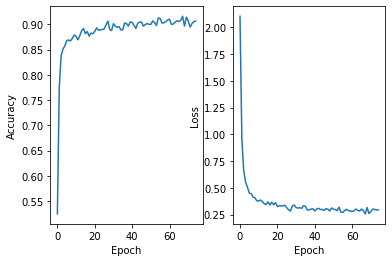

In [6]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
20 dB SNR --
(8640, 68)
	labels:      (0, 67)
	predictions: (0, 67)
8640/8640 - 0s - loss: 0.2977 - sparse_categorical_accuracy: 0.9068
	Test accuracy: 0.9068287


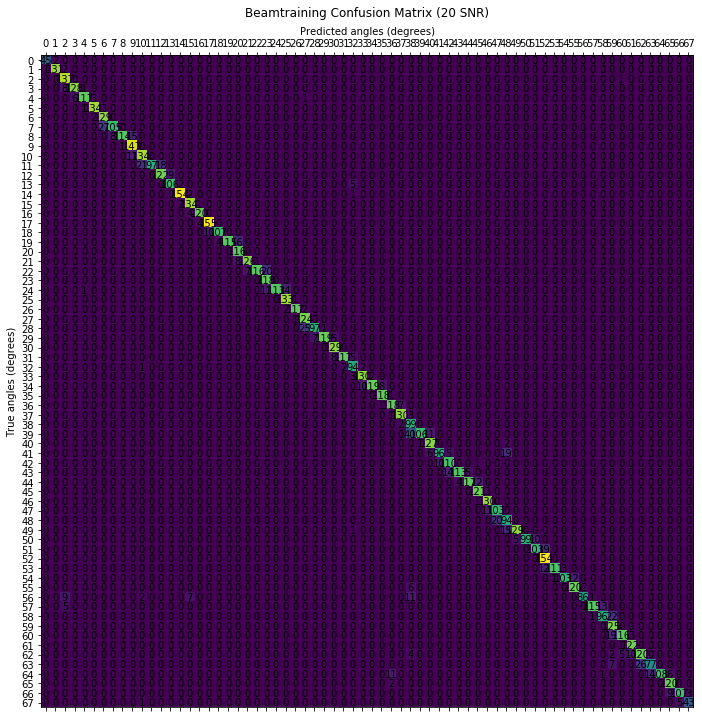

30 dB SNR --
(8640, 68)
	labels:      (0, 67)
	predictions: (0, 67)
8640/8640 - 0s - loss: 0.2338 - sparse_categorical_accuracy: 0.9206
	Test accuracy: 0.92060184


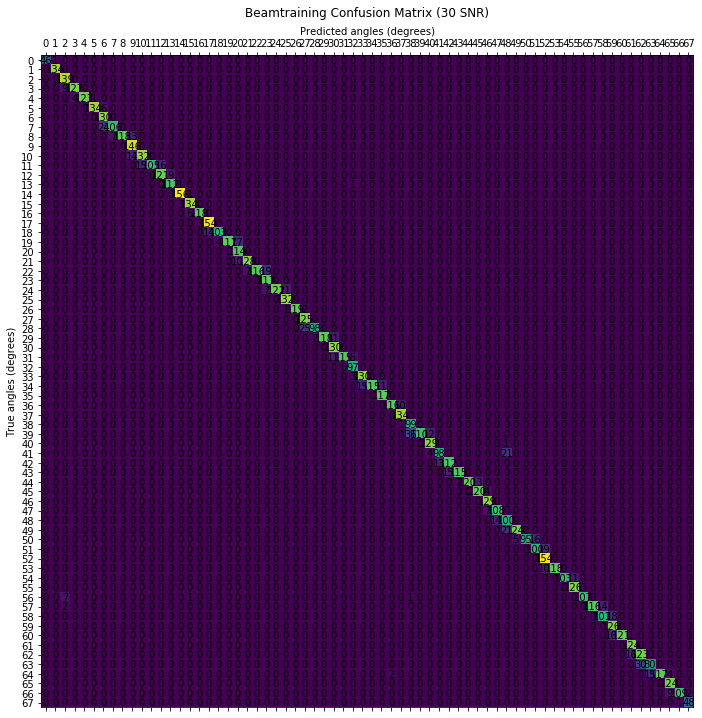

ALL SNR values --
(17280, 68)
	labels:      (0, 67)
	predictions: (0, 67)
17280/17280 - 1s - loss: 0.2658 - sparse_categorical_accuracy: 0.9137
	Test accuracy: 0.9137153


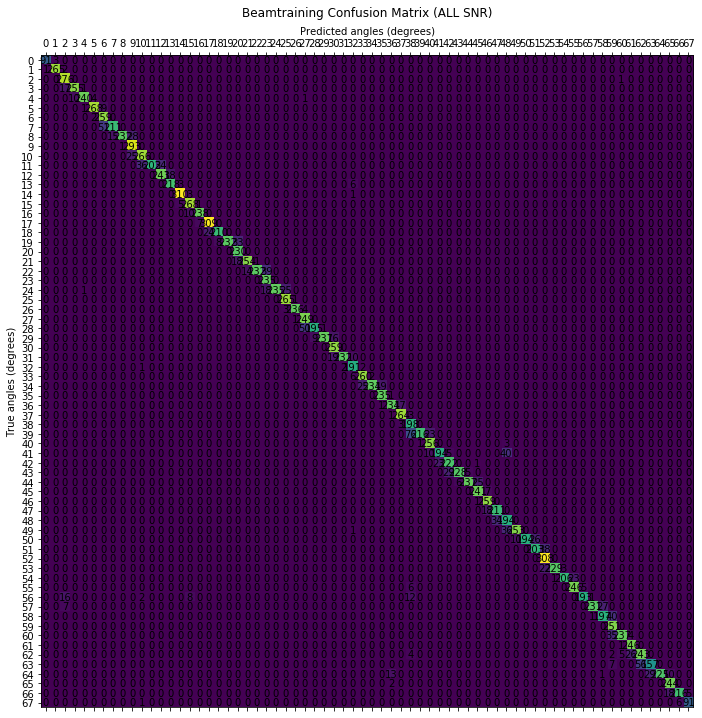


Number of results:            (1, 3)
Confusion matrix tensor size: (1, 3, 68, 68)
20 dB SNR --
30 dB SNR --
20 dB SNR --
Gain Loss Percentiles, SNR 20
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.   ]
 [100.     55.993]]
30 dB SNR --
Gain Loss Percentiles, SNR 30
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.   ]
 [100.     56.005]]
ALL SNR values --
Gain Loss Percentiles, SNR ALL
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.   ]
 [100.     56.005]]

Average Test Accuracies: 
	SNR: 20; Accuracy: 0.9068287014961243
	SNR: 30; Accuracy: 0.9206018447875977


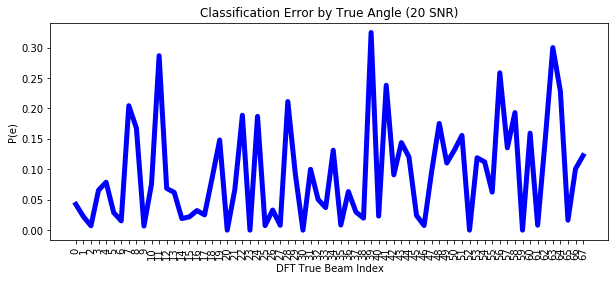

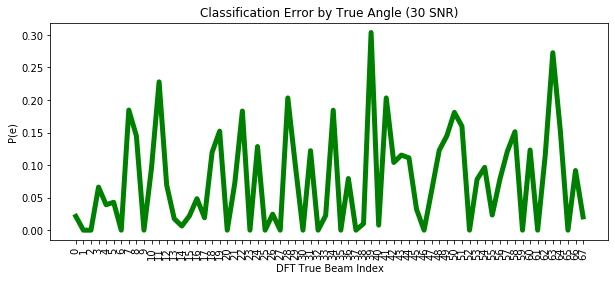

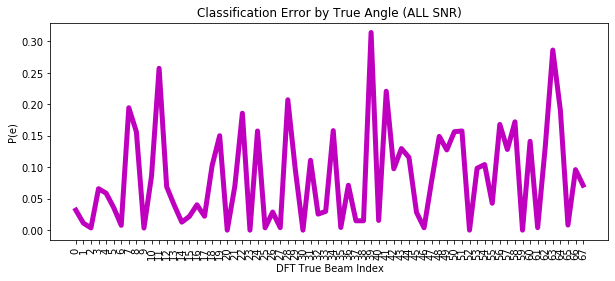

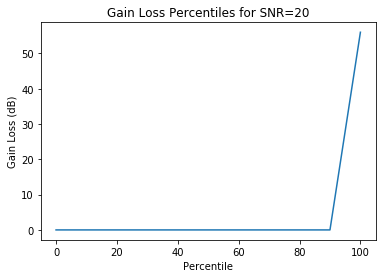

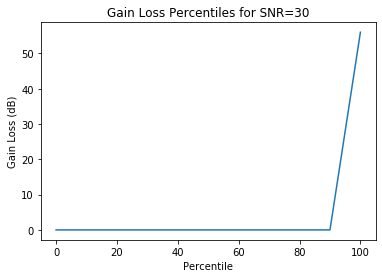

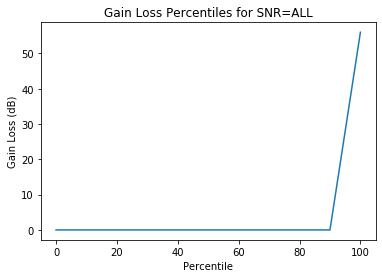

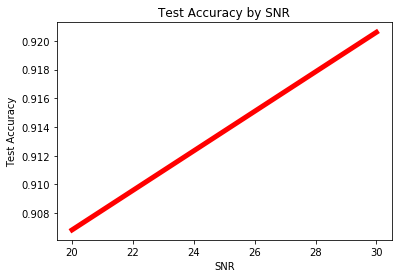

In [7]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim{}_{}meas_{}SNR.png'.format(NN_NUM, NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 8 Measurements


Training model for PN combo 0...
Train on 2720 samples
Epoch 1/75
2720/2720 [==============================] - 1s 526us/sample - loss: 2.3366 - sparse_categorical_accuracy: 0.4449
Epoch 2/75
2720/2720 [==============================] - 1s 295us/sample - loss: 1.1485 - sparse_categorical_accuracy: 0.7371
Epoch 3/75
2720/2720 [==============================] - 1s 299us/sample - loss: 0.8829 - sparse_categorical_accuracy: 0.7728
Epoch 4/75
2720/2720 [==============================] - 1s 296us/sample - loss: 0.7587 - sparse_categorical_accuracy: 0.8015
Epoch 5/75
2720/2720 [==============================] - 1s 306us/sample - loss: 0.6370 - sparse_categorical_accuracy: 0.8327
Epoch 6/75
2720/2720 [==============================] - 1s 317us/sample - loss: 0.6006 - sparse_categorical_accuracy: 0.8287
Epoch 7/75
2720/2720 [==============================] - 1s 310us/sample - loss: 0.5766 - sparse_categorical_accuracy: 0.8283
Epoch 8/75
2720/2720 [==============================] - 1s 311us/samp

Text(0.5, 0, 'Epoch')

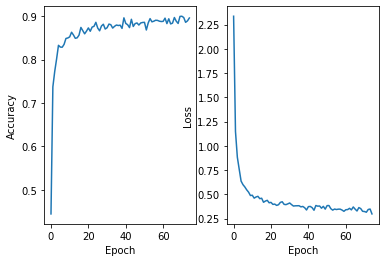

In [10]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
20 dB SNR --
(8640, 68)
	labels:      (0, 67)
	predictions: (0, 67)
8640/8640 - 0s - loss: 0.4798 - sparse_categorical_accuracy: 0.8663
	Test accuracy: 0.8663194


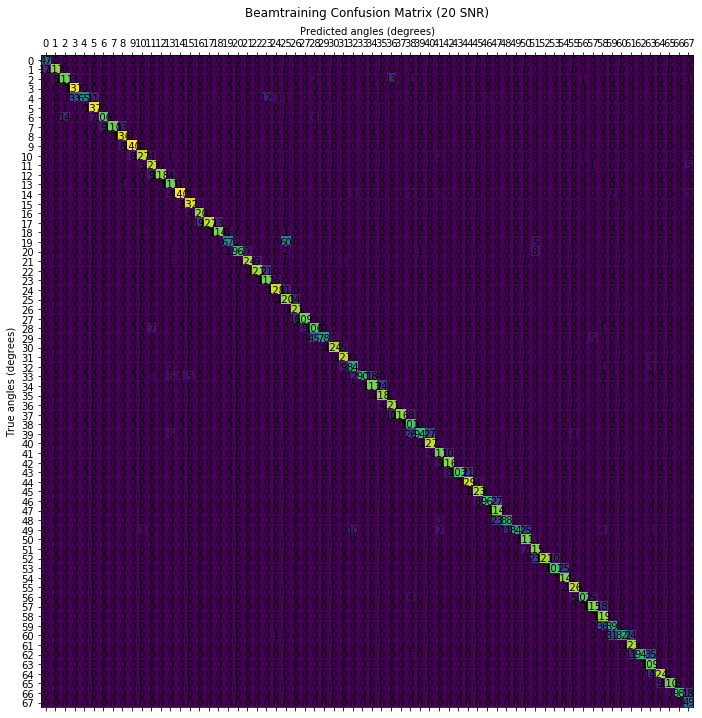

30 dB SNR --
(8640, 68)
	labels:      (0, 67)
	predictions: (0, 67)
8640/8640 - 0s - loss: 0.3722 - sparse_categorical_accuracy: 0.8896
	Test accuracy: 0.88958335


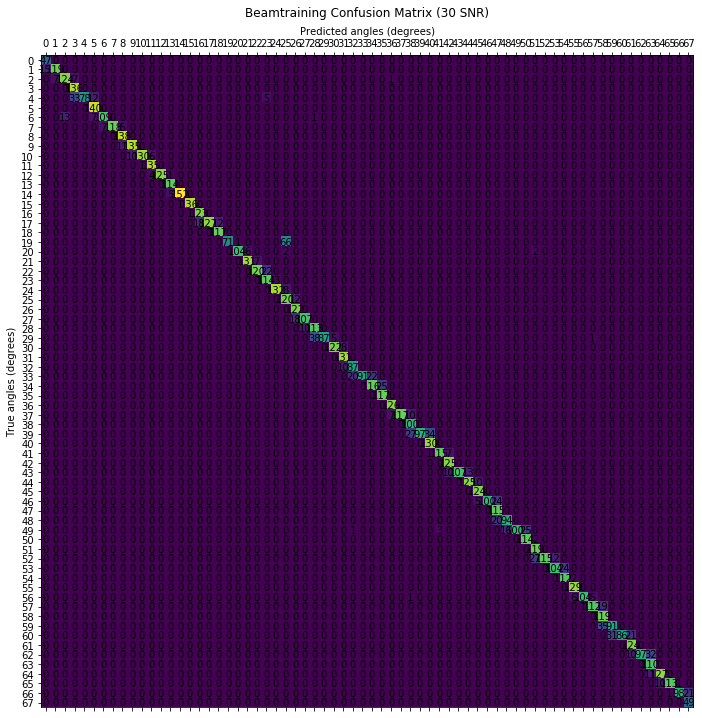

ALL SNR values --
(17280, 68)
	labels:      (0, 67)
	predictions: (0, 67)
17280/17280 - 1s - loss: 0.4260 - sparse_categorical_accuracy: 0.8780
	Test accuracy: 0.8779514


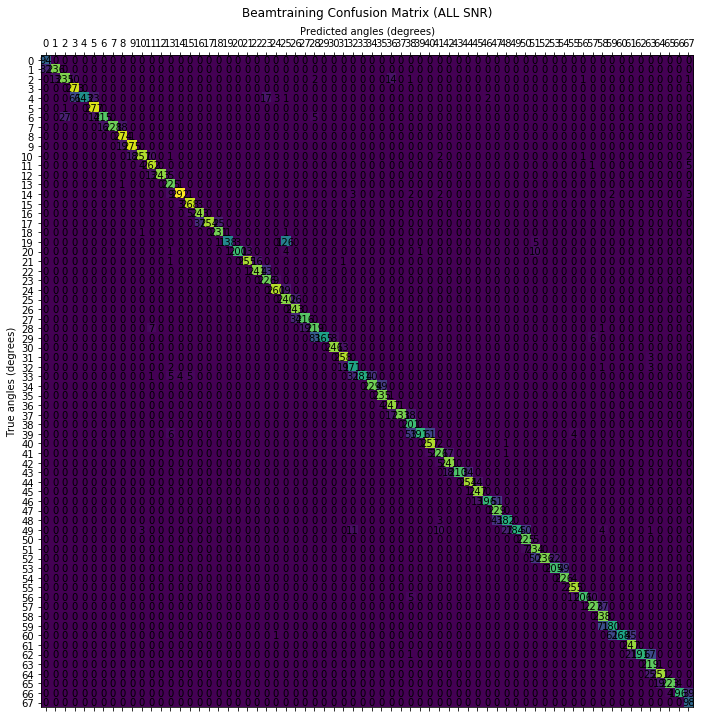


Number of results:            (1, 3)
Confusion matrix tensor size: (1, 3, 68, 68)
20 dB SNR --
30 dB SNR --
20 dB SNR --
Gain Loss Percentiles, SNR 20
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.254]
 [100.     48.495]]
30 dB SNR --
Gain Loss Percentiles, SNR 30
[[0.0000e+00 0.0000e+00]
 [1.0000e+01 0.0000e+00]
 [2.0000e+01 0.0000e+00]
 [3.0000e+01 0.0000e+00]
 [4.0000e+01 0.0000e+00]
 [5.0000e+01 0.0000e+00]
 [6.0000e+01 0.0000e+00]
 [7.0000e+01 0.0000e+00]
 [8.0000e+01 0.0000e+00]
 [9.0000e+01 7.3000e-02]
 [1.0000e+02 5.5228e+01]]
ALL SNR values --
Gain Loss Percentiles, SNR ALL
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.162]
 [100.     55.228]]

Average Test Accuracies: 
	SNR: 20; Accuracy: 0.86631941795

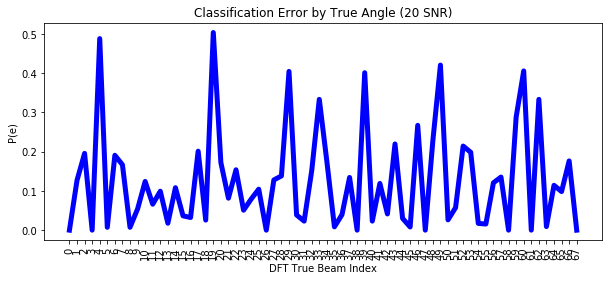

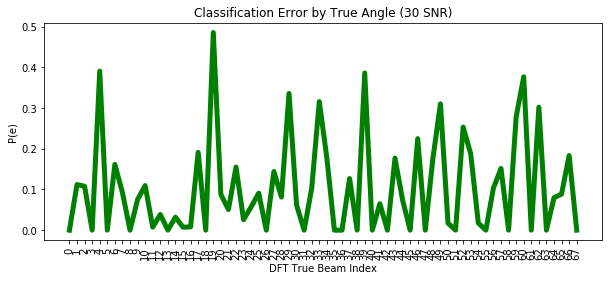

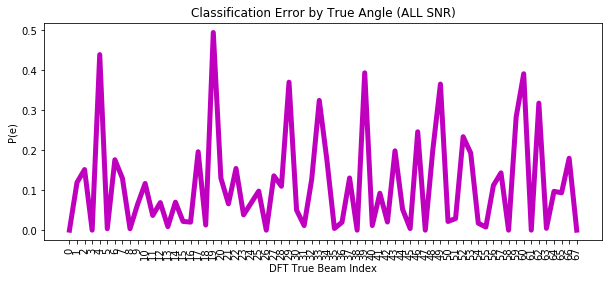

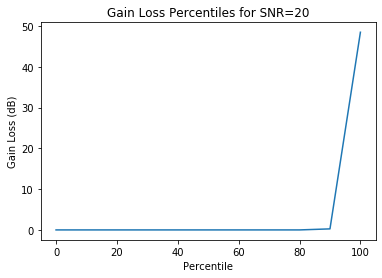

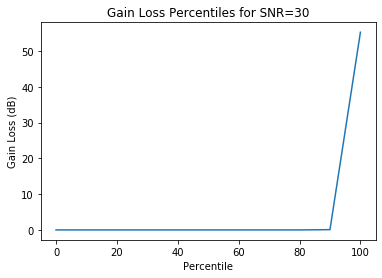

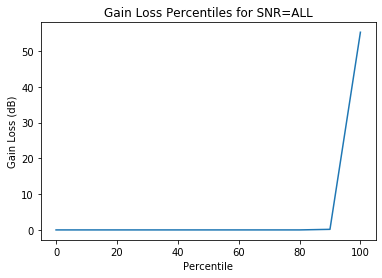

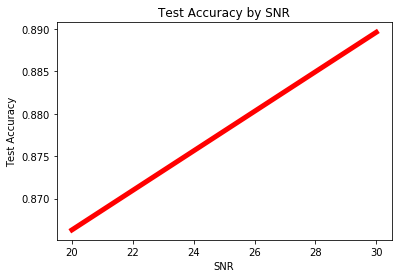

In [11]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim4_{}meas_{}SNR.png'.format(NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 7 Measurements


Training model for PN combo 0...
Train on 2720 samples
Epoch 1/75
2720/2720 [==============================] - 2s 690us/sample - loss: 2.4466 - sparse_categorical_accuracy: 0.4235
Epoch 2/75
2720/2720 [==============================] - 1s 444us/sample - loss: 1.4850 - sparse_categorical_accuracy: 0.6279
Epoch 3/75
2720/2720 [==============================] - 1s 432us/sample - loss: 1.2218 - sparse_categorical_accuracy: 0.6776
Epoch 4/75
2720/2720 [==============================] - 1s 435us/sample - loss: 1.0291 - sparse_categorical_accuracy: 0.7246
Epoch 5/75
2720/2720 [==============================] - 1s 437us/sample - loss: 0.9467 - sparse_categorical_accuracy: 0.7441
Epoch 6/75
2720/2720 [==============================] - 1s 435us/sample - loss: 0.8533 - sparse_categorical_accuracy: 0.7636
Epoch 7/75
2720/2720 [==============================] - 1s 434us/sample - loss: 0.7956 - sparse_categorical_accuracy: 0.7724
Epoch 8/75
2720/2720 [==============================] - 1s 436us/samp

Text(0.5, 0, 'Epoch')

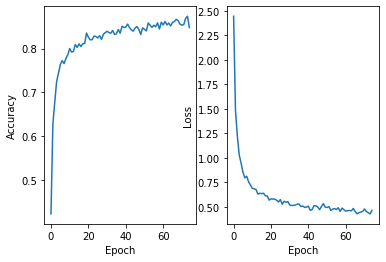

In [14]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
20 dB SNR --
(8640, 68)
	labels:      (0, 67)
	predictions: (0, 67)
8640/8640 - 0s - loss: 0.4471 - sparse_categorical_accuracy: 0.8708
	Test accuracy: 0.87083334


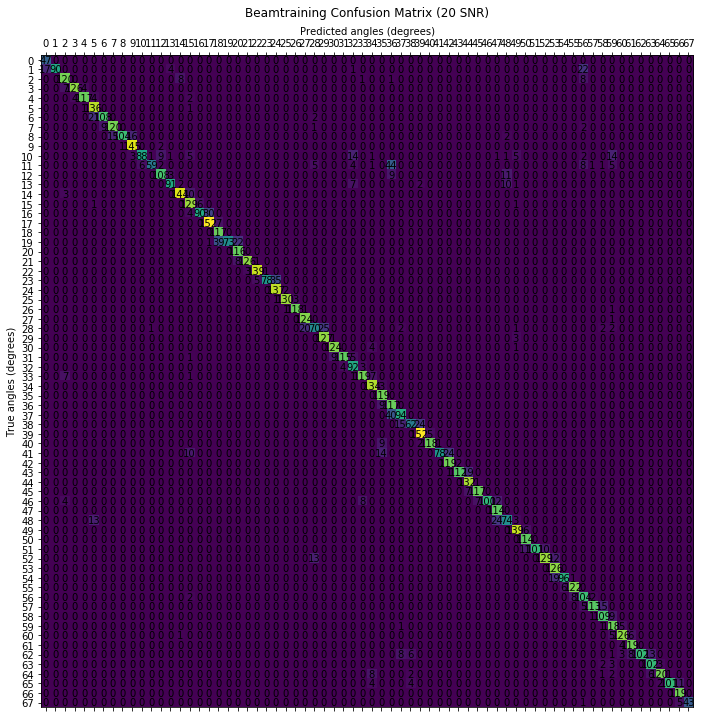

30 dB SNR --
(8640, 68)
	labels:      (0, 67)
	predictions: (0, 67)
8640/8640 - 0s - loss: 0.3213 - sparse_categorical_accuracy: 0.9025
	Test accuracy: 0.9025463


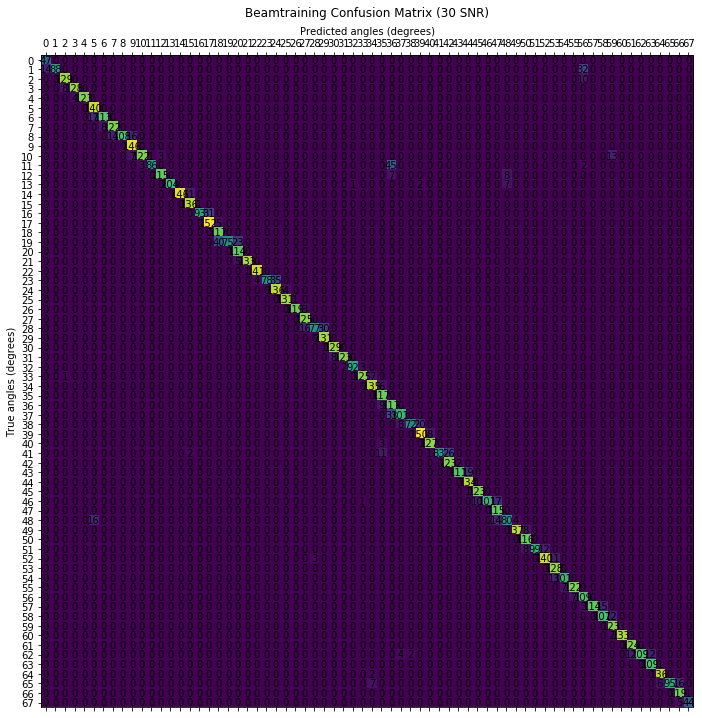

ALL SNR values --
(17280, 68)
	labels:      (0, 67)
	predictions: (0, 67)
17280/17280 - 1s - loss: 0.3842 - sparse_categorical_accuracy: 0.8867
	Test accuracy: 0.88668984


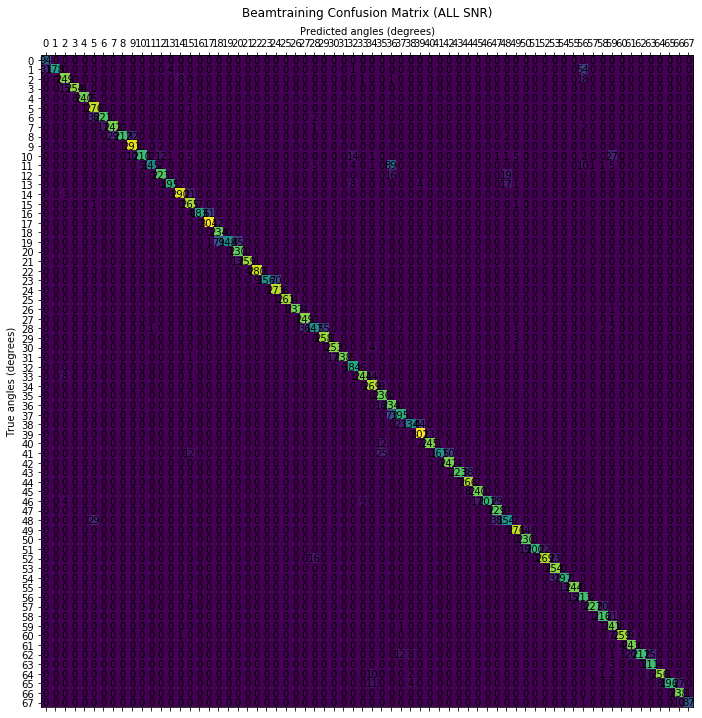


Number of results:            (1, 3)
Confusion matrix tensor size: (1, 3, 68, 68)
20 dB SNR --
30 dB SNR --
20 dB SNR --
Gain Loss Percentiles, SNR 20
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.272]
 [100.     64.413]]
30 dB SNR --
Gain Loss Percentiles, SNR 30
[[  0.     0.  ]
 [ 10.     0.  ]
 [ 20.     0.  ]
 [ 30.     0.  ]
 [ 40.     0.  ]
 [ 50.     0.  ]
 [ 60.     0.  ]
 [ 70.     0.  ]
 [ 80.     0.  ]
 [ 90.     0.  ]
 [100.    57.98]]
ALL SNR values --
Gain Loss Percentiles, SNR ALL
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.102]
 [100.     64.413]]

Average Test Accuracies: 
	SNR: 20; Accuracy: 0.8708333373069763
	SNR: 30; Accuracy: 0.9025462865829468


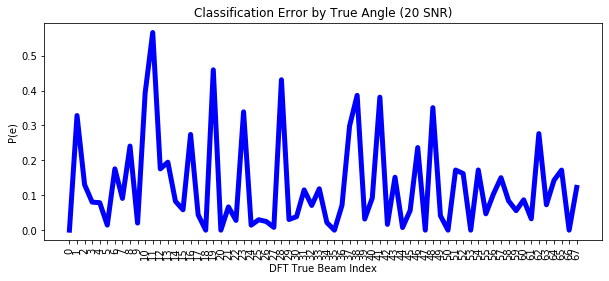

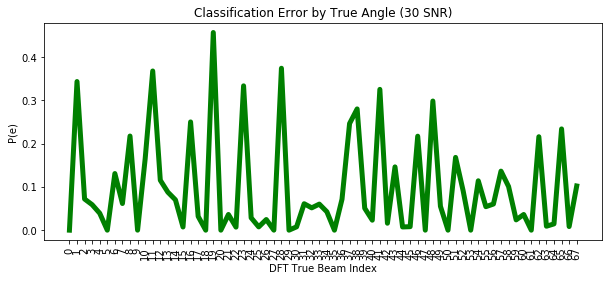

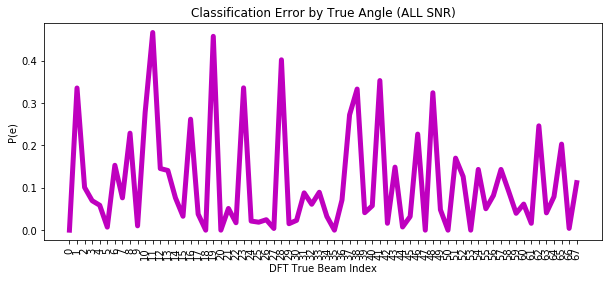

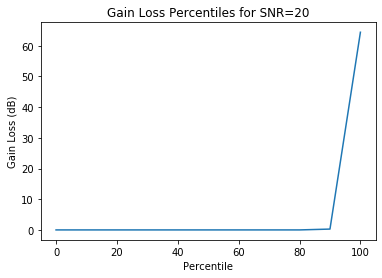

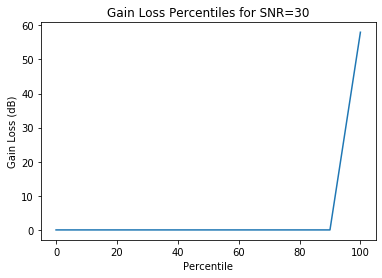

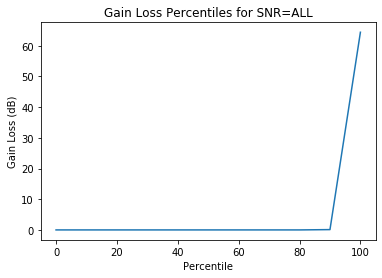

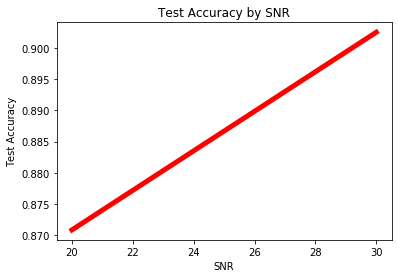

In [15]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim{}_{}meas_{}SNR.png'.format(NN_NUM, NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 6 Measurements


Training model for PN combo 0...
Train on 2720 samples
Epoch 1/75
2720/2720 [==============================] - 2s 809us/sample - loss: 2.7206 - sparse_categorical_accuracy: 0.3471
Epoch 2/75
2720/2720 [==============================] - 1s 503us/sample - loss: 1.8877 - sparse_categorical_accuracy: 0.5316
Epoch 3/75
2720/2720 [==============================] - 1s 502us/sample - loss: 1.5785 - sparse_categorical_accuracy: 0.5816
Epoch 4/75
2720/2720 [==============================] - 1s 502us/sample - loss: 1.4230 - sparse_categorical_accuracy: 0.6180
Epoch 5/75
2720/2720 [==============================] - 1s 500us/sample - loss: 1.3005 - sparse_categorical_accuracy: 0.6482
Epoch 6/75
2720/2720 [==============================] - 1s 500us/sample - loss: 1.2135 - sparse_categorical_accuracy: 0.6640
Epoch 7/75
2720/2720 [==============================] - 1s 505us/sample - loss: 1.1321 - sparse_categorical_accuracy: 0.6893
Epoch 8/75
2720/2720 [==============================] - 1s 503us/samp

Text(0.5, 0, 'Epoch')

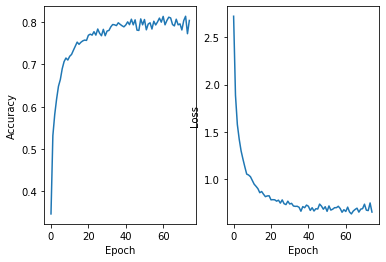

In [18]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
20 dB SNR --
(8640, 68)
	labels:      (0, 67)
	predictions: (0, 67)
8640/8640 - 0s - loss: 1.8983 - sparse_categorical_accuracy: 0.6914
	Test accuracy: 0.69143516


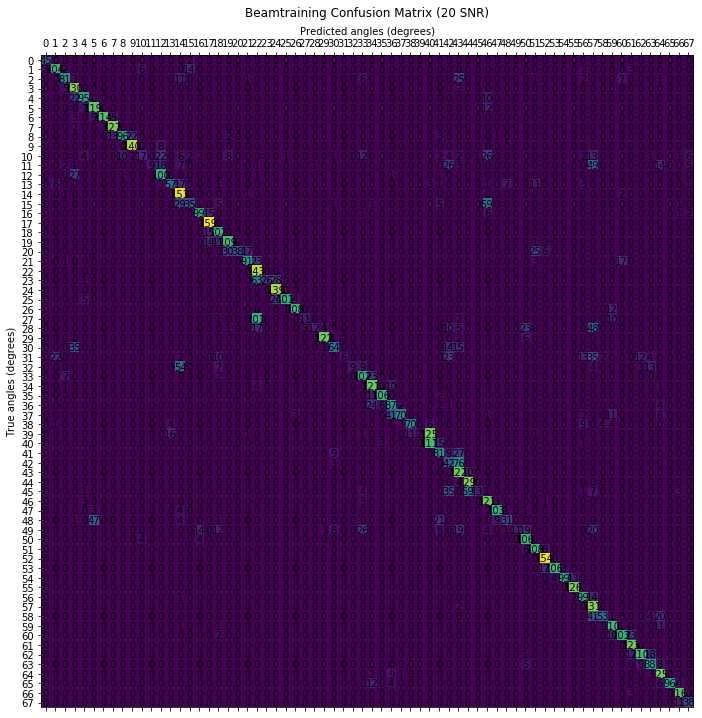

30 dB SNR --
(8640, 68)
	labels:      (0, 67)
	predictions: (0, 67)
8640/8640 - 0s - loss: 1.5818 - sparse_categorical_accuracy: 0.7378
	Test accuracy: 0.7378472


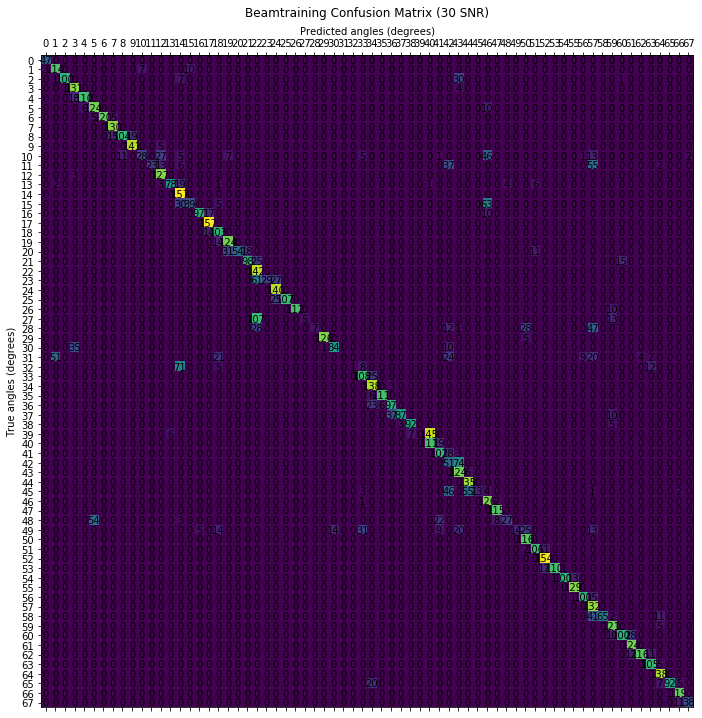

ALL SNR values --
(17280, 68)
	labels:      (0, 67)
	predictions: (0, 67)
17280/17280 - 1s - loss: 1.7400 - sparse_categorical_accuracy: 0.7146
	Test accuracy: 0.7146412


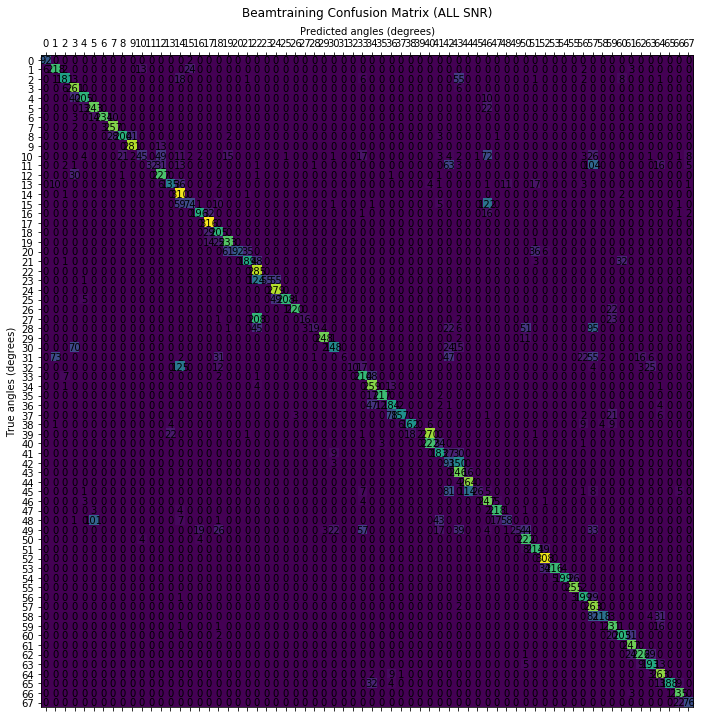


Number of results:            (1, 3)
Confusion matrix tensor size: (1, 3, 68, 68)
20 dB SNR --
30 dB SNR --
20 dB SNR --
Gain Loss Percentiles, SNR 20
[[0.0000e+00 0.0000e+00]
 [1.0000e+01 0.0000e+00]
 [2.0000e+01 0.0000e+00]
 [3.0000e+01 0.0000e+00]
 [4.0000e+01 0.0000e+00]
 [5.0000e+01 0.0000e+00]
 [6.0000e+01 0.0000e+00]
 [7.0000e+01 8.0000e-02]
 [8.0000e+01 2.8940e+00]
 [9.0000e+01 2.9063e+01]
 [1.0000e+02 6.7414e+01]]
30 dB SNR --
Gain Loss Percentiles, SNR 30
[[  0.       0.    ]
 [ 10.       0.    ]
 [ 20.       0.    ]
 [ 30.       0.    ]
 [ 40.       0.    ]
 [ 50.       0.    ]
 [ 60.       0.    ]
 [ 70.       0.    ]
 [ 80.       0.736 ]
 [ 90.      25.1177]
 [100.      68.491 ]]
ALL SNR values --
Gain Loss Percentiles, SNR ALL
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      1.331]
 [ 90.     28.177]
 [100.     68.491]]

Average Test Accuracies: 
	SNR: 20; A

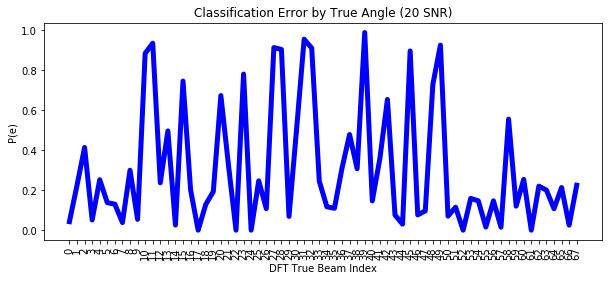

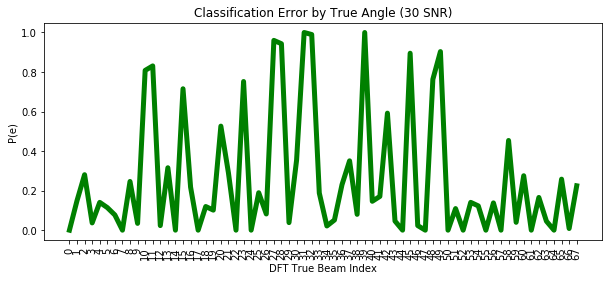

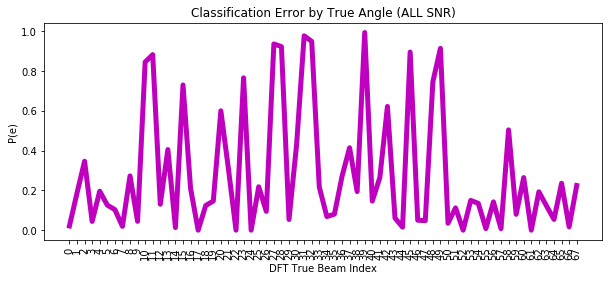

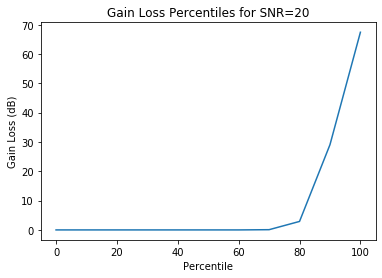

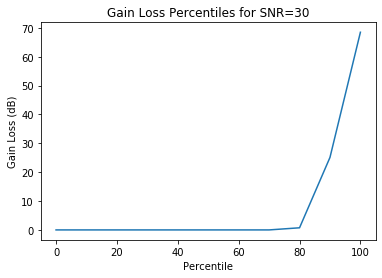

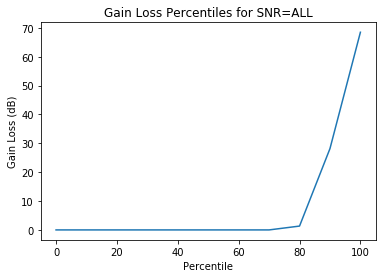

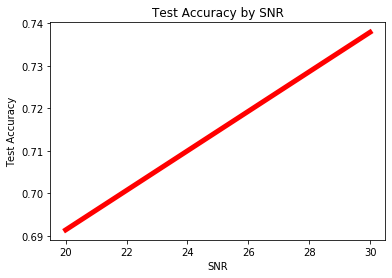

In [19]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim{}_{}meas_{}SNR.png'.format(NN_NUM, NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

# Nr = 60, 20 measurements per label and SNR
- Requires M = 7 (max 1 dB gain loss for the combined SNRs at the 90th percentile)

### NN for 10 Measurements


Training model for PN combo 0...
Train on 3400 samples
Epoch 1/75
3400/3400 [==============================] - 1s 419us/sample - loss: 2.3895 - sparse_categorical_accuracy: 0.4897
Epoch 2/75
3400/3400 [==============================] - 1s 243us/sample - loss: 0.9288 - sparse_categorical_accuracy: 0.8174
Epoch 3/75
3400/3400 [==============================] - 1s 234us/sample - loss: 0.6261 - sparse_categorical_accuracy: 0.8450
Epoch 4/75
3400/3400 [==============================] - 1s 227us/sample - loss: 0.4846 - sparse_categorical_accuracy: 0.8753
Epoch 5/75
3400/3400 [==============================] - 1s 230us/sample - loss: 0.4468 - sparse_categorical_accuracy: 0.8765
Epoch 6/75
3400/3400 [==============================] - 1s 229us/sample - loss: 0.3938 - sparse_categorical_accuracy: 0.8853
Epoch 7/75
3400/3400 [==============================] - 1s 228us/sample - loss: 0.4150 - sparse_categorical_accuracy: 0.8706
Epoch 8/75
3400/3400 [==============================] - 1s 227us/samp

Text(0.5, 0, 'Epoch')

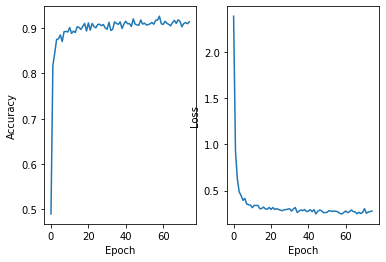

In [22]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
20 dB SNR --
(8300, 85)
	labels:      (0, 84)
	predictions: (0, 84)
8300/8300 - 0s - loss: 0.4363 - sparse_categorical_accuracy: 0.8795
	Test accuracy: 0.8795181


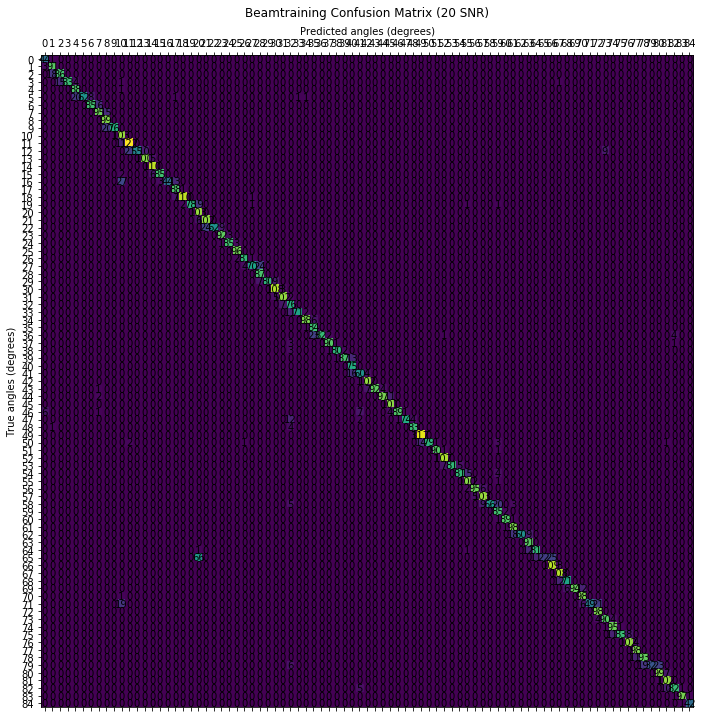

30 dB SNR --
(8300, 85)
	labels:      (0, 84)
	predictions: (0, 84)
8300/8300 - 0s - loss: 0.3516 - sparse_categorical_accuracy: 0.8971
	Test accuracy: 0.89710844


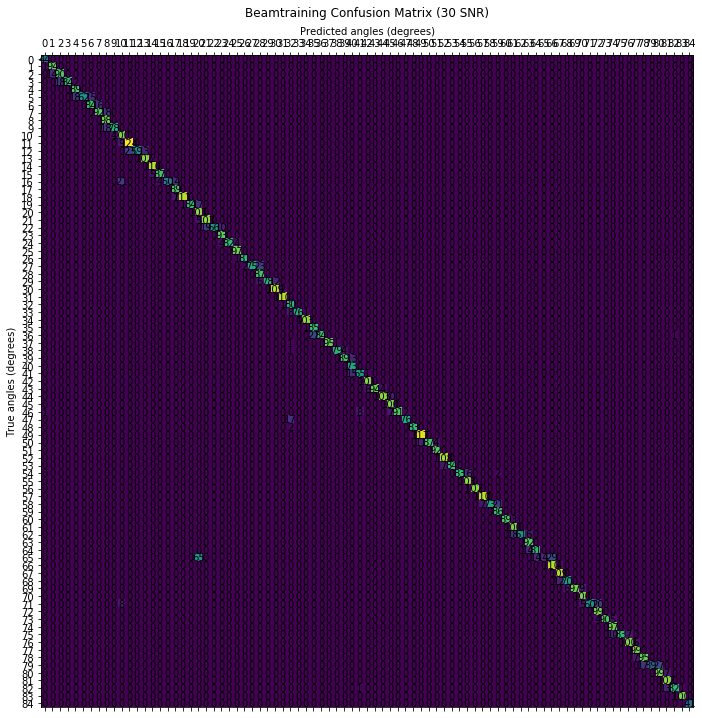

ALL SNR values --
(16600, 85)
	labels:      (0, 84)
	predictions: (0, 84)
16600/16600 - 1s - loss: 0.3940 - sparse_categorical_accuracy: 0.8883
	Test accuracy: 0.88831323


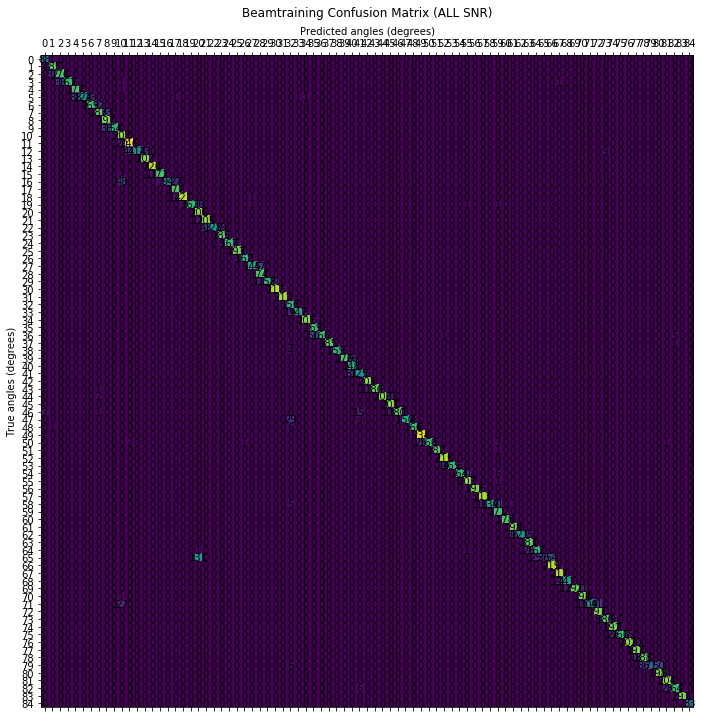


Number of results:            (1, 3)
Confusion matrix tensor size: (1, 3, 85, 85)
20 dB SNR --
30 dB SNR --
20 dB SNR --
Gain Loss Percentiles, SNR 20
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.149]
 [100.     71.353]]
30 dB SNR --
Gain Loss Percentiles, SNR 30
[[0.0000e+00 0.0000e+00]
 [1.0000e+01 0.0000e+00]
 [2.0000e+01 0.0000e+00]
 [3.0000e+01 0.0000e+00]
 [4.0000e+01 0.0000e+00]
 [5.0000e+01 0.0000e+00]
 [6.0000e+01 0.0000e+00]
 [7.0000e+01 0.0000e+00]
 [8.0000e+01 0.0000e+00]
 [9.0000e+01 2.4000e-02]
 [1.0000e+02 5.5903e+01]]
ALL SNR values --
Gain Loss Percentiles, SNR ALL
[[0.0000e+00 0.0000e+00]
 [1.0000e+01 0.0000e+00]
 [2.0000e+01 0.0000e+00]
 [3.0000e+01 0.0000e+00]
 [4.0000e+01 0.0000e+00]
 [5.0000e+01 0.0000e+00]
 [6.0000e+01 0.0000e+00]
 [7.0000e+01 0.0000e+00]
 [8.0000e+01 0.0000e+00]
 [9.0000e+01 8.0000e-02]
 [1.0000e+02 7.1353e

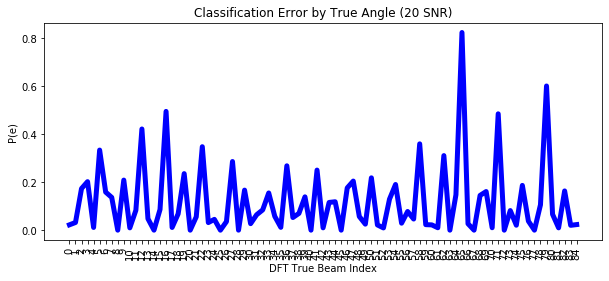

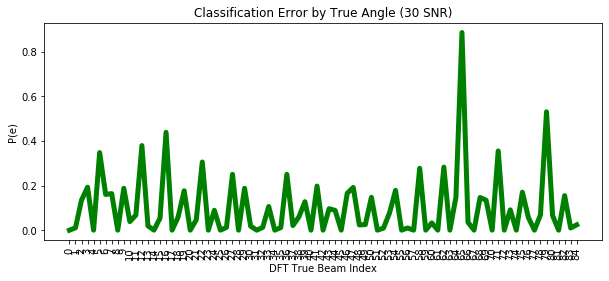

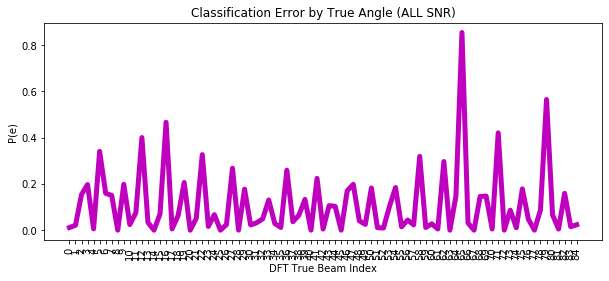

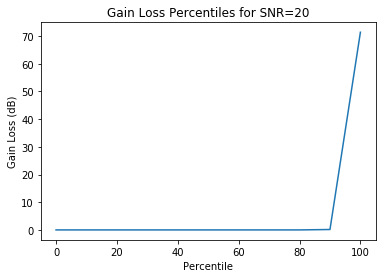

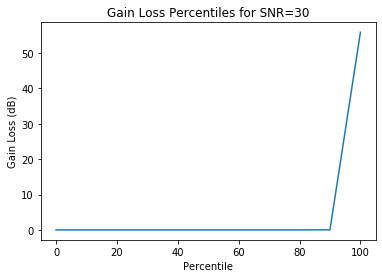

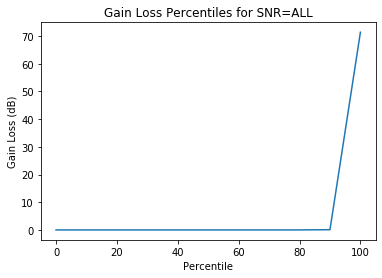

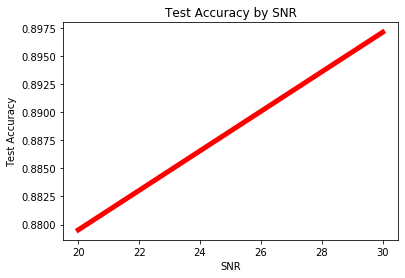

In [23]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim{}_{}meas_{}SNR.png'.format(NN_NUM, NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 9 Measurements


Training model for PN combo 0...
Train on 3400 samples
Epoch 1/75
3400/3400 [==============================] - 2s 548us/sample - loss: 2.3815 - sparse_categorical_accuracy: 0.4862
Epoch 2/75
3400/3400 [==============================] - 1s 339us/sample - loss: 1.0734 - sparse_categorical_accuracy: 0.7715
Epoch 3/75
3400/3400 [==============================] - 1s 334us/sample - loss: 0.7639 - sparse_categorical_accuracy: 0.8162
Epoch 4/75
3400/3400 [==============================] - 1s 335us/sample - loss: 0.6247 - sparse_categorical_accuracy: 0.8429
Epoch 5/75
3400/3400 [==============================] - 1s 341us/sample - loss: 0.5361 - sparse_categorical_accuracy: 0.8515
Epoch 6/75
3400/3400 [==============================] - 1s 345us/sample - loss: 0.4999 - sparse_categorical_accuracy: 0.8606
Epoch 7/75
3400/3400 [==============================] - 1s 337us/sample - loss: 0.4732 - sparse_categorical_accuracy: 0.8676
Epoch 8/75
3400/3400 [==============================] - 1s 340us/samp

Text(0.5, 0, 'Epoch')

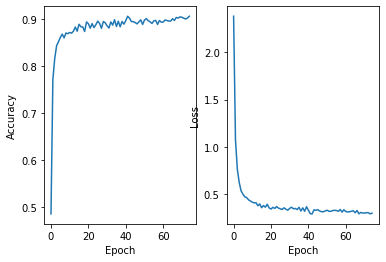

In [26]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
20 dB SNR --
(8300, 85)
	labels:      (0, 84)
	predictions: (0, 84)
8300/8300 - 0s - loss: 0.6071 - sparse_categorical_accuracy: 0.8418
	Test accuracy: 0.84180725


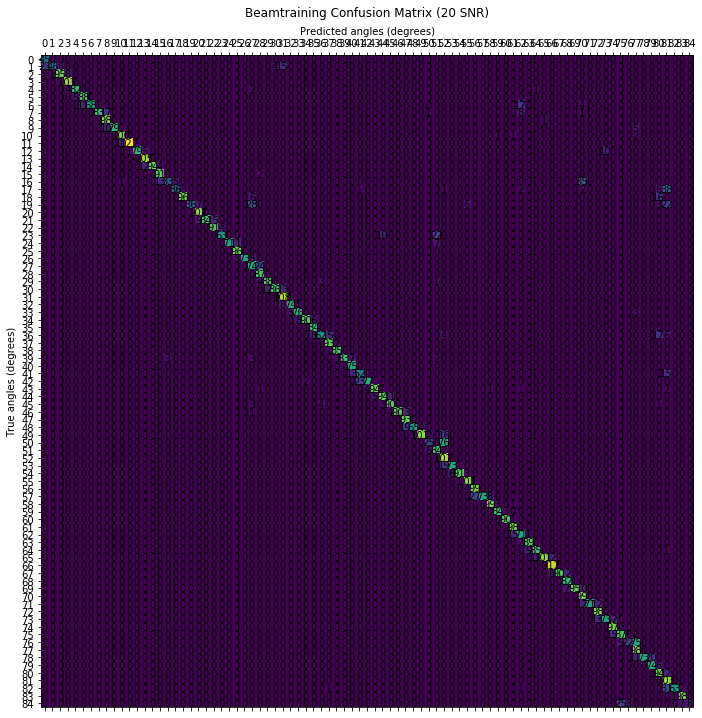

30 dB SNR --
(8300, 85)
	labels:      (0, 84)
	predictions: (0, 83)
8300/8300 - 0s - loss: 0.4872 - sparse_categorical_accuracy: 0.8601
	Test accuracy: 0.8601205


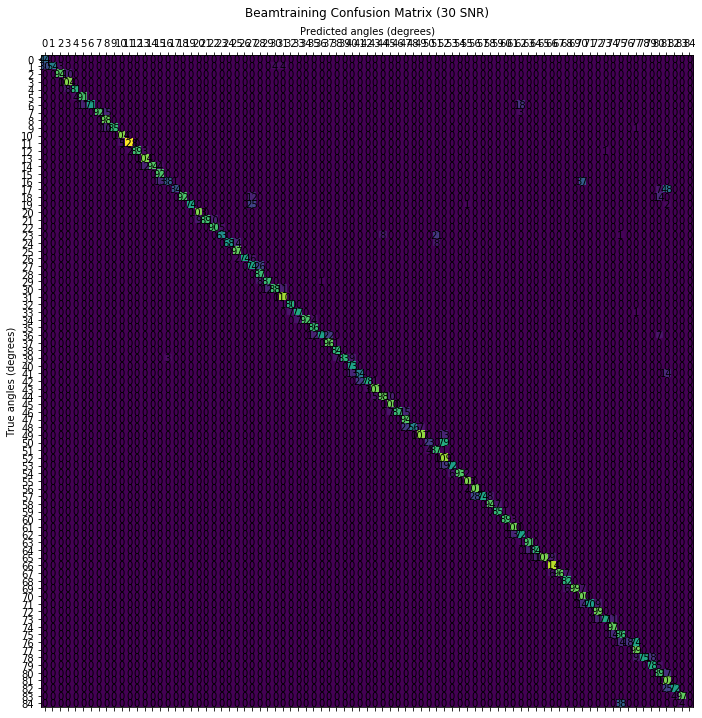

ALL SNR values --
(16600, 85)
	labels:      (0, 84)
	predictions: (0, 84)
16600/16600 - 1s - loss: 0.5472 - sparse_categorical_accuracy: 0.8510
	Test accuracy: 0.85096383


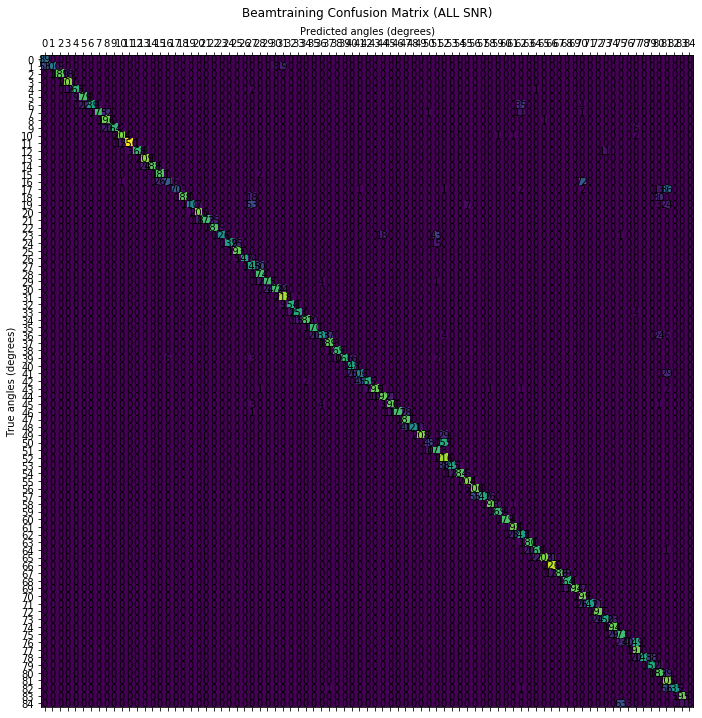


Number of results:            (1, 3)
Confusion matrix tensor size: (1, 3, 85, 85)
20 dB SNR --
30 dB SNR --
20 dB SNR --
Gain Loss Percentiles, SNR 20
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.514]
 [100.     66.489]]
30 dB SNR --
Gain Loss Percentiles, SNR 30
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.296]
 [100.     54.233]]
ALL SNR values --
Gain Loss Percentiles, SNR ALL
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.409]
 [100.     66.489]]

Average Test Accuracies: 
	SNR: 20; Accuracy: 0.8418072462081909
	SNR: 30; Accuracy: 0.8601204752922058


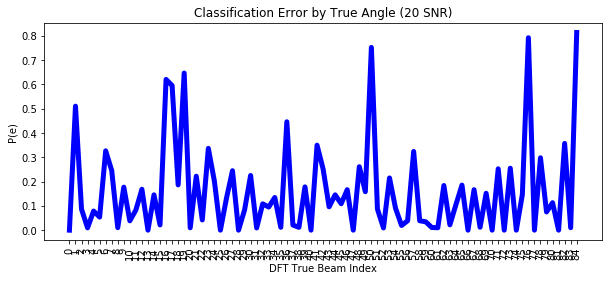

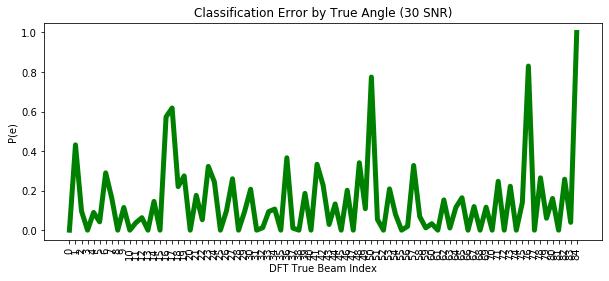

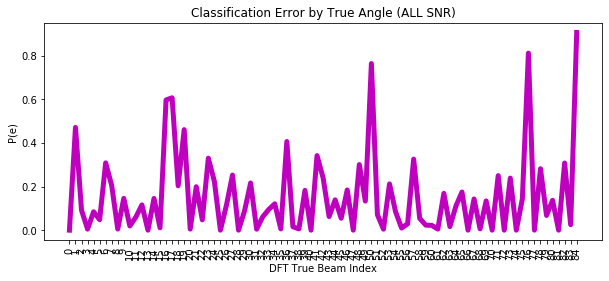

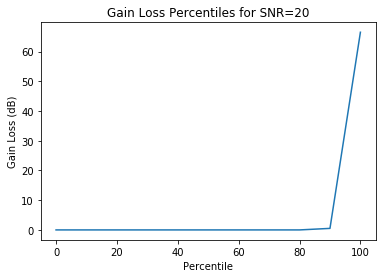

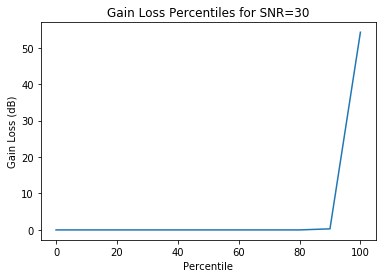

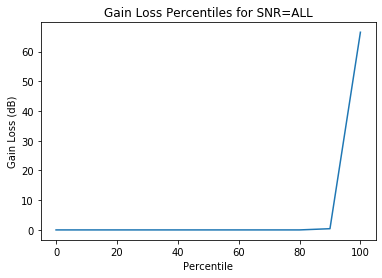

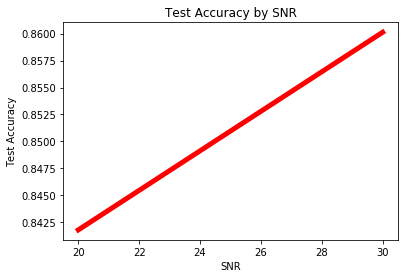

In [27]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim{}_{}meas_{}SNR.png'.format(NN_NUM, NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 8 Measurements


Training model for PN combo 0...
Train on 3400 samples
Epoch 1/75
3400/3400 [==============================] - 2s 496us/sample - loss: 2.5227 - sparse_categorical_accuracy: 0.4379
Epoch 2/75
3400/3400 [==============================] - 1s 299us/sample - loss: 1.3959 - sparse_categorical_accuracy: 0.6862
Epoch 3/75
3400/3400 [==============================] - 1s 292us/sample - loss: 1.0917 - sparse_categorical_accuracy: 0.7371
Epoch 4/75
3400/3400 [==============================] - 1s 295us/sample - loss: 0.9156 - sparse_categorical_accuracy: 0.7674
Epoch 5/75
3400/3400 [==============================] - 1s 288us/sample - loss: 0.8370 - sparse_categorical_accuracy: 0.7706
Epoch 6/75
3400/3400 [==============================] - 1s 299us/sample - loss: 0.7938 - sparse_categorical_accuracy: 0.7826
Epoch 7/75
3400/3400 [==============================] - 1s 290us/sample - loss: 0.7367 - sparse_categorical_accuracy: 0.7929
Epoch 8/75
3400/3400 [==============================] - 1s 293us/samp

Text(0.5, 0, 'Epoch')

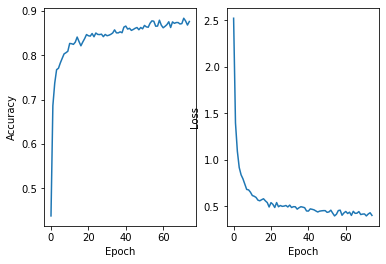

In [30]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
20 dB SNR --
(8300, 85)
	labels:      (0, 84)
	predictions: (0, 84)
8300/8300 - 0s - loss: 0.5861 - sparse_categorical_accuracy: 0.8496
	Test accuracy: 0.8496386


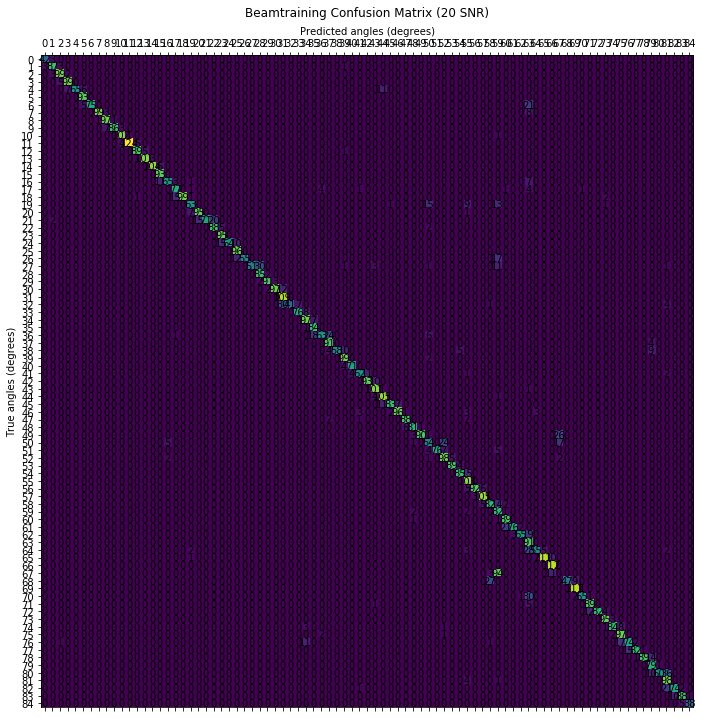

30 dB SNR --
(8300, 85)
	labels:      (0, 84)
	predictions: (0, 84)
8300/8300 - 0s - loss: 0.4493 - sparse_categorical_accuracy: 0.8775
	Test accuracy: 0.8774699


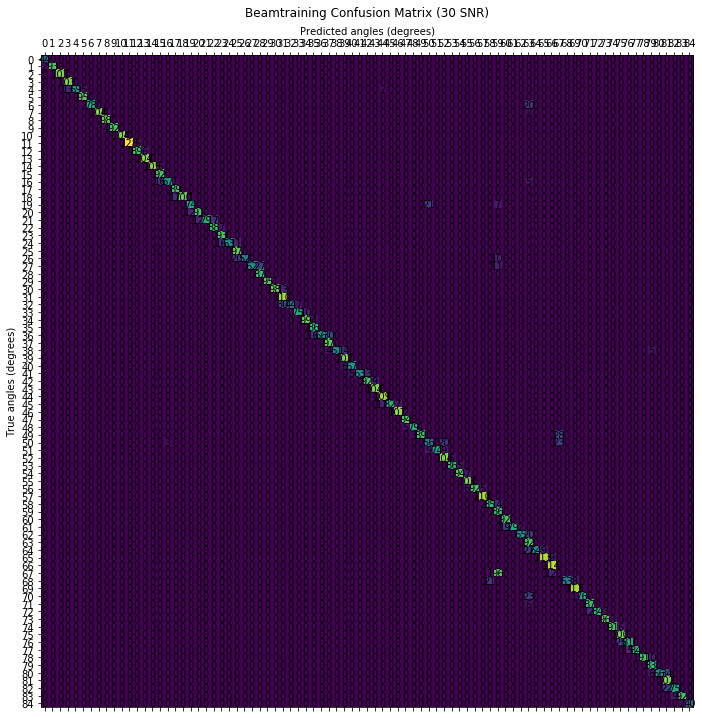

ALL SNR values --
(16600, 85)
	labels:      (0, 84)
	predictions: (0, 84)
16600/16600 - 1s - loss: 0.5177 - sparse_categorical_accuracy: 0.8636
	Test accuracy: 0.86355424


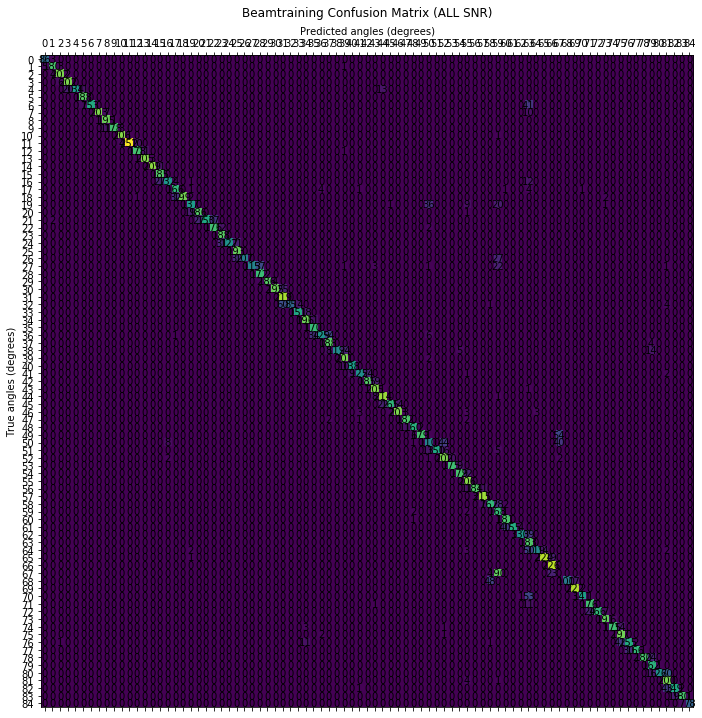


Number of results:            (1, 3)
Confusion matrix tensor size: (1, 3, 85, 85)
20 dB SNR --
30 dB SNR --
20 dB SNR --
Gain Loss Percentiles, SNR 20
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.497]
 [100.     62.672]]
30 dB SNR --
Gain Loss Percentiles, SNR 30
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.182]
 [100.     62.672]]
ALL SNR values --
Gain Loss Percentiles, SNR ALL
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.316]
 [100.     62.672]]

Average Test Accuracies: 
	SNR: 20; Accuracy: 0.8496385812759399
	SNR: 30; Accuracy: 0.8774698972702026


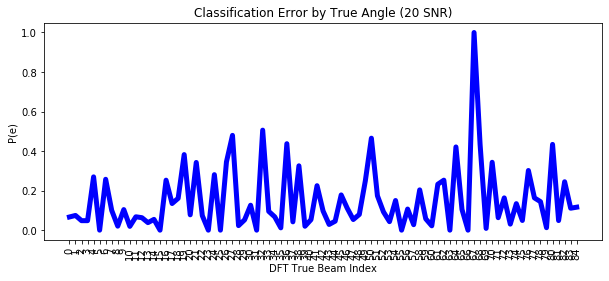

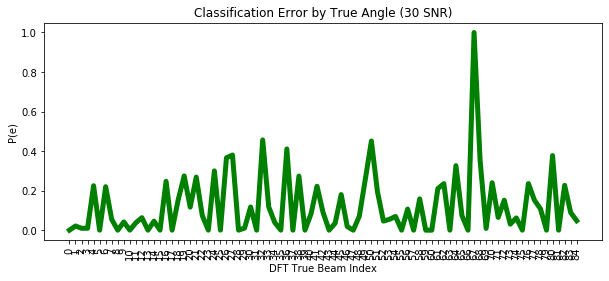

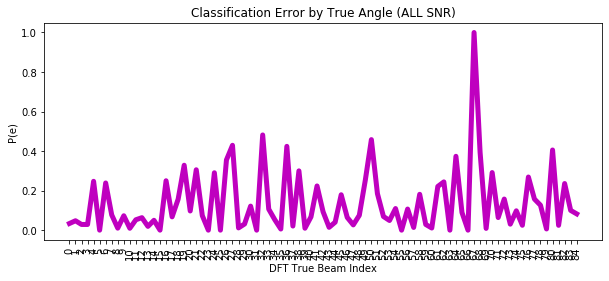

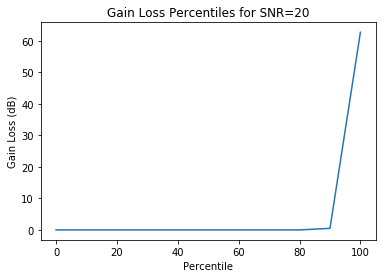

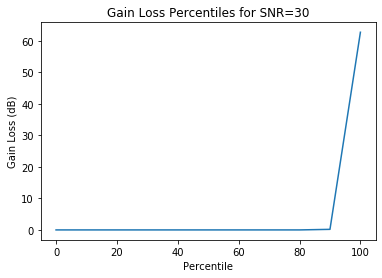

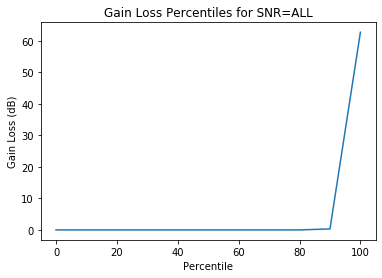

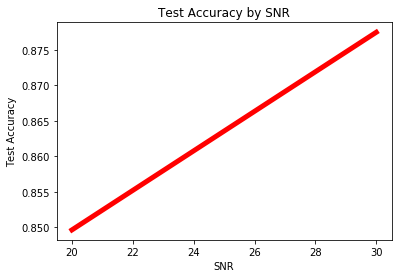

In [31]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim{}_{}meas_{}SNR.png'.format(NN_NUM, NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 7 Measurements


Training model for PN combo 0...
Train on 3400 samples
Epoch 1/75
3400/3400 [==============================] - 2s 643us/sample - loss: 2.7225 - sparse_categorical_accuracy: 0.3785
Epoch 2/75
3400/3400 [==============================] - 2s 454us/sample - loss: 1.6765 - sparse_categorical_accuracy: 0.6176
Epoch 3/75
3400/3400 [==============================] - 2s 459us/sample - loss: 1.3737 - sparse_categorical_accuracy: 0.6688
Epoch 4/75
3400/3400 [==============================] - 2s 443us/sample - loss: 1.2383 - sparse_categorical_accuracy: 0.6862
Epoch 5/75
3400/3400 [==============================] - 2s 445us/sample - loss: 1.0699 - sparse_categorical_accuracy: 0.7294
Epoch 6/75
3400/3400 [==============================] - 2s 445us/sample - loss: 0.9875 - sparse_categorical_accuracy: 0.7374
Epoch 7/75
3400/3400 [==============================] - 2s 445us/sample - loss: 0.8940 - sparse_categorical_accuracy: 0.7588
Epoch 8/75
3400/3400 [==============================] - 2s 444us/samp

Text(0.5, 0, 'Epoch')

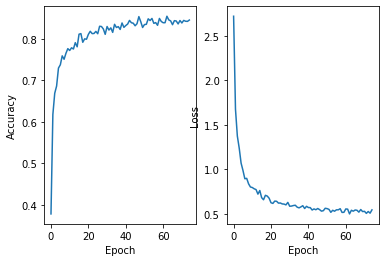

In [34]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
20 dB SNR --
(8300, 85)
	labels:      (0, 84)
	predictions: (0, 84)
8300/8300 - 0s - loss: 0.6204 - sparse_categorical_accuracy: 0.8528
	Test accuracy: 0.8527711


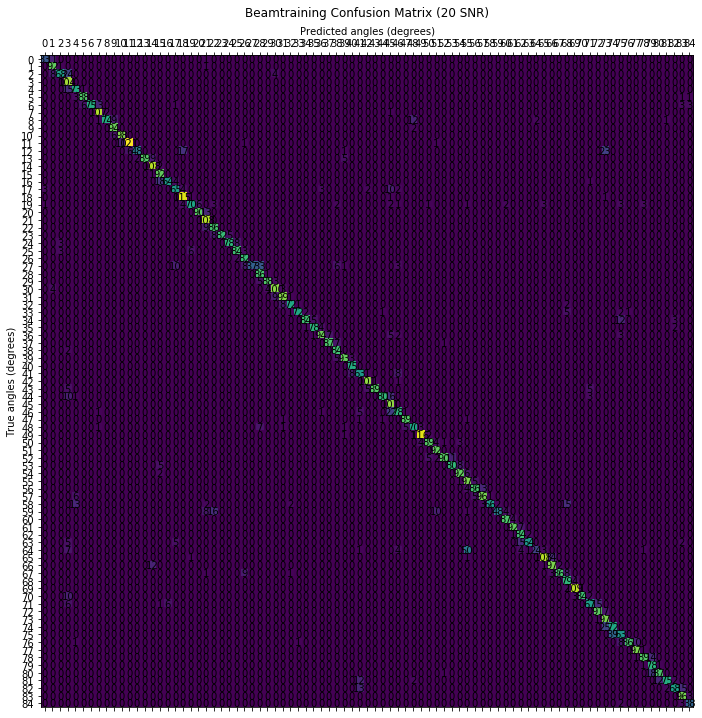

30 dB SNR --
(8300, 85)
	labels:      (0, 84)
	predictions: (0, 84)
8300/8300 - 0s - loss: 0.4415 - sparse_categorical_accuracy: 0.8942
	Test accuracy: 0.8942169


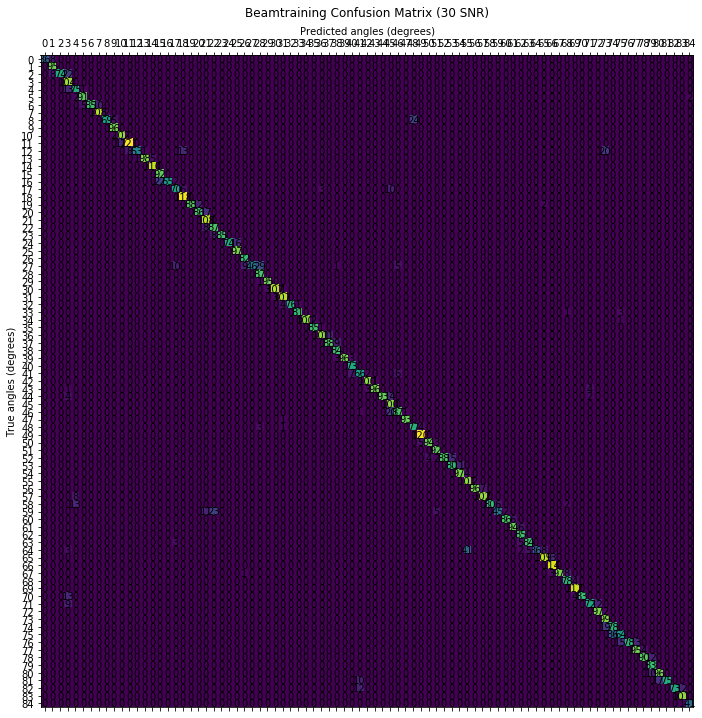

ALL SNR values --
(16600, 85)
	labels:      (0, 84)
	predictions: (0, 84)
16600/16600 - 1s - loss: 0.5310 - sparse_categorical_accuracy: 0.8735
	Test accuracy: 0.87349397


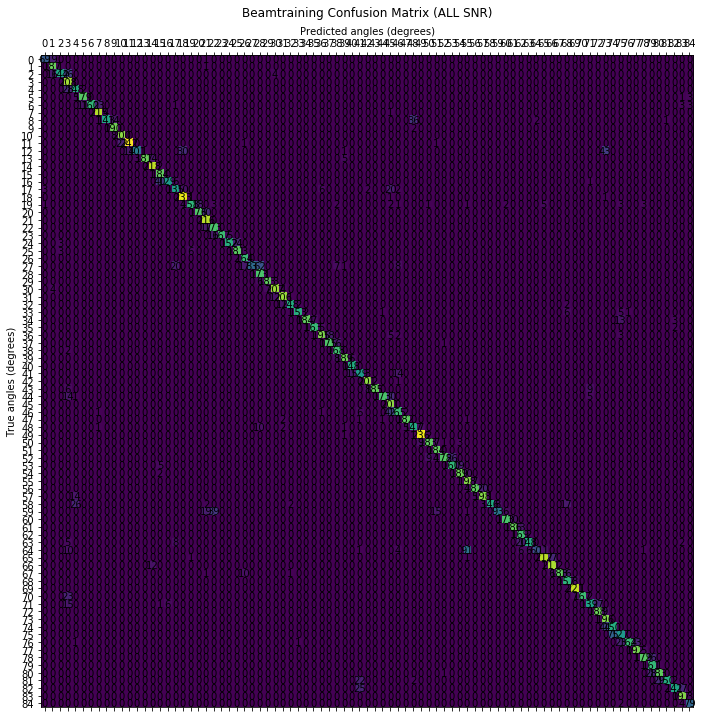


Number of results:            (1, 3)
Confusion matrix tensor size: (1, 3, 85, 85)
20 dB SNR --
30 dB SNR --
20 dB SNR --
Gain Loss Percentiles, SNR 20
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.434]
 [100.     59.524]]
30 dB SNR --
Gain Loss Percentiles, SNR 30
[[0.0000e+00 0.0000e+00]
 [1.0000e+01 0.0000e+00]
 [2.0000e+01 0.0000e+00]
 [3.0000e+01 0.0000e+00]
 [4.0000e+01 0.0000e+00]
 [5.0000e+01 0.0000e+00]
 [6.0000e+01 0.0000e+00]
 [7.0000e+01 0.0000e+00]
 [8.0000e+01 0.0000e+00]
 [9.0000e+01 4.6000e-02]
 [1.0000e+02 7.0057e+01]]
ALL SNR values --
Gain Loss Percentiles, SNR ALL
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.225]
 [100.     70.057]]

Average Test Accuracies: 
	SNR: 20; Accuracy: 0.85277110338

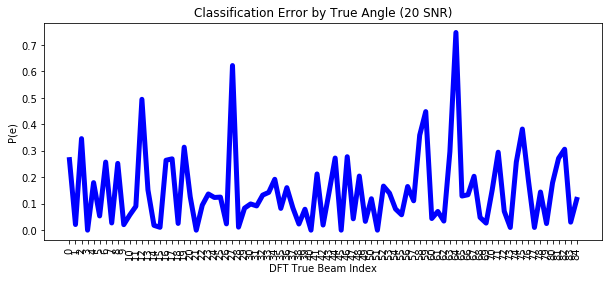

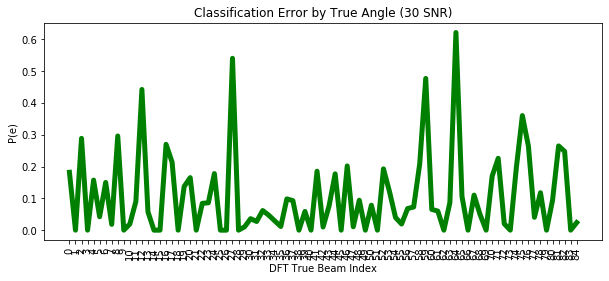

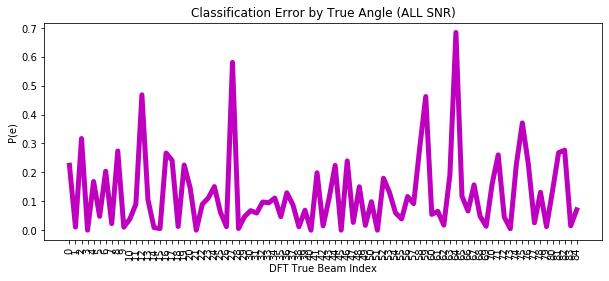

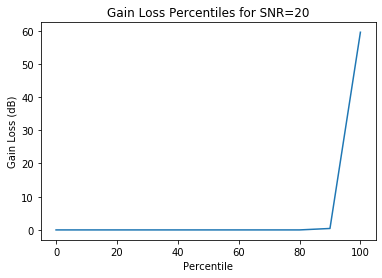

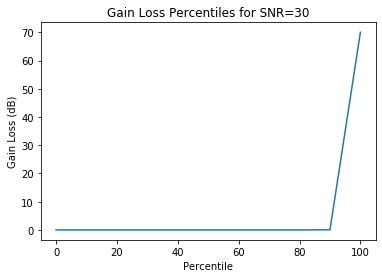

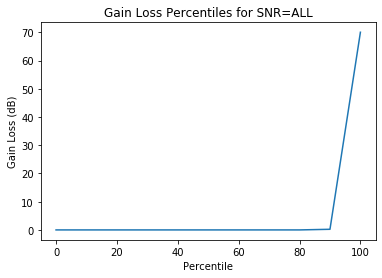

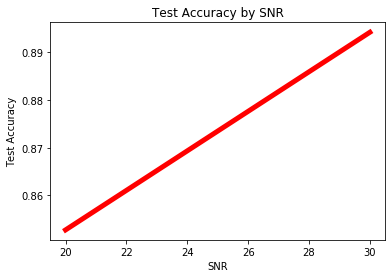

In [35]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim{}_{}meas_{}SNR.png'.format(NN_NUM, NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 6 Measurements


Training model for PN combo 0...
Train on 3400 samples
Epoch 1/75
3400/3400 [==============================] - 2s 734us/sample - loss: 3.0714 - sparse_categorical_accuracy: 0.2729
Epoch 2/75
3400/3400 [==============================] - 2s 507us/sample - loss: 2.3755 - sparse_categorical_accuracy: 0.4165
Epoch 3/75
3400/3400 [==============================] - 2s 520us/sample - loss: 2.0920 - sparse_categorical_accuracy: 0.4841
Epoch 4/75
3400/3400 [==============================] - 2s 503us/sample - loss: 1.8979 - sparse_categorical_accuracy: 0.5374
Epoch 5/75
3400/3400 [==============================] - 2s 505us/sample - loss: 1.7225 - sparse_categorical_accuracy: 0.5674
Epoch 6/75
3400/3400 [==============================] - 2s 505us/sample - loss: 1.6656 - sparse_categorical_accuracy: 0.5735
Epoch 7/75
3400/3400 [==============================] - 2s 505us/sample - loss: 1.6339 - sparse_categorical_accuracy: 0.5712
Epoch 8/75
3400/3400 [==============================] - 2s 512us/samp

Text(0.5, 0, 'Epoch')

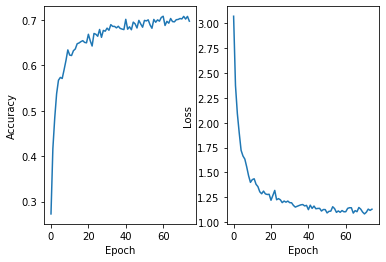

In [38]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
20 dB SNR --
(8300, 85)
	labels:      (0, 84)
	predictions: (0, 84)
8300/8300 - 0s - loss: 2.0201 - sparse_categorical_accuracy: 0.6747
	Test accuracy: 0.67469877


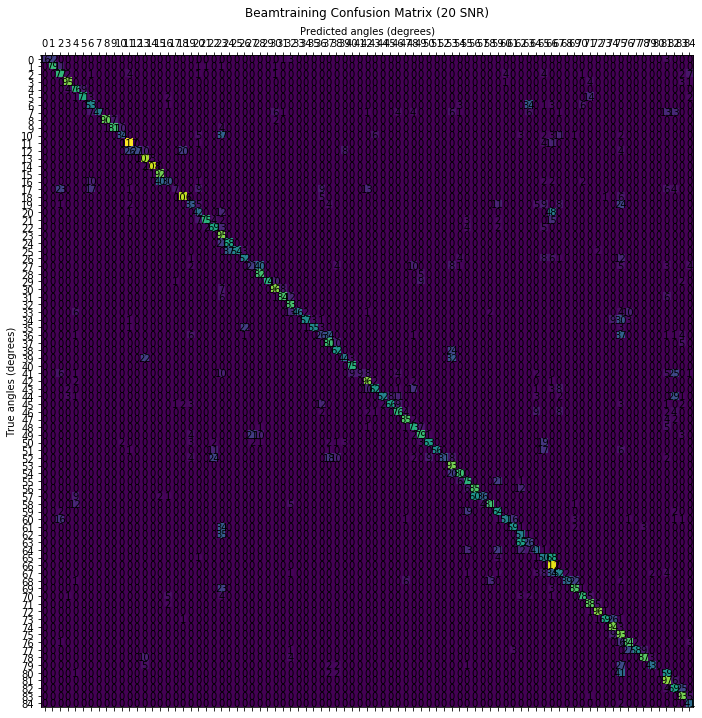

30 dB SNR --
(8300, 85)
	labels:      (0, 84)
	predictions: (0, 84)
8300/8300 - 0s - loss: 1.6939 - sparse_categorical_accuracy: 0.7254
	Test accuracy: 0.72542167


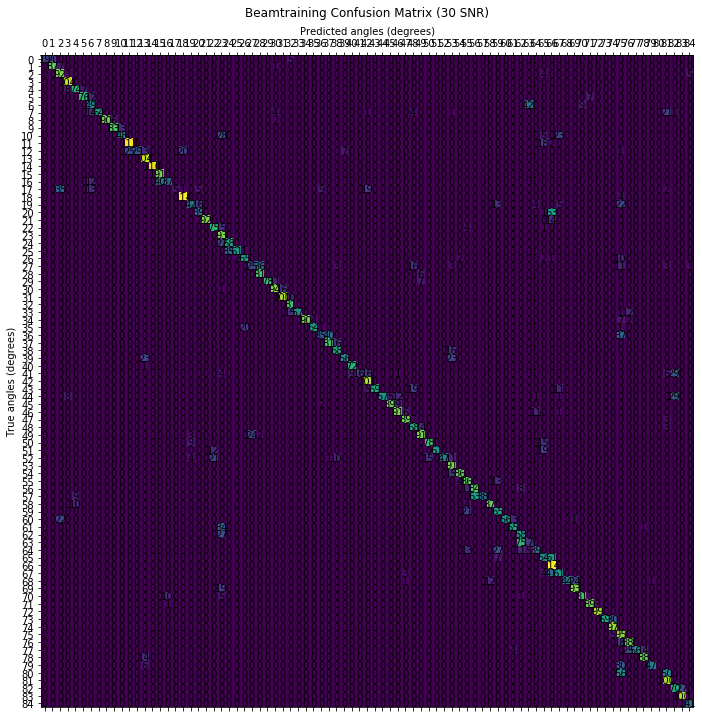

ALL SNR values --
(16600, 85)
	labels:      (0, 84)
	predictions: (0, 84)
16600/16600 - 1s - loss: 1.8570 - sparse_categorical_accuracy: 0.7001
	Test accuracy: 0.70006025


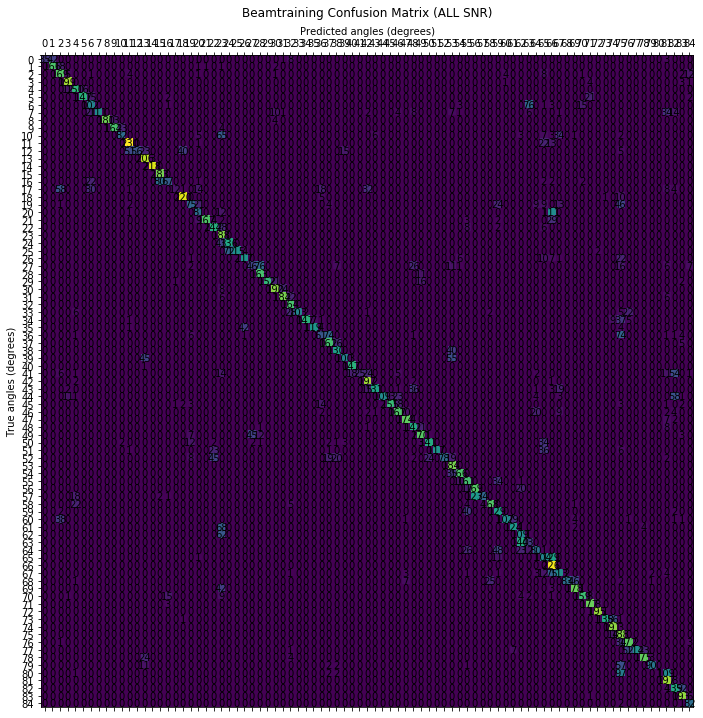


Number of results:            (1, 3)
Confusion matrix tensor size: (1, 3, 85, 85)
20 dB SNR --
30 dB SNR --
20 dB SNR --
Gain Loss Percentiles, SNR 20
[[  0.       0.    ]
 [ 10.       0.    ]
 [ 20.       0.    ]
 [ 30.       0.    ]
 [ 40.       0.    ]
 [ 50.       0.    ]
 [ 60.       0.    ]
 [ 70.       0.263 ]
 [ 80.      14.8091]
 [ 90.      33.07  ]
 [100.      64.528 ]]
30 dB SNR --
Gain Loss Percentiles, SNR 30
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      1.016]
 [ 90.     33.068]
 [100.     67.086]]
ALL SNR values --
Gain Loss Percentiles, SNR ALL
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      2.085]
 [ 90.     33.07 ]
 [100.     67.086]]

Average Test Accuracies: 
	SNR: 20; Accuracy: 0.6746987700462341
	SNR: 30; Accuracy: 0.725421667098999


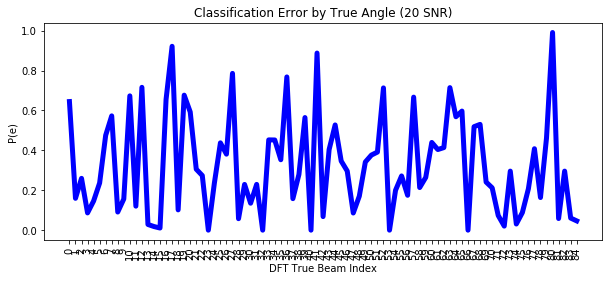

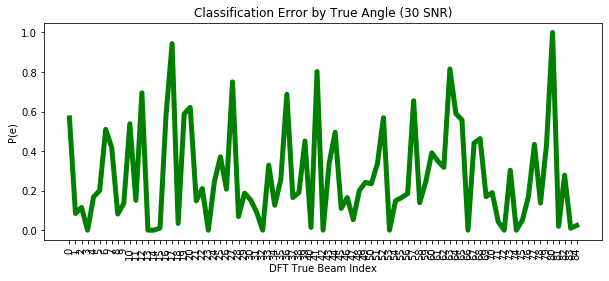

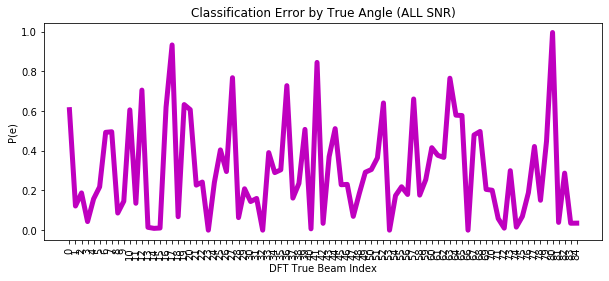

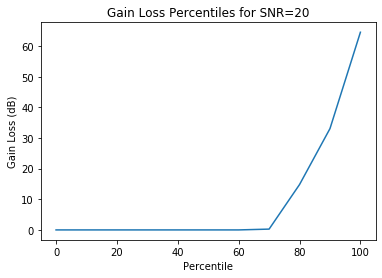

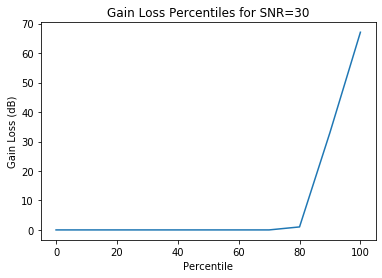

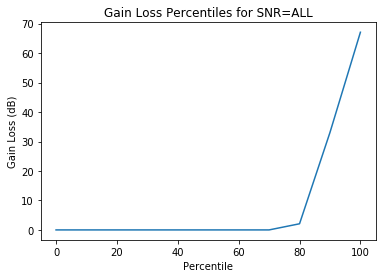

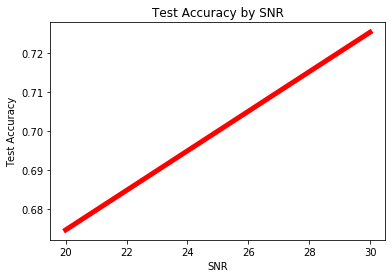

In [39]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim{}_{}meas_{}SNR.png'.format(NN_NUM, NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

# Nr = 72, 20 measurements per label and SNR
- Requires M = 8 (max 1 dB gain loss for the combined SNRs at the 90th percentile)
- Requires M = 7 (max 2 dB gain loss for the combined SNRs at the 90th percentile)
- Note: strong overfitting with the same 75 epoch training with M=6; Re-run with 40 epochs to remove overfitting.  Significantly better performance but not enough to meet requirements.

### NN for 9 Measurements


Training model for PN combo 0...
Train on 4040 samples
Epoch 1/75
4040/4040 [==============================] - 2s 515us/sample - loss: 2.5661 - sparse_categorical_accuracy: 0.4715
Epoch 2/75
4040/4040 [==============================] - 1s 357us/sample - loss: 1.2647 - sparse_categorical_accuracy: 0.7510
Epoch 3/75
4040/4040 [==============================] - 1s 354us/sample - loss: 0.9017 - sparse_categorical_accuracy: 0.8022
Epoch 4/75
4040/4040 [==============================] - 1s 351us/sample - loss: 0.7194 - sparse_categorical_accuracy: 0.8319
Epoch 5/75
4040/4040 [==============================] - 1s 351us/sample - loss: 0.6251 - sparse_categorical_accuracy: 0.8463
Epoch 6/75
4040/4040 [==============================] - 1s 352us/sample - loss: 0.5997 - sparse_categorical_accuracy: 0.8478
Epoch 7/75
4040/4040 [==============================] - 1s 349us/sample - loss: 0.5577 - sparse_categorical_accuracy: 0.8502
Epoch 8/75
4040/4040 [==============================] - 1s 349us/samp

Text(0.5, 0, 'Epoch')

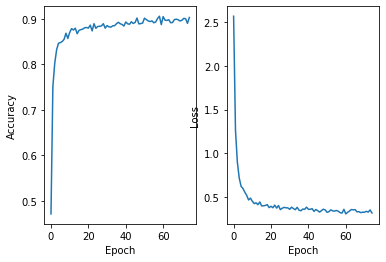

In [42]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
20 dB SNR --
(7980, 101)
	labels:      (0, 100)
	predictions: (0, 100)
7980/7980 - 0s - loss: 0.3096 - sparse_categorical_accuracy: 0.9010
	Test accuracy: 0.9010025


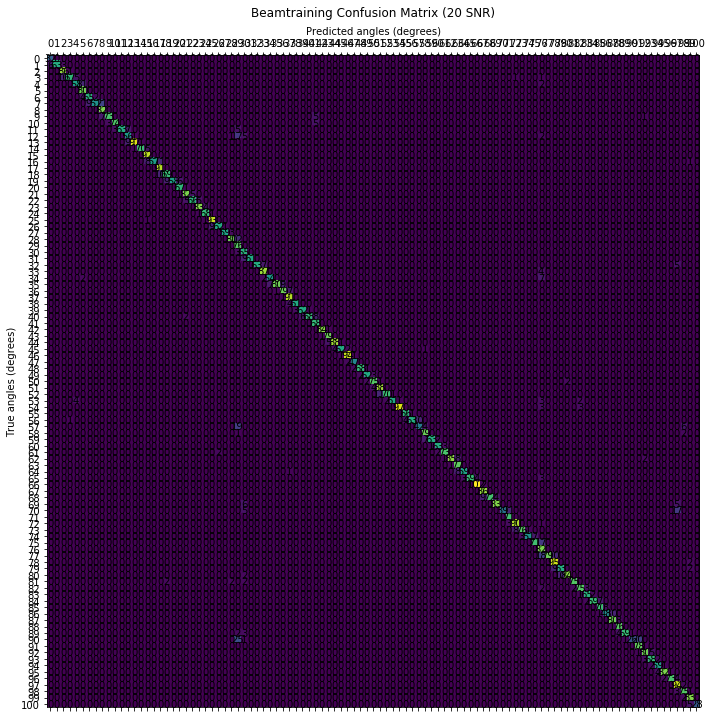

30 dB SNR --
(7980, 101)
	labels:      (0, 100)
	predictions: (0, 100)
7980/7980 - 0s - loss: 0.2373 - sparse_categorical_accuracy: 0.9273
	Test accuracy: 0.9273183


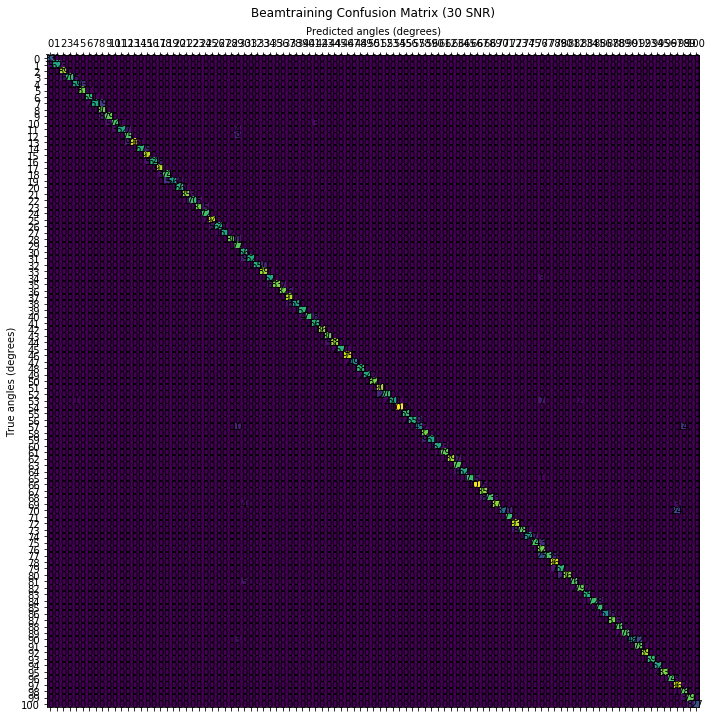

ALL SNR values --
(15960, 101)
	labels:      (0, 100)
	predictions: (0, 100)
15960/15960 - 1s - loss: 0.2734 - sparse_categorical_accuracy: 0.9142
	Test accuracy: 0.91416043


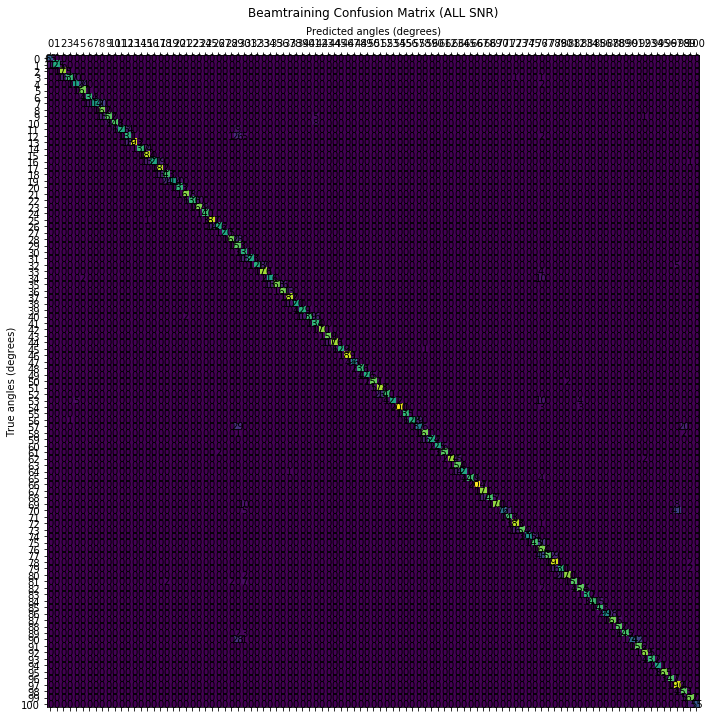


Number of results:            (1, 3)
Confusion matrix tensor size: (1, 3, 101, 101)
20 dB SNR --
30 dB SNR --
20 dB SNR --
Gain Loss Percentiles, SNR 20
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.   ]
 [100.     62.192]]
30 dB SNR --
Gain Loss Percentiles, SNR 30
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.   ]
 [100.     46.201]]
ALL SNR values --
Gain Loss Percentiles, SNR ALL
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.   ]
 [100.     62.192]]

Average Test Accuracies: 
	SNR: 20; Accuracy: 0.9010025262832642
	SNR: 30; Accuracy: 0.927318274974823


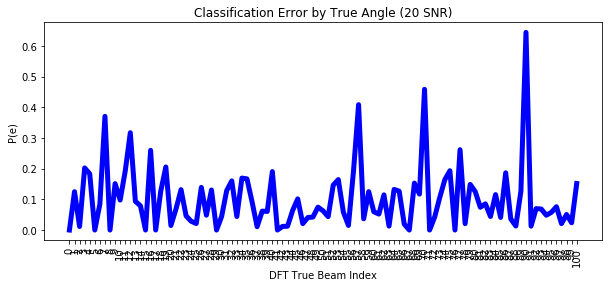

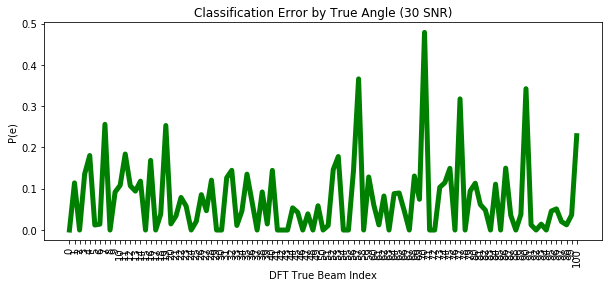

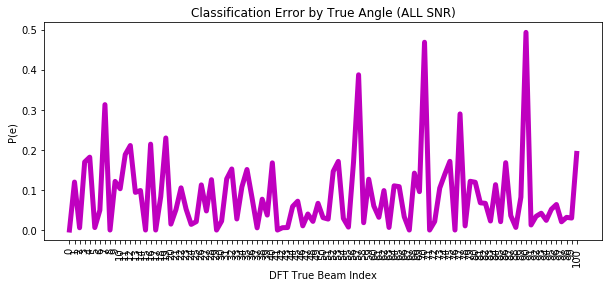

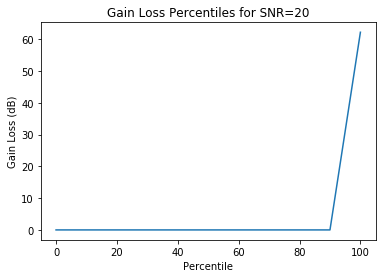

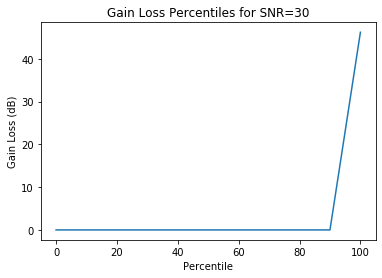

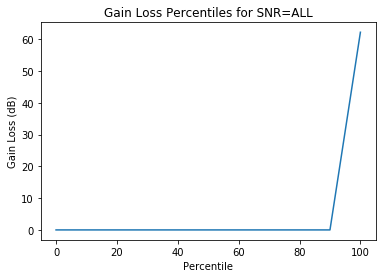

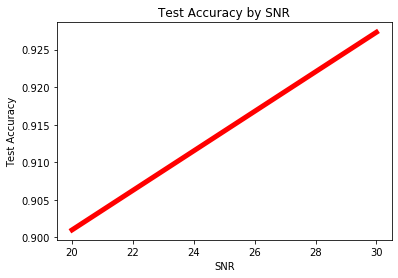

In [43]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim{}_{}meas_{}SNR.png'.format(NN_NUM, NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 8 Measurements


Training model for PN combo 0...
Train on 4040 samples
Epoch 1/75
4040/4040 [==============================] - 2s 526us/sample - loss: 2.7010 - sparse_categorical_accuracy: 0.4223
Epoch 2/75
4040/4040 [==============================] - 1s 289us/sample - loss: 1.5691 - sparse_categorical_accuracy: 0.6656
Epoch 3/75
4040/4040 [==============================] - 1s 291us/sample - loss: 1.1995 - sparse_categorical_accuracy: 0.7396
Epoch 4/75
4040/4040 [==============================] - 1s 289us/sample - loss: 0.9770 - sparse_categorical_accuracy: 0.7683
Epoch 5/75
4040/4040 [==============================] - 1s 308us/sample - loss: 0.8799 - sparse_categorical_accuracy: 0.7795
Epoch 6/75
4040/4040 [==============================] - 1s 292us/sample - loss: 0.7635 - sparse_categorical_accuracy: 0.8040
Epoch 7/75
4040/4040 [==============================] - 1s 295us/sample - loss: 0.7231 - sparse_categorical_accuracy: 0.8104
Epoch 8/75
4040/4040 [==============================] - 1s 292us/samp

Text(0.5, 0, 'Epoch')

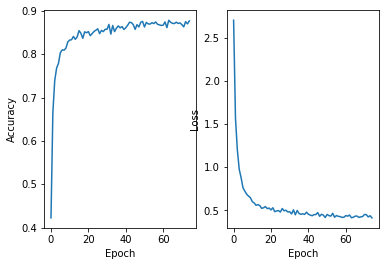

In [46]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
20 dB SNR --
(7980, 101)
	labels:      (0, 100)
	predictions: (0, 100)
7980/7980 - 0s - loss: 0.5288 - sparse_categorical_accuracy: 0.8675
	Test accuracy: 0.8675439


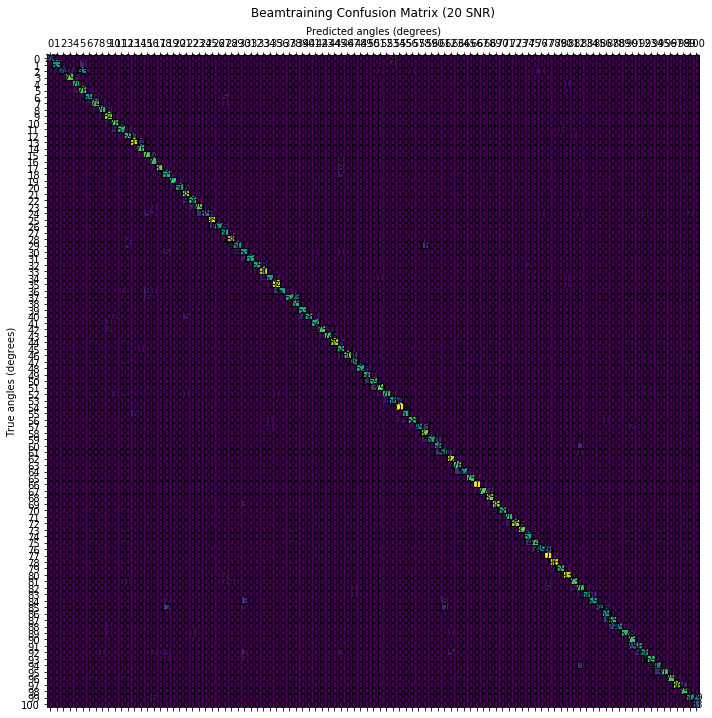

30 dB SNR --
(7980, 101)
	labels:      (0, 100)
	predictions: (0, 100)
7980/7980 - 0s - loss: 0.3902 - sparse_categorical_accuracy: 0.8980
	Test accuracy: 0.897995


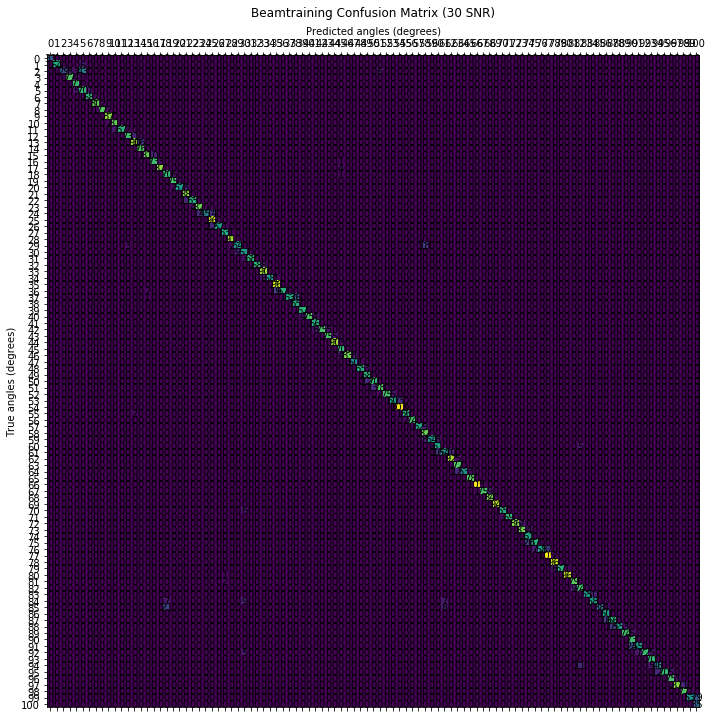

ALL SNR values --
(15960, 101)
	labels:      (0, 100)
	predictions: (0, 100)
15960/15960 - 1s - loss: 0.4595 - sparse_categorical_accuracy: 0.8828
	Test accuracy: 0.8827694


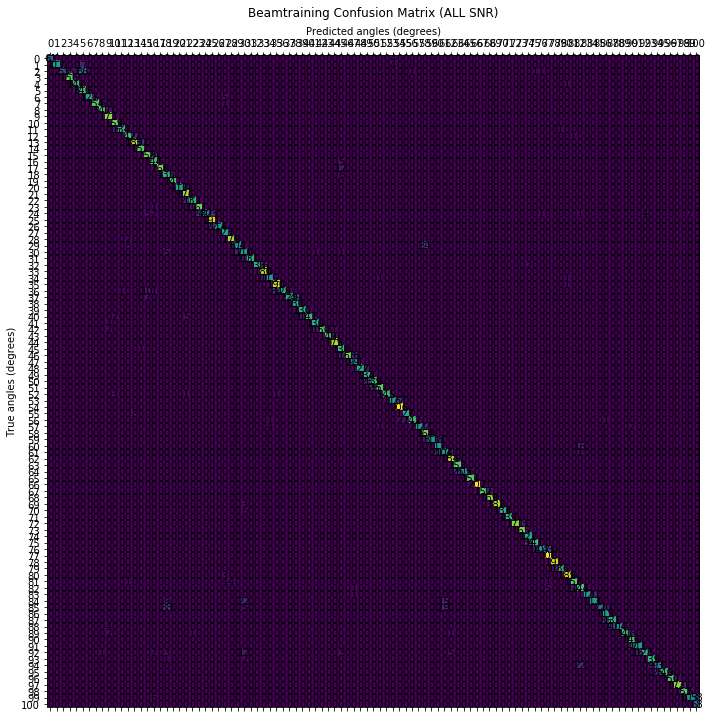


Number of results:            (1, 3)
Confusion matrix tensor size: (1, 3, 101, 101)
20 dB SNR --
30 dB SNR --
20 dB SNR --
Gain Loss Percentiles, SNR 20
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.252]
 [100.     56.298]]
30 dB SNR --
Gain Loss Percentiles, SNR 30
[[0.0000e+00 0.0000e+00]
 [1.0000e+01 0.0000e+00]
 [2.0000e+01 0.0000e+00]
 [3.0000e+01 0.0000e+00]
 [4.0000e+01 0.0000e+00]
 [5.0000e+01 0.0000e+00]
 [6.0000e+01 0.0000e+00]
 [7.0000e+01 0.0000e+00]
 [8.0000e+01 0.0000e+00]
 [9.0000e+01 8.0000e-03]
 [1.0000e+02 6.3203e+01]]
ALL SNR values --
Gain Loss Percentiles, SNR ALL
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.12 ]
 [100.     63.203]]

Average Test Accuracies: 
	SNR: 20; Accuracy: 0.867543876

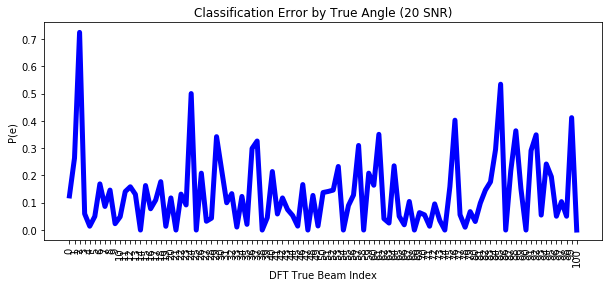

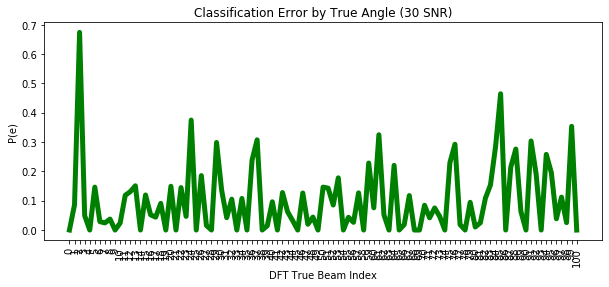

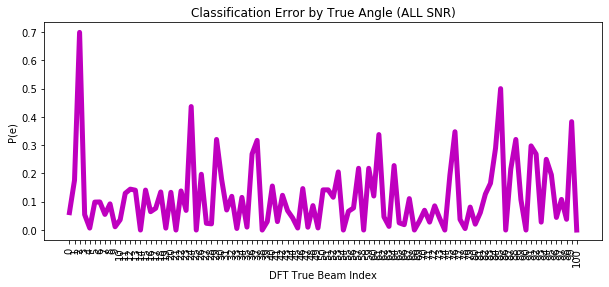

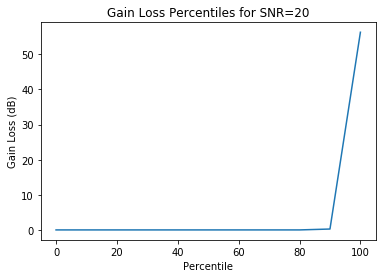

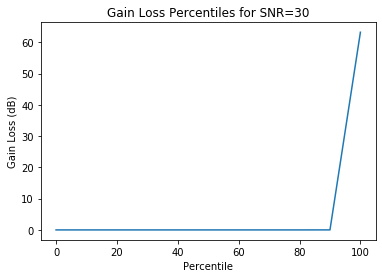

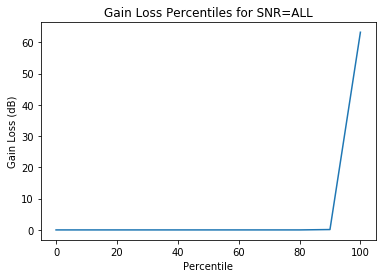

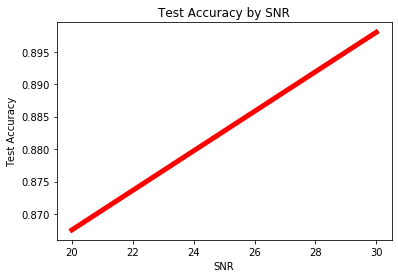

In [47]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim{}_{}meas_{}SNR.png'.format(NN_NUM, NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 7 Measurements


Training model for PN combo 0...
Train on 4040 samples
Epoch 1/75
4040/4040 [==============================] - 2s 601us/sample - loss: 2.9491 - sparse_categorical_accuracy: 0.3329
Epoch 2/75
4040/4040 [==============================] - 2s 440us/sample - loss: 2.0176 - sparse_categorical_accuracy: 0.5483
Epoch 3/75
4040/4040 [==============================] - 2s 447us/sample - loss: 1.6189 - sparse_categorical_accuracy: 0.6287
Epoch 4/75
4040/4040 [==============================] - 2s 442us/sample - loss: 1.3474 - sparse_categorical_accuracy: 0.6792
Epoch 5/75
4040/4040 [==============================] - 2s 439us/sample - loss: 1.1926 - sparse_categorical_accuracy: 0.7101
Epoch 6/75
4040/4040 [==============================] - 2s 440us/sample - loss: 1.0945 - sparse_categorical_accuracy: 0.7290
Epoch 7/75
4040/4040 [==============================] - 2s 438us/sample - loss: 1.0443 - sparse_categorical_accuracy: 0.7374
Epoch 8/75
4040/4040 [==============================] - 2s 437us/samp

Text(0.5, 0, 'Epoch')

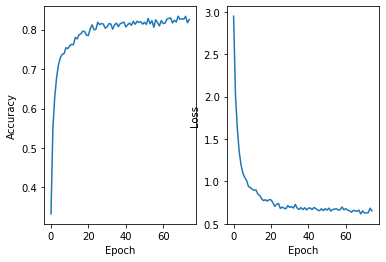

In [50]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
20 dB SNR --
(7980, 101)
	labels:      (0, 100)
	predictions: (0, 100)
7980/7980 - 0s - loss: 1.0917 - sparse_categorical_accuracy: 0.7915
	Test accuracy: 0.7914787


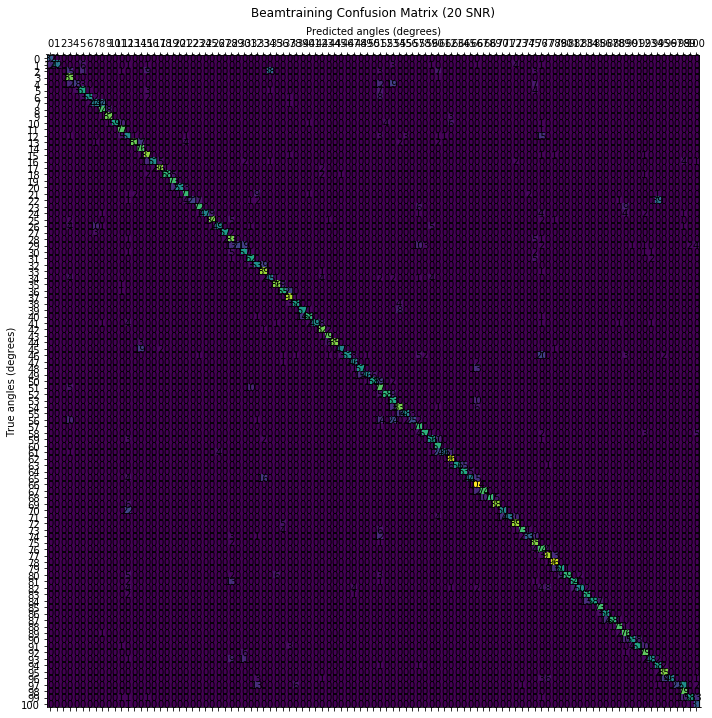

30 dB SNR --
(7980, 101)
	labels:      (0, 100)
	predictions: (0, 100)
7980/7980 - 0s - loss: 0.8509 - sparse_categorical_accuracy: 0.8366
	Test accuracy: 0.8365915


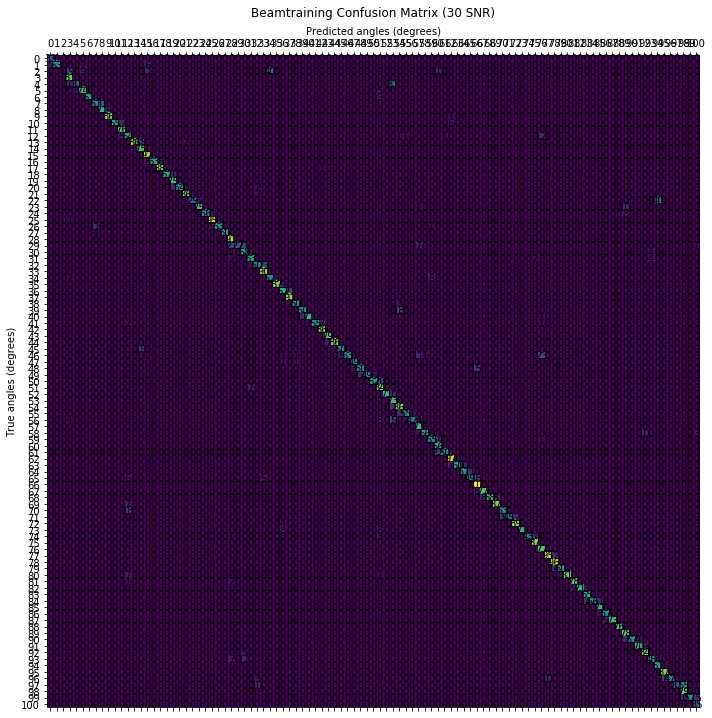

ALL SNR values --
(15960, 101)
	labels:      (0, 100)
	predictions: (0, 100)
15960/15960 - 1s - loss: 0.9713 - sparse_categorical_accuracy: 0.8140
	Test accuracy: 0.81403506


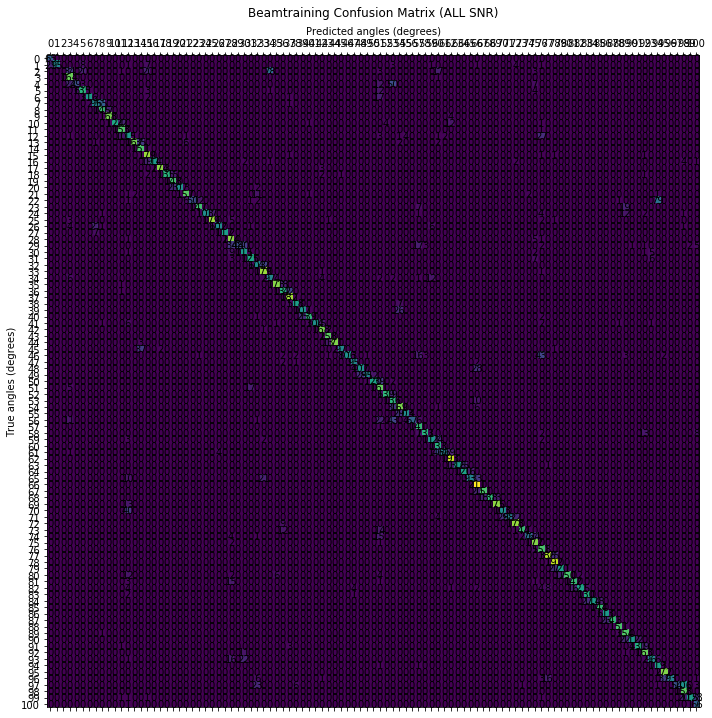


Number of results:            (1, 3)
Confusion matrix tensor size: (1, 3, 101, 101)
20 dB SNR --
30 dB SNR --
20 dB SNR --
Gain Loss Percentiles, SNR 20
[[0.00000e+00 0.00000e+00]
 [1.00000e+01 0.00000e+00]
 [2.00000e+01 0.00000e+00]
 [3.00000e+01 0.00000e+00]
 [4.00000e+01 0.00000e+00]
 [5.00000e+01 0.00000e+00]
 [6.00000e+01 0.00000e+00]
 [7.00000e+01 0.00000e+00]
 [8.00000e+01 7.10000e-02]
 [9.00000e+01 1.45971e+01]
 [1.00000e+02 6.80210e+01]]
30 dB SNR --
Gain Loss Percentiles, SNR 30
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.64 ]
 [100.     64.756]]
ALL SNR values --
Gain Loss Percentiles, SNR ALL
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      1.217]
 [100.     68.021]]

Average Test Accuracies: 
	SNR: 20;

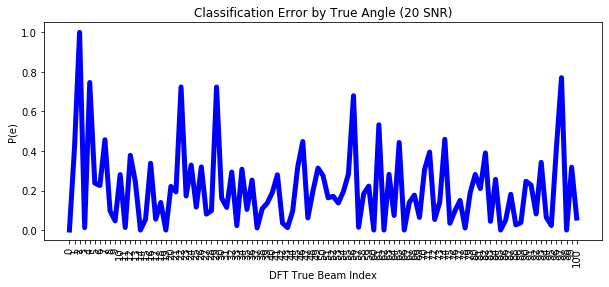

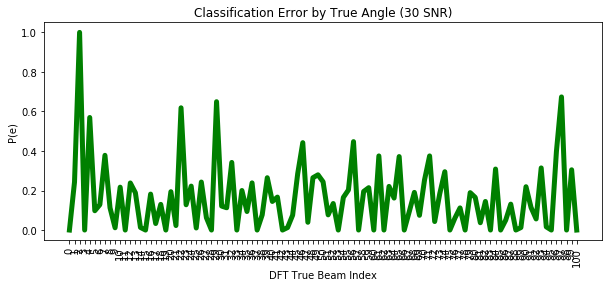

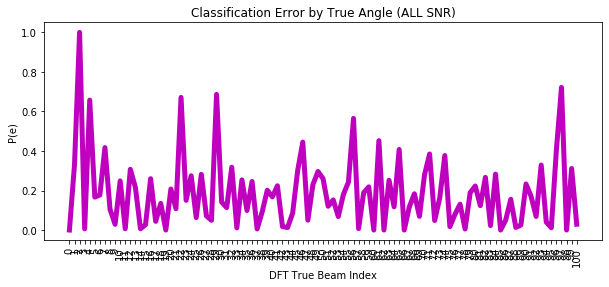

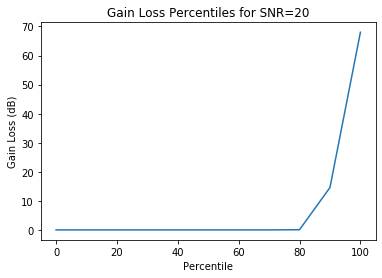

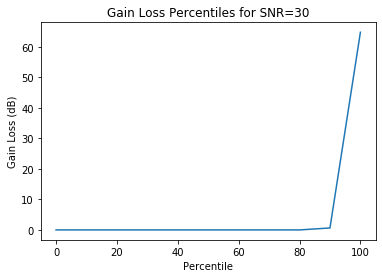

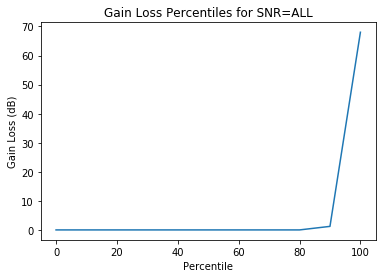

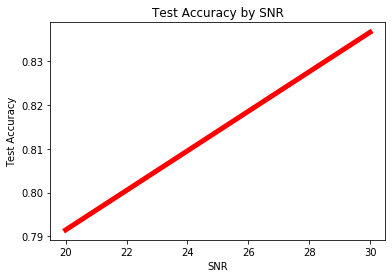

In [51]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim{}_{}meas_{}SNR.png'.format(NN_NUM, NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 6 Measurements


Training model for PN combo 0...
Train on 4040 samples
Epoch 1/40
4040/4040 [==============================] - 3s 704us/sample - loss: 3.2794 - sparse_categorical_accuracy: 0.2545
Epoch 2/40
4040/4040 [==============================] - 2s 551us/sample - loss: 2.5982 - sparse_categorical_accuracy: 0.4045
Epoch 3/40
4040/4040 [==============================] - 2s 523us/sample - loss: 2.2721 - sparse_categorical_accuracy: 0.4688
Epoch 4/40
4040/4040 [==============================] - 2s 530us/sample - loss: 2.0139 - sparse_categorical_accuracy: 0.5188
Epoch 5/40
4040/4040 [==============================] - 2s 503us/sample - loss: 1.8729 - sparse_categorical_accuracy: 0.5475
Epoch 6/40
4040/4040 [==============================] - 2s 502us/sample - loss: 1.7466 - sparse_categorical_accuracy: 0.5740
Epoch 7/40
4040/4040 [==============================] - 2s 498us/sample - loss: 1.6445 - sparse_categorical_accuracy: 0.5839
Epoch 8/40
4040/4040 [==============================] - 2s 498us/samp

Text(0.5, 0, 'Epoch')

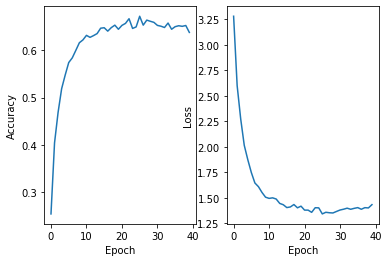

In [56]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 40

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
20 dB SNR --
(7980, 101)
	labels:      (0, 100)
	predictions: (0, 100)
7980/7980 - 0s - loss: 1.9490 - sparse_categorical_accuracy: 0.6267
	Test accuracy: 0.62669176


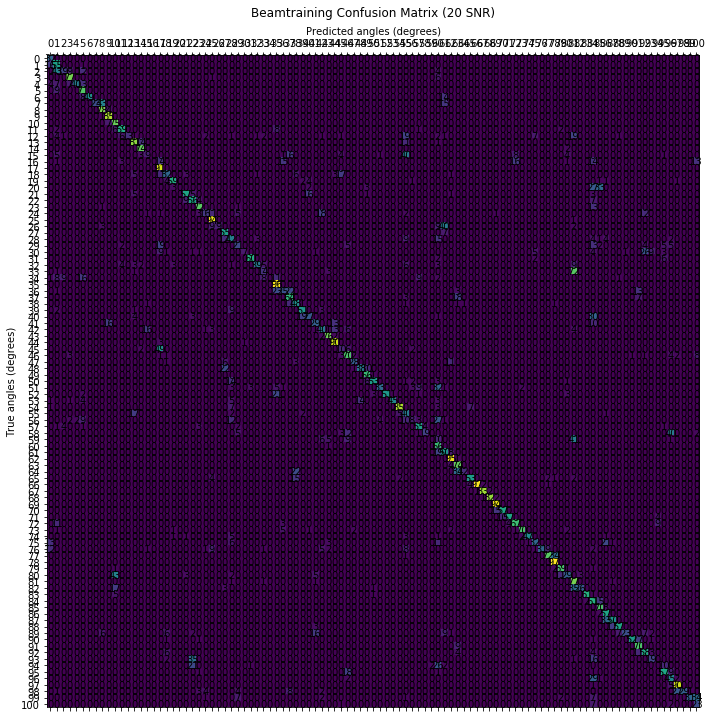

30 dB SNR --
(7980, 101)
	labels:      (0, 100)
	predictions: (0, 100)
7980/7980 - 0s - loss: 1.5893 - sparse_categorical_accuracy: 0.6802
	Test accuracy: 0.6802005


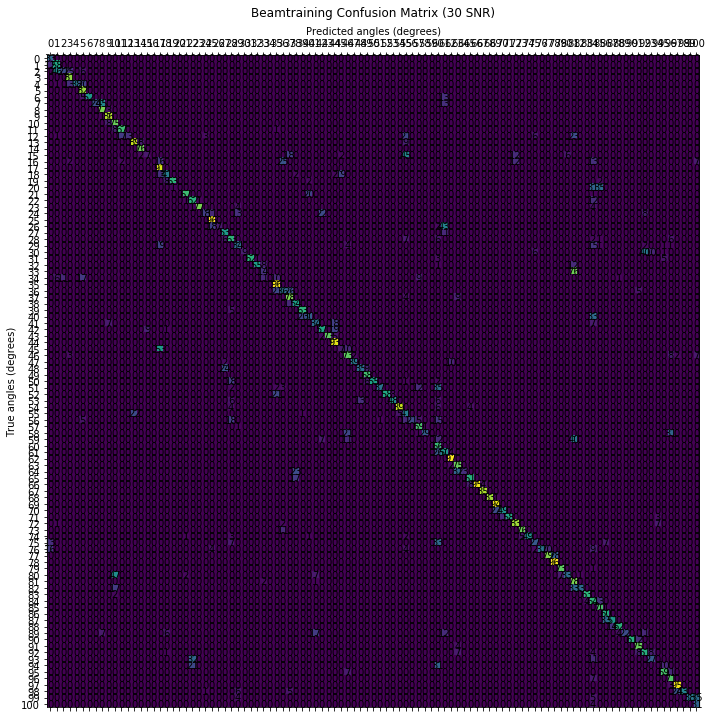

ALL SNR values --
(15960, 101)
	labels:      (0, 100)
	predictions: (0, 100)
15960/15960 - 1s - loss: 1.7692 - sparse_categorical_accuracy: 0.6534
	Test accuracy: 0.65344614


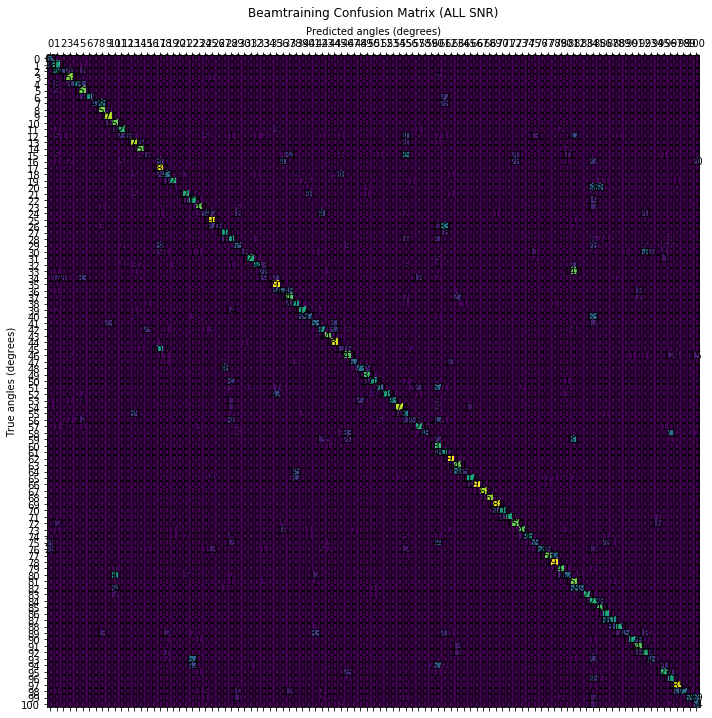


Number of results:            (1, 3)
Confusion matrix tensor size: (1, 3, 101, 101)
20 dB SNR --
30 dB SNR --
20 dB SNR --
Gain Loss Percentiles, SNR 20
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      1.124]
 [ 80.     30.657]
 [ 90.     36.612]
 [100.     79.702]]
30 dB SNR --
Gain Loss Percentiles, SNR 30
[[  0.       0.    ]
 [ 10.       0.    ]
 [ 20.       0.    ]
 [ 30.       0.    ]
 [ 40.       0.    ]
 [ 50.       0.    ]
 [ 60.       0.    ]
 [ 70.       0.184 ]
 [ 80.      22.3066]
 [ 90.      37.848 ]
 [100.      73.22  ]]
ALL SNR values --
Gain Loss Percentiles, SNR ALL
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.562]
 [ 80.     29.468]
 [ 90.     37.186]
 [100.     79.702]]

Average Test Accuracies: 
	SNR: 20; Accuracy: 0.6266917586326599
	SNR: 30; Accuracy: 0.68020051717758

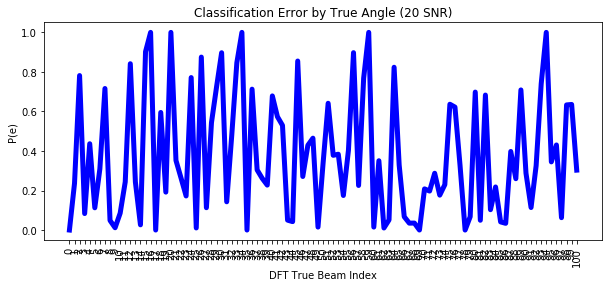

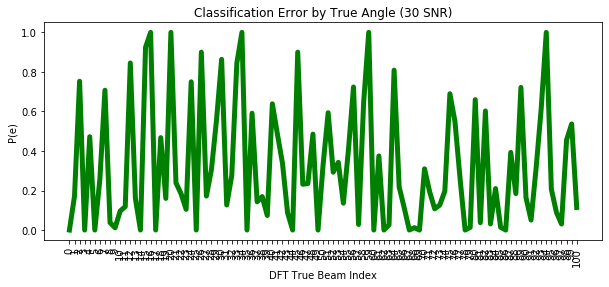

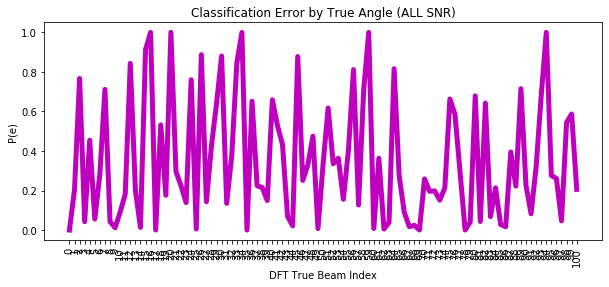

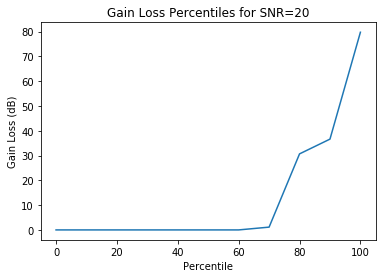

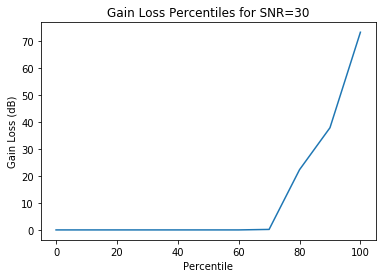

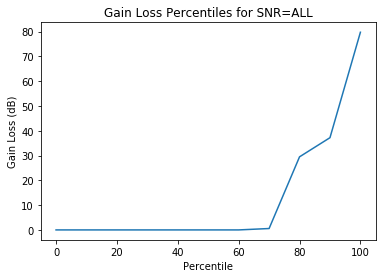

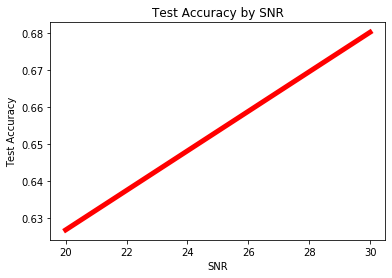

In [57]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim{}_{}meas_{}SNR.png'.format(NN_NUM, NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

# Nr = 24, 20 measurements per label and SNR
- Requires M = 7 (max 1 dB gain loss for the combined SNRs at the 90th percentile)

### NN for 7 Measurements


Training model for PN combo 0...
Train on 1360 samples
Epoch 1/75
1360/1360 [==============================] - 2s 1ms/sample - loss: 1.8281 - sparse_categorical_accuracy: 0.5265
Epoch 2/75
1360/1360 [==============================] - 1s 428us/sample - loss: 0.9024 - sparse_categorical_accuracy: 0.7588
Epoch 3/75
1360/1360 [==============================] - 1s 427us/sample - loss: 0.7160 - sparse_categorical_accuracy: 0.7853
Epoch 4/75
1360/1360 [==============================] - 1s 424us/sample - loss: 0.6671 - sparse_categorical_accuracy: 0.8029
Epoch 5/75
1360/1360 [==============================] - 1s 431us/sample - loss: 0.5930 - sparse_categorical_accuracy: 0.8184
Epoch 6/75
1360/1360 [==============================] - 1s 427us/sample - loss: 0.5396 - sparse_categorical_accuracy: 0.8206
Epoch 7/75
1360/1360 [==============================] - 1s 424us/sample - loss: 0.5770 - sparse_categorical_accuracy: 0.8118
Epoch 8/75
1360/1360 [==============================] - 1s 421us/sample

Text(0.5, 0, 'Epoch')

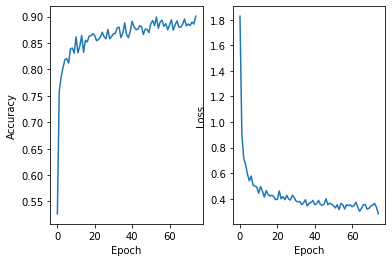

In [4]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
20 dB SNR --
(9320, 34)
	labels:      (0, 33)
	predictions: (0, 33)
9320/9320 - 0s - loss: 0.6013 - sparse_categorical_accuracy: 0.8164
	Test accuracy: 0.8164163


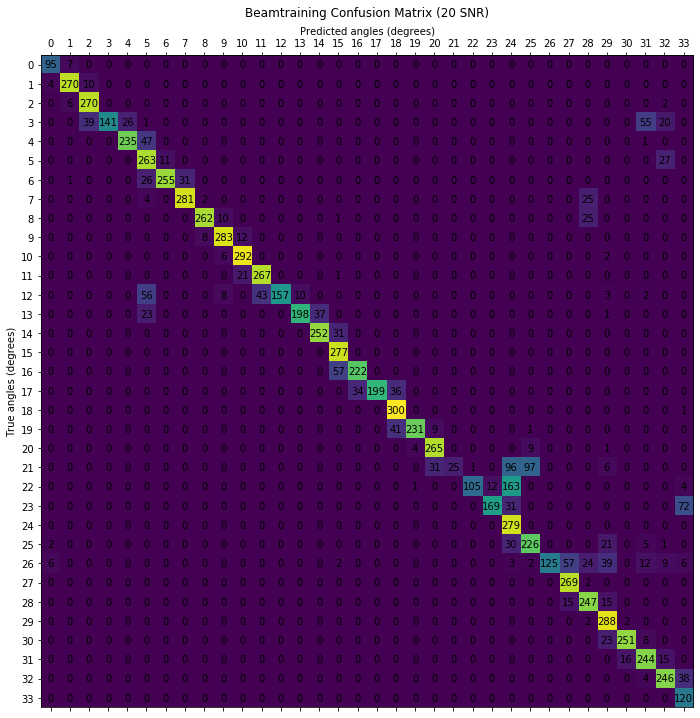

30 dB SNR --
(9320, 34)
	labels:      (0, 33)
	predictions: (0, 33)
9320/9320 - 0s - loss: 0.4744 - sparse_categorical_accuracy: 0.8410
	Test accuracy: 0.84098715


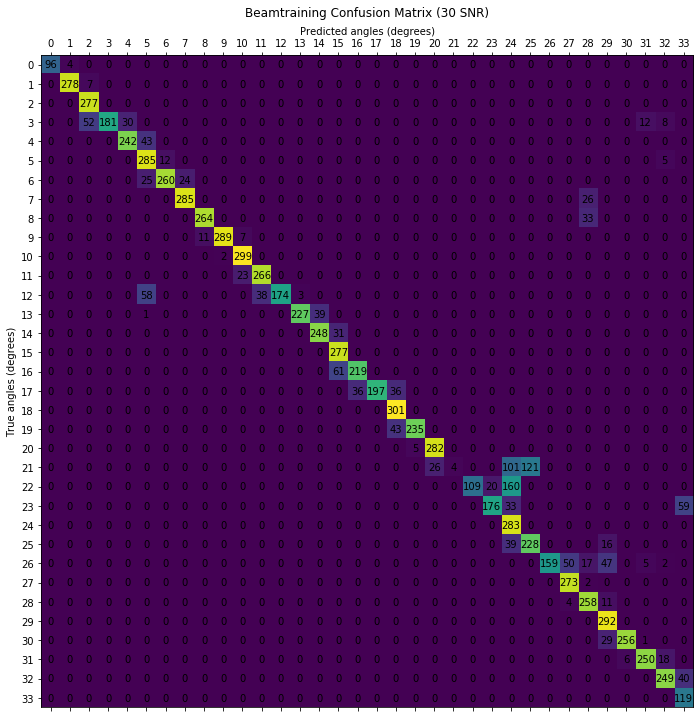

ALL SNR values --
(18640, 34)
	labels:      (0, 33)
	predictions: (0, 33)
18640/18640 - 1s - loss: 0.5379 - sparse_categorical_accuracy: 0.8287
	Test accuracy: 0.82870173


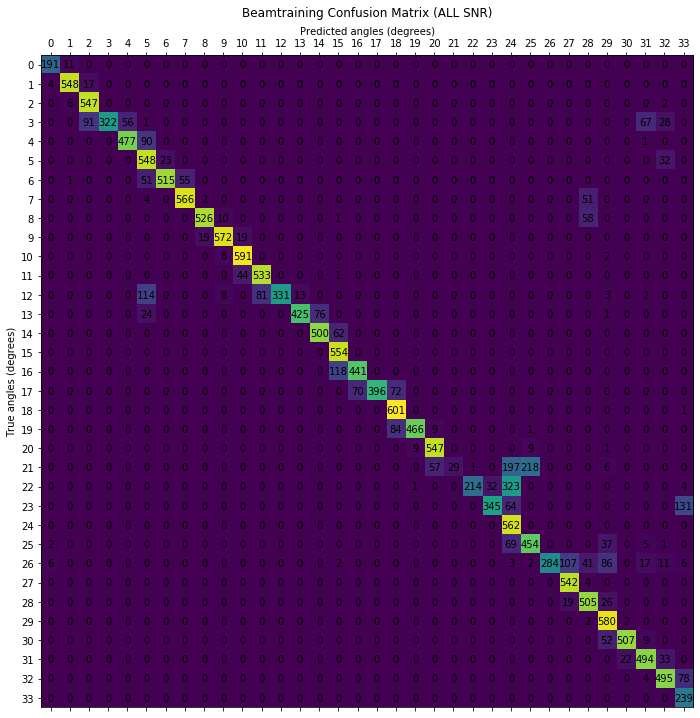


Number of results:            (1, 3)
Confusion matrix tensor size: (1, 3, 34, 34)
20 dB SNR --
30 dB SNR --
20 dB SNR --
Gain Loss Percentiles, SNR 20
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      1.215]
 [100.     46.933]]
30 dB SNR --
Gain Loss Percentiles, SNR 30
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.576]
 [100.     64.638]]
ALL SNR values --
Gain Loss Percentiles, SNR ALL
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.794]
 [100.     64.638]]

Average Test Accuracies: 
	SNR: 20; Accuracy: 0.816416323184967
	SNR: 30; Accuracy: 0.8409871459007263


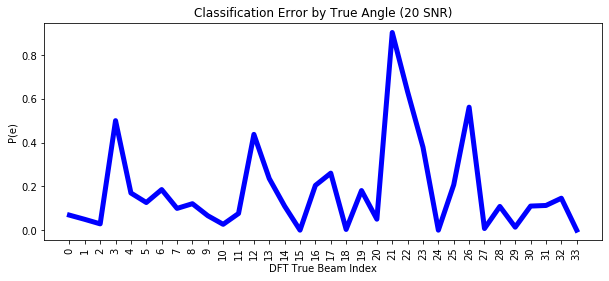

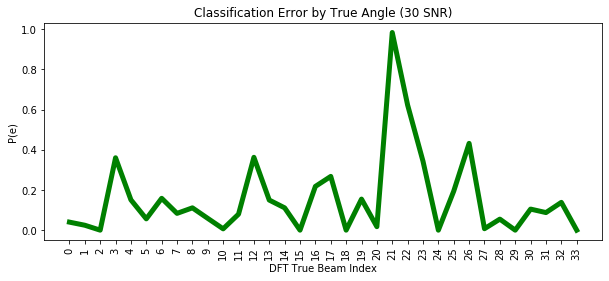

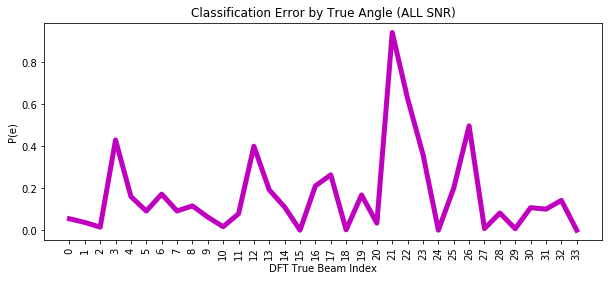

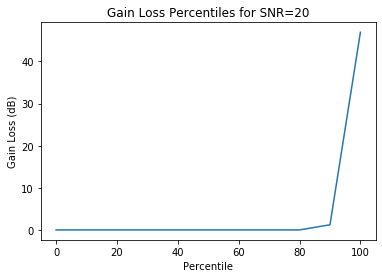

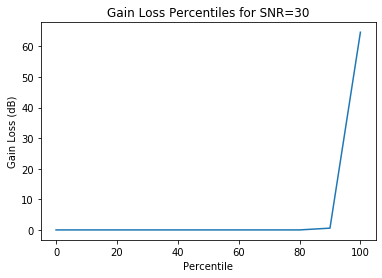

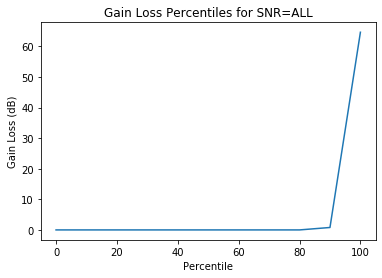

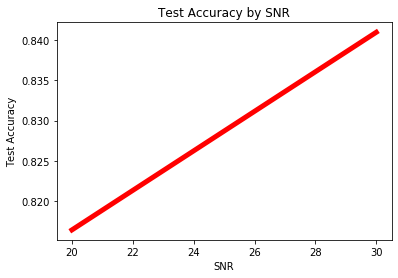

In [8]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim{}_{}meas_{}SNR.png'.format(NN_NUM, NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 6 Measurements


Training model for PN combo 0...
Train on 1360 samples
Epoch 1/75
1360/1360 [==============================] - 1s 1ms/sample - loss: 1.8650 - sparse_categorical_accuracy: 0.4846
Epoch 2/75
1360/1360 [==============================] - 1s 521us/sample - loss: 1.1875 - sparse_categorical_accuracy: 0.6397
Epoch 3/75
1360/1360 [==============================] - 1s 485us/sample - loss: 0.9513 - sparse_categorical_accuracy: 0.7044
Epoch 4/75
1360/1360 [==============================] - 1s 491us/sample - loss: 0.8554 - sparse_categorical_accuracy: 0.7404
Epoch 5/75
1360/1360 [==============================] - 1s 484us/sample - loss: 0.8695 - sparse_categorical_accuracy: 0.7199
Epoch 6/75
1360/1360 [==============================] - 1s 488us/sample - loss: 0.7607 - sparse_categorical_accuracy: 0.7493
Epoch 7/75
1360/1360 [==============================] - 1s 485us/sample - loss: 0.7117 - sparse_categorical_accuracy: 0.7787
Epoch 8/75
1360/1360 [==============================] - 1s 493us/sample

Text(0.5, 0, 'Epoch')

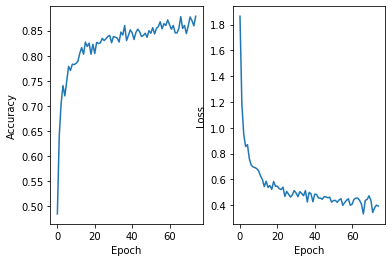

In [11]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
20 dB SNR --
(9320, 34)
	labels:      (0, 33)
	predictions: (0, 33)
9320/9320 - 0s - loss: 0.2943 - sparse_categorical_accuracy: 0.8925
	Test accuracy: 0.89248925


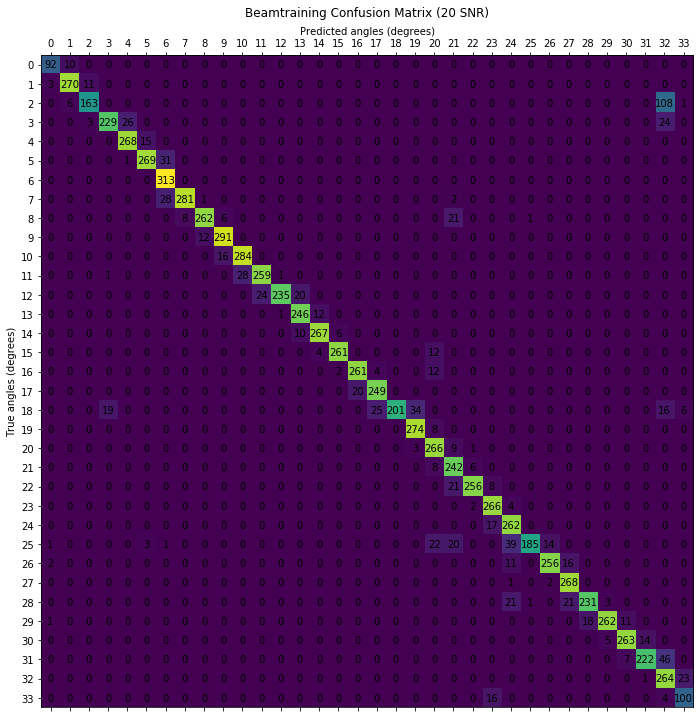

30 dB SNR --
(9320, 34)
	labels:      (0, 33)
	predictions: (0, 33)
9320/9320 - 0s - loss: 0.1906 - sparse_categorical_accuracy: 0.9231
	Test accuracy: 0.92306864


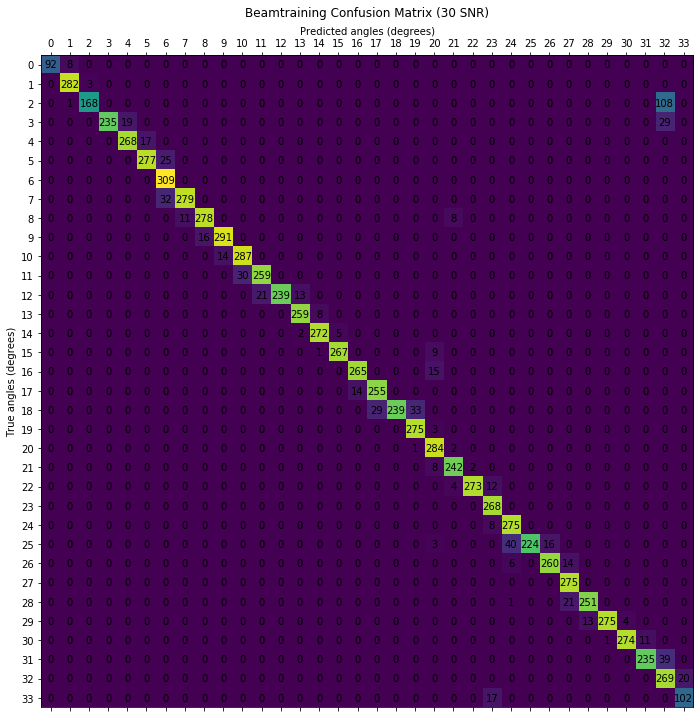

ALL SNR values --
(18640, 34)
	labels:      (0, 33)
	predictions: (0, 33)
18640/18640 - 1s - loss: 0.2424 - sparse_categorical_accuracy: 0.9078
	Test accuracy: 0.907779


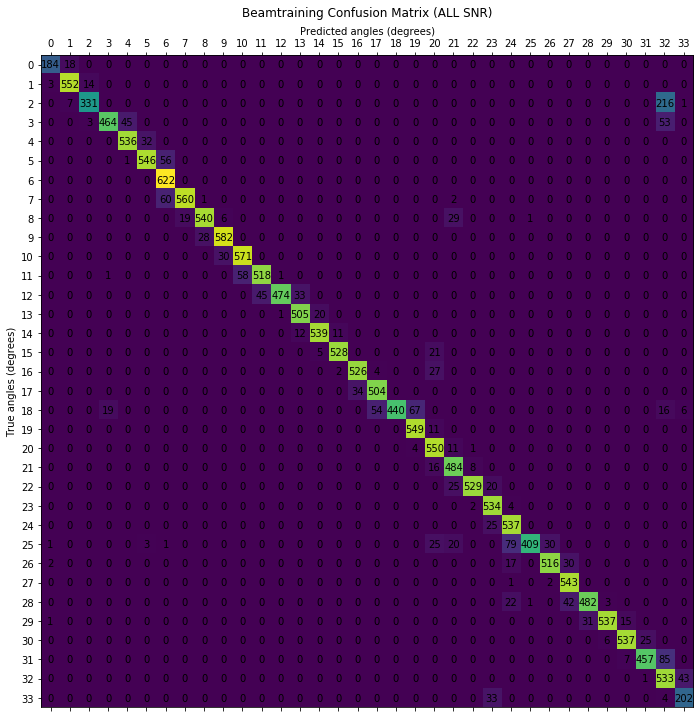


Number of results:            (1, 3)
Confusion matrix tensor size: (1, 3, 34, 34)
20 dB SNR --
30 dB SNR --
20 dB SNR --
Gain Loss Percentiles, SNR 20
[[0.0000e+00 0.0000e+00]
 [1.0000e+01 0.0000e+00]
 [2.0000e+01 0.0000e+00]
 [3.0000e+01 0.0000e+00]
 [4.0000e+01 0.0000e+00]
 [5.0000e+01 0.0000e+00]
 [6.0000e+01 0.0000e+00]
 [7.0000e+01 0.0000e+00]
 [8.0000e+01 0.0000e+00]
 [9.0000e+01 5.8000e-02]
 [1.0000e+02 4.9648e+01]]
30 dB SNR --
Gain Loss Percentiles, SNR 30
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.   ]
 [100.     57.704]]
ALL SNR values --
Gain Loss Percentiles, SNR ALL
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.   ]
 [100.     57.704]]

Average Test Accuracies: 
	SNR: 20; Accuracy: 0.89248925447

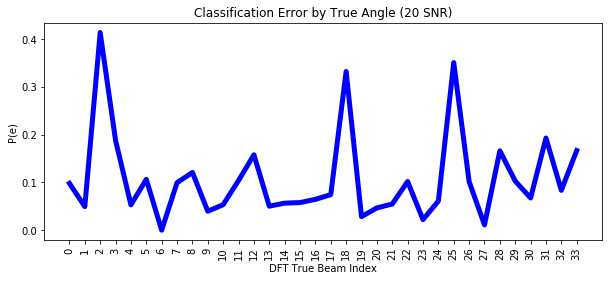

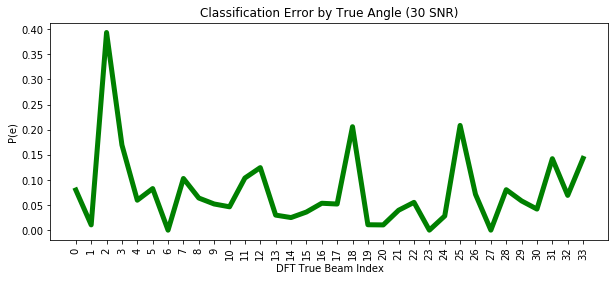

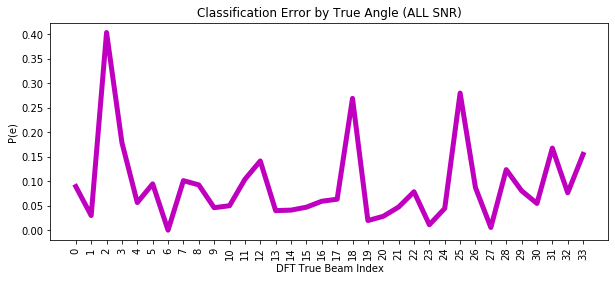

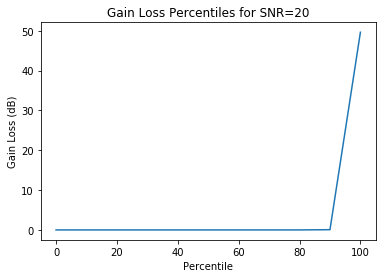

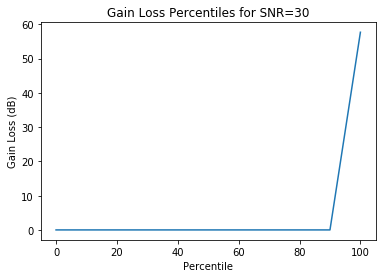

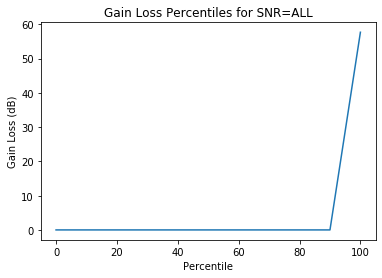

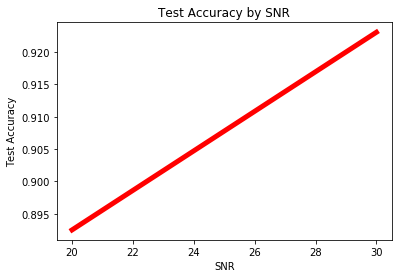

In [12]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim{}_{}meas_{}SNR.png'.format(NN_NUM, NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 5 Measurements


Training model for PN combo 0...
Train on 1360 samples
Epoch 1/75
1360/1360 [==============================] - 1s 1ms/sample - loss: 2.0739 - sparse_categorical_accuracy: 0.4176
Epoch 2/75
1360/1360 [==============================] - 1s 455us/sample - loss: 1.4526 - sparse_categorical_accuracy: 0.5485
Epoch 3/75
1360/1360 [==============================] - 1s 472us/sample - loss: 1.2610 - sparse_categorical_accuracy: 0.6066
Epoch 4/75
1360/1360 [==============================] - 1s 471us/sample - loss: 1.1027 - sparse_categorical_accuracy: 0.6478
Epoch 5/75
1360/1360 [==============================] - 1s 511us/sample - loss: 1.0189 - sparse_categorical_accuracy: 0.6713
Epoch 6/75
1360/1360 [==============================] - 1s 471us/sample - loss: 1.0144 - sparse_categorical_accuracy: 0.6912
Epoch 7/75
1360/1360 [==============================] - 1s 496us/sample - loss: 0.9601 - sparse_categorical_accuracy: 0.7007
Epoch 8/75
1360/1360 [==============================] - 1s 462us/sample

Text(0.5, 0, 'Epoch')

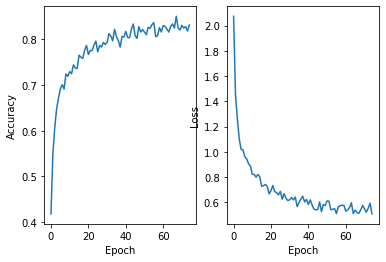

In [15]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
20 dB SNR --
(9320, 34)
	labels:      (0, 33)
	predictions: (0, 33)
9320/9320 - 1s - loss: 0.8981 - sparse_categorical_accuracy: 0.8039
	Test accuracy: 0.80386263


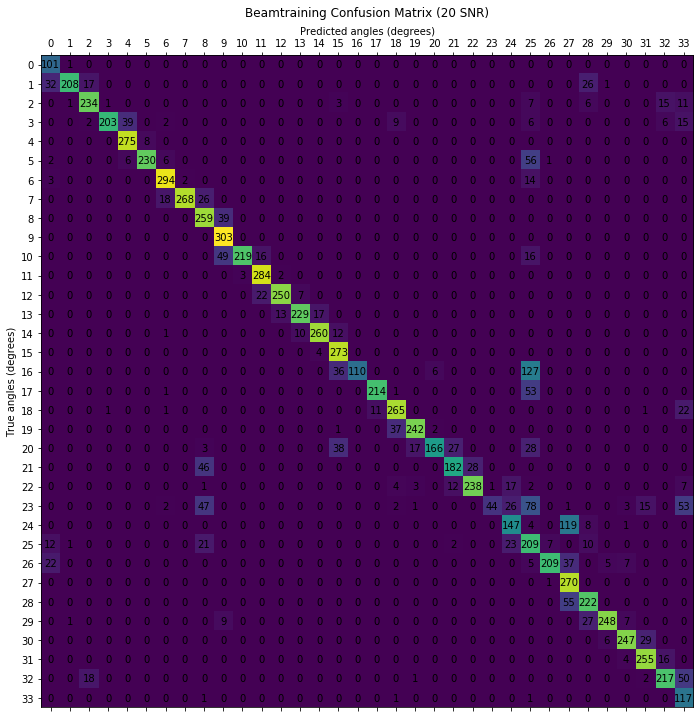

30 dB SNR --
(9320, 34)
	labels:      (0, 33)
	predictions: (0, 33)
9320/9320 - 0s - loss: 0.6700 - sparse_categorical_accuracy: 0.8473
	Test accuracy: 0.8473176


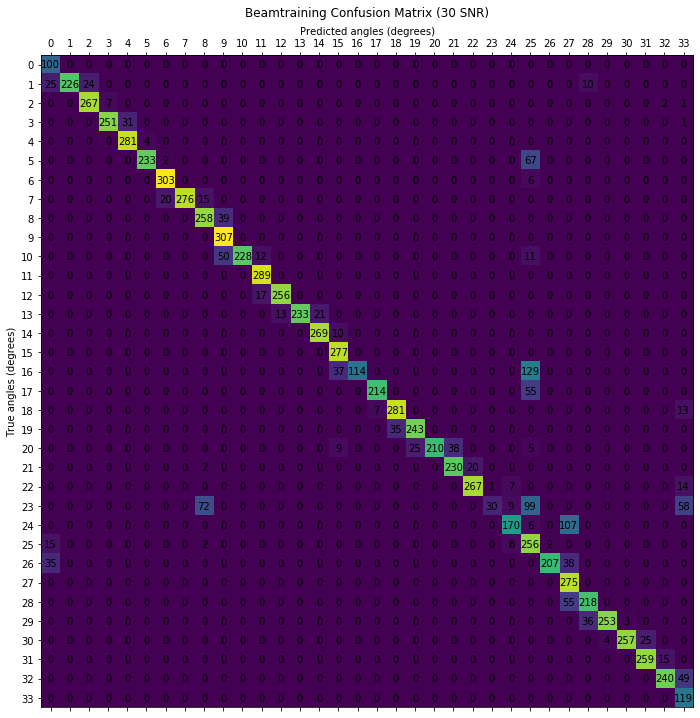

ALL SNR values --
(18640, 34)
	labels:      (0, 33)
	predictions: (0, 33)
18640/18640 - 1s - loss: 0.7841 - sparse_categorical_accuracy: 0.8256
	Test accuracy: 0.82559013


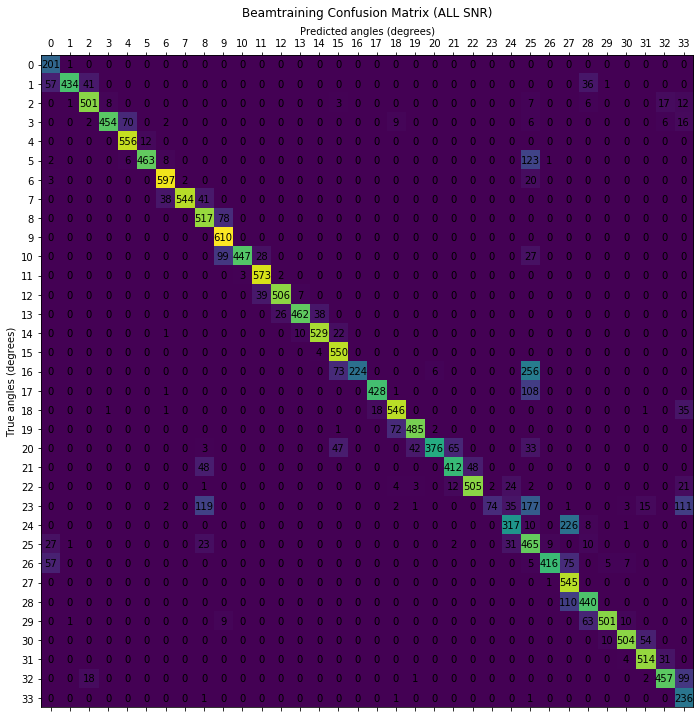


Number of results:            (1, 3)
Confusion matrix tensor size: (1, 3, 34, 34)
20 dB SNR --
30 dB SNR --
20 dB SNR --
Gain Loss Percentiles, SNR 20
[[  0.        0.     ]
 [ 10.        0.     ]
 [ 20.        0.     ]
 [ 30.        0.     ]
 [ 40.        0.     ]
 [ 50.        0.     ]
 [ 60.        0.     ]
 [ 70.        0.     ]
 [ 80.        0.     ]
 [ 90.       12.39991]
 [100.       49.711  ]]
30 dB SNR --
Gain Loss Percentiles, SNR 30
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.507]
 [100.     51.439]]
ALL SNR values --
Gain Loss Percentiles, SNR ALL
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.951]
 [100.     51.439]]

Average Test Accuracies: 
	SNR: 20; Accuracy: 0.8038626313209534
	SNR: 30; Accura

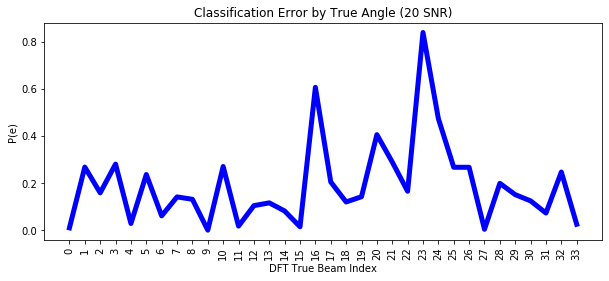

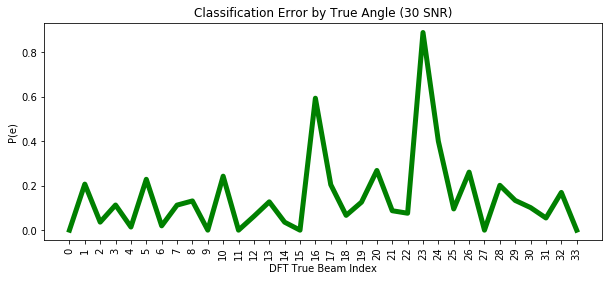

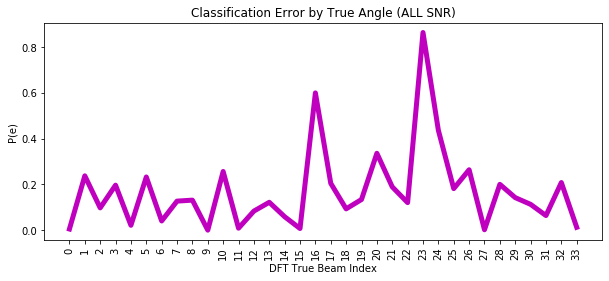

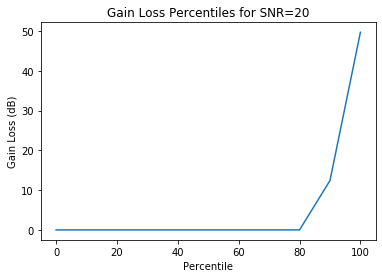

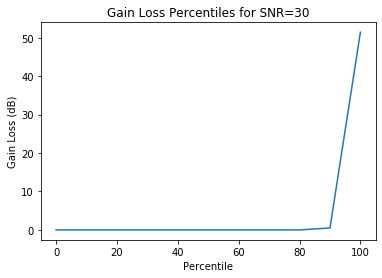

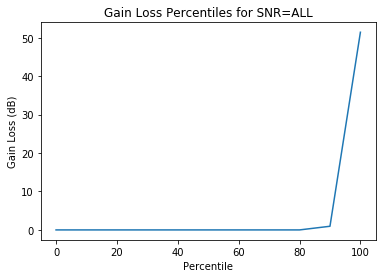

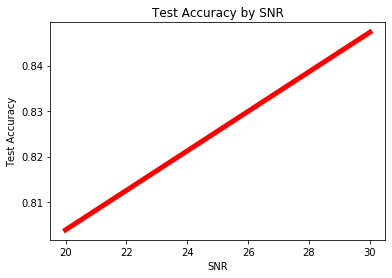

In [16]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim{}_{}meas_{}SNR.png'.format(NN_NUM, NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 4 Measurements


Training model for PN combo 0...
Train on 1360 samples
Epoch 1/75
1360/1360 [==============================] - 2s 1ms/sample - loss: 2.5208 - sparse_categorical_accuracy: 0.2610
Epoch 2/75
1360/1360 [==============================] - 1s 629us/sample - loss: 2.0623 - sparse_categorical_accuracy: 0.3757
Epoch 3/75
1360/1360 [==============================] - 1s 590us/sample - loss: 1.8930 - sparse_categorical_accuracy: 0.4213
Epoch 4/75
1360/1360 [==============================] - 1s 587us/sample - loss: 1.8108 - sparse_categorical_accuracy: 0.4309
Epoch 5/75
1360/1360 [==============================] - 1s 581us/sample - loss: 1.7172 - sparse_categorical_accuracy: 0.4743
Epoch 6/75
1360/1360 [==============================] - 1s 574us/sample - loss: 1.5824 - sparse_categorical_accuracy: 0.5140
Epoch 7/75
1360/1360 [==============================] - 1s 578us/sample - loss: 1.5081 - sparse_categorical_accuracy: 0.5382
Epoch 8/75
1360/1360 [==============================] - 1s 599us/sample

Text(0.5, 0, 'Epoch')

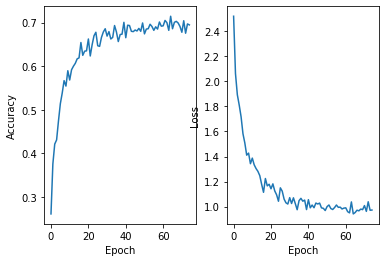

In [19]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
20 dB SNR --
(9320, 34)
	labels:      (0, 33)
	predictions: (0, 33)
9320/9320 - 0s - loss: 1.7957 - sparse_categorical_accuracy: 0.5544
	Test accuracy: 0.55439913


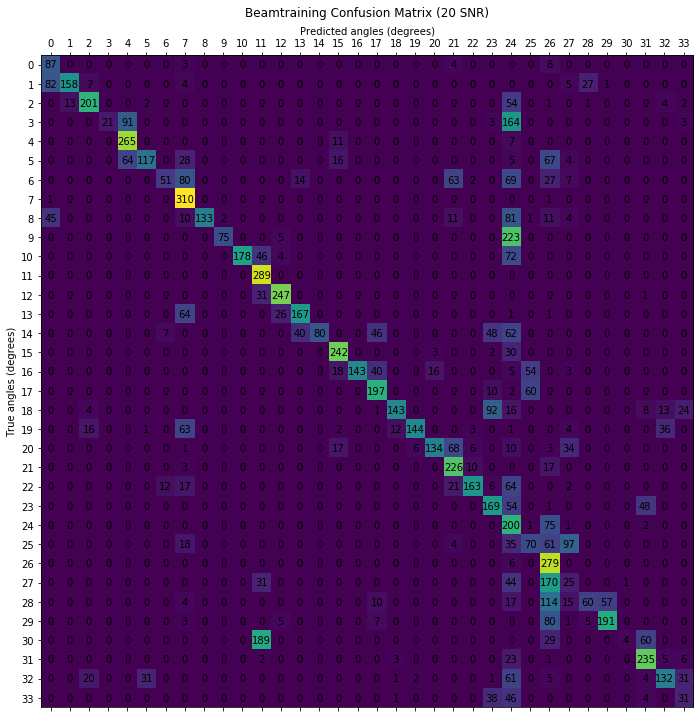

30 dB SNR --
(9320, 34)
	labels:      (0, 33)
	predictions: (0, 33)
9320/9320 - 0s - loss: 1.4501 - sparse_categorical_accuracy: 0.6172
	Test accuracy: 0.61716735


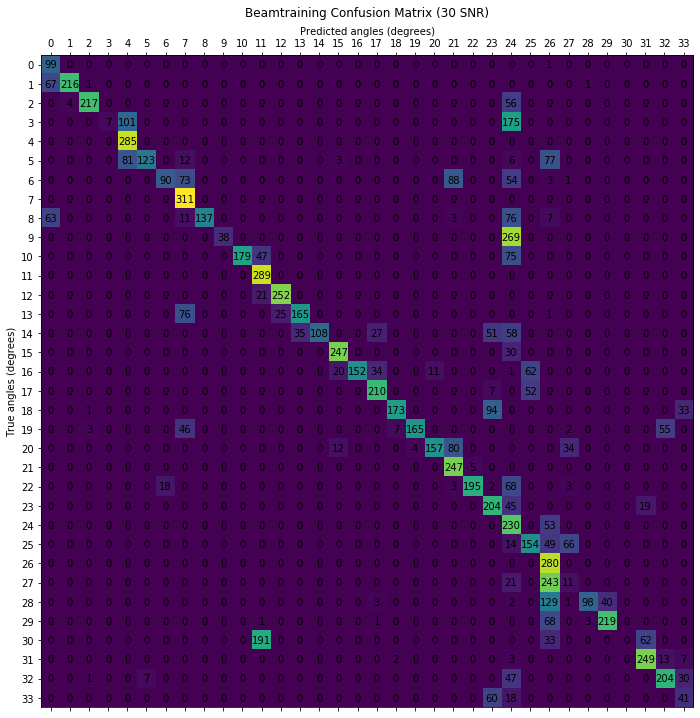

ALL SNR values --
(18640, 34)
	labels:      (0, 33)
	predictions: (0, 33)
18640/18640 - 1s - loss: 1.6229 - sparse_categorical_accuracy: 0.5858
	Test accuracy: 0.58578324


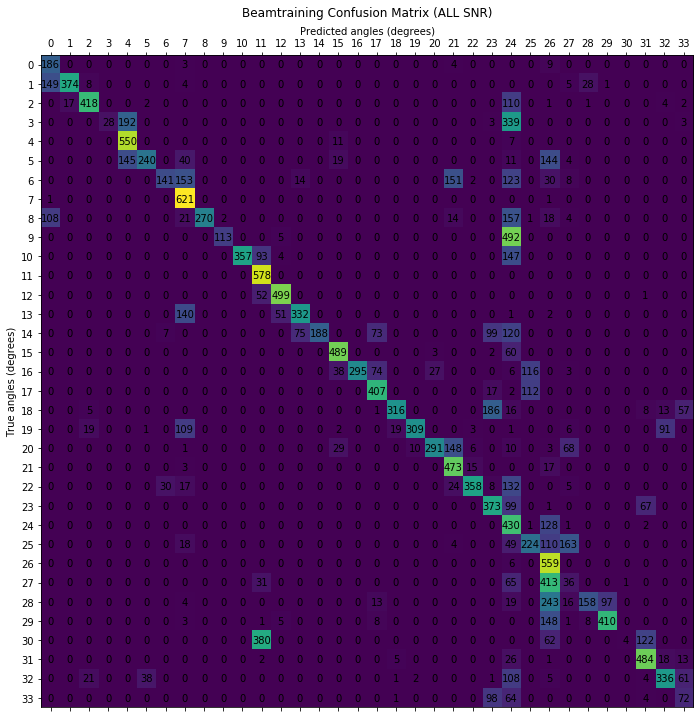


Number of results:            (1, 3)
Confusion matrix tensor size: (1, 3, 34, 34)
20 dB SNR --
30 dB SNR --
20 dB SNR --
Gain Loss Percentiles, SNR 20
[[  0.       0.    ]
 [ 10.       0.    ]
 [ 20.       0.    ]
 [ 30.       0.    ]
 [ 40.       0.    ]
 [ 50.       0.    ]
 [ 60.       0.619 ]
 [ 70.      12.2862]
 [ 80.      23.222 ]
 [ 90.      28.872 ]
 [100.      59.523 ]]
30 dB SNR --
Gain Loss Percentiles, SNR 30
[[  0.       0.    ]
 [ 10.       0.    ]
 [ 20.       0.    ]
 [ 30.       0.    ]
 [ 40.       0.    ]
 [ 50.       0.    ]
 [ 60.       0.    ]
 [ 70.       1.51  ]
 [ 80.      19.9038]
 [ 90.      27.941 ]
 [100.      66.655 ]]
ALL SNR values --
Gain Loss Percentiles, SNR ALL
[[  0.       0.    ]
 [ 10.       0.    ]
 [ 20.       0.    ]
 [ 30.       0.    ]
 [ 40.       0.    ]
 [ 50.       0.    ]
 [ 60.       0.155 ]
 [ 70.       4.2987]
 [ 80.      21.862 ]
 [ 90.      28.382 ]
 [100.      66.655 ]]

Average Test Accuracies: 
	SNR: 20; Accuracy: 0.55439913272

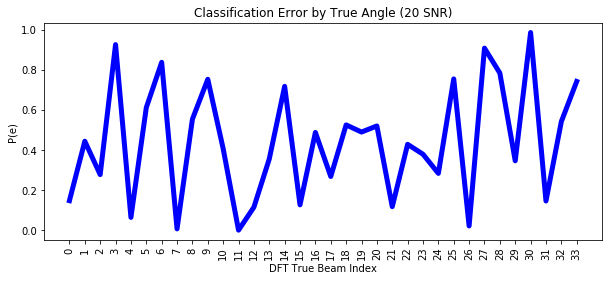

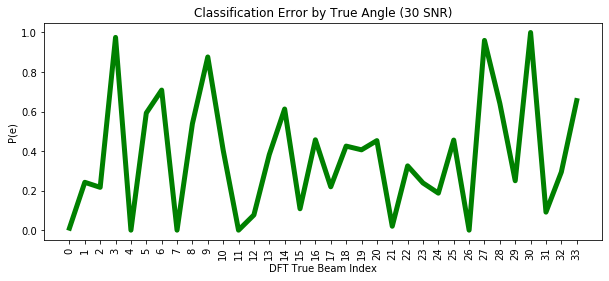

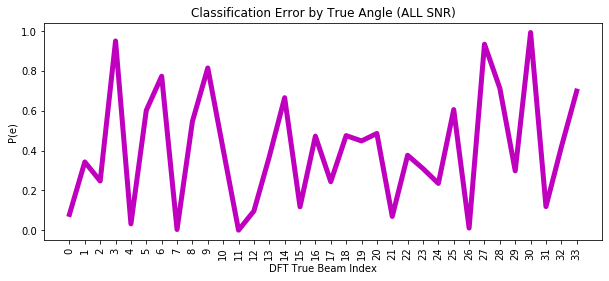

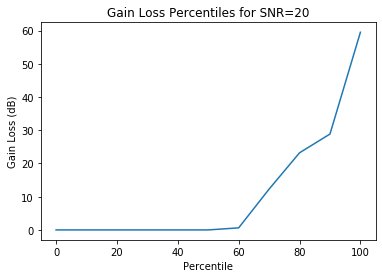

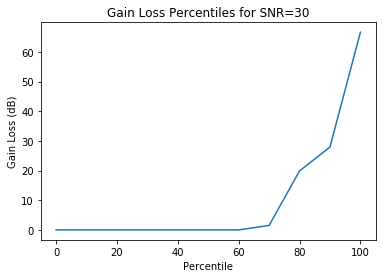

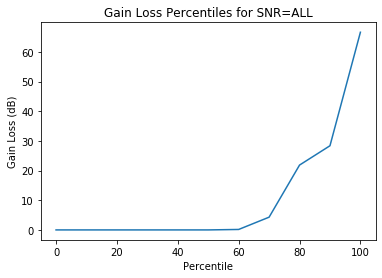

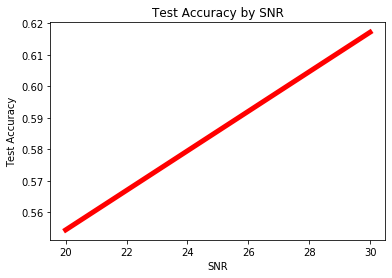

In [20]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim{}_{}meas_{}SNR.png'.format(NN_NUM, NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

# Overall Results Plots

In [56]:
# Check that all M values were tested
print(len(all_gainLoss))
print(all_gainLoss.keys())
#print(all_gainLoss[2][2,0,:])
#print(len(GAIN_LOSS_PERCENTILES))

13
dict_keys([36, 20, 15, 12, 10, 9, 8, 7, 6, 5, 4, 3, 2])


In [57]:
## Save total results to a pickle file
import pickle

## See how many results are available
print(len(all_test_acc))
print(len(all_confusionMat))
print(len(all_pe_byLabel))
print(len(all_gainLoss))

print(all_test_acc.keys())
print(all_test_acc[2])

## Save to a pickle file
return # ONLY RUN IF YOU WANT TO OVERWRITE THE RESULTS SAVED
#TODO: SAVE ALL GAIN LOSS PERCENTILES AND MODELS TO AN OVERALL DICTIONARY
with open('all_NN_sim2_results.pkl', 'wb') as f:
    pickle.dump([all_test_acc, all_confusionMat, all_pe_byLabel, all_gainLoss], f)
    #TODO: ADD MORE VARS

13
13
13
13
dict_keys([36, 20, 15, 12, 10, 9, 8, 7, 6, 5, 4, 3, 2])
[[0.06870824 0.07416481 0.07143652]]


In [ ]:
## Load the pickle file
return # ONLY RUN IF YOU WANT TO OVERWRITE THE RESULTS CAPTURED
with open('all_NN_sim2_results.pkl', 'rb') as f:
    all_test_acc, all_confusionMat, all_pe_byLabel, all_gainLoss = pickle.load(f)

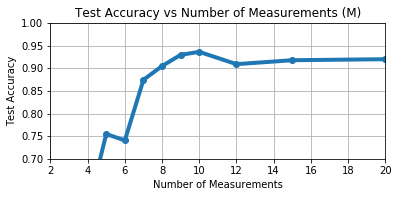

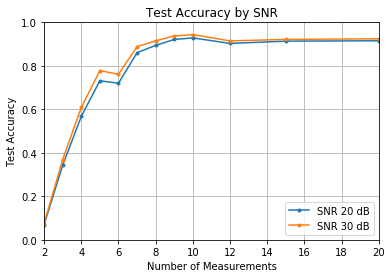

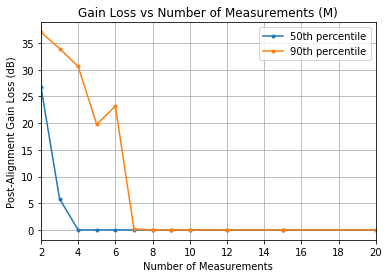

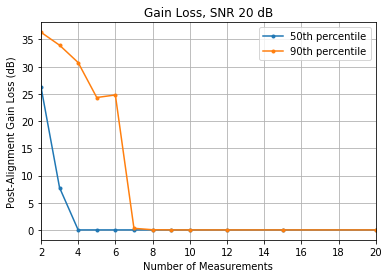

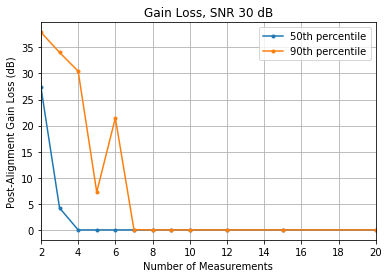

In [58]:
### Plot the overall results for the testing with all SNRs
included_num_meas = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20])
plot_test_acc_allsnr = np.zeros((len(DATA_SNR)+1, len(included_num_meas)))

# Averaged over all PN beam combos
for m_i in np.arange(len(included_num_meas)):
    for snr_ind in np.arange(len(DATA_SNR)+1):
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
        else:
            SNR_i = 'ALL'
        temp_test_acc = all_test_acc[included_num_meas[m_i]]
        plot_test_acc_allsnr[snr_ind, m_i] = np.mean(temp_test_acc[:, snr_ind])

# Plot the result
# Plot of accuracy testing all SNRs together
fig = plt.figure()
plt.plot(included_num_meas, plot_test_acc_allsnr[len(DATA_SNR), :], marker="o", lw=4)
plt.title("Test Accuracy vs Number of Measurements (M)")
plt.xlabel("Number of Measurements")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.ylim(0.7, 1)
plt.yticks(np.arange(70, 105, 5)/100)
plt.xlim(np.min(included_num_meas),np.max(included_num_meas))
fig.set_size_inches(6, 2.5)
plt.savefig("../figures/nn_acc_allSNR_sim2.png")

# Plot of accuracy vs each SNR
plt.figure()
plt.plot(included_num_meas, plot_test_acc_allsnr[np.arange(len(DATA_SNR)), :].T, marker=".")
plt.title("Test Accuracy by SNR")
plt.xlabel("Number of Measurements")
plt.ylabel("Test Accuracy")
plt.legend(("SNR {} dB".format(DATA_SNR[0]), "SNR {} dB".format(DATA_SNR[1])))
plt.grid(True)
plt.ylim(0, 1)
plt.xlim(np.min(included_num_meas),np.max(included_num_meas))

# Extract all the gain loss statistics
percentile_indices = np.array([5, 9]) # indices correspond to 0:10:100 (i.e. 5 -> 50%)
plot_all_gainLoss = np.zeros((len(included_num_meas), len(DATA_SNR)+1, len(GAIN_LOSS_PERCENTILES)))
for snr_ind in np.arange(len(DATA_SNR)+1):
    for m_i in np.arange(len(included_num_meas)):
        plot_all_gainLoss[m_i, snr_ind, :] = all_gainLoss[included_num_meas[m_i]][snr_ind, 0, :]

# Plot of 50th and 90th percentile gain loss testing all SNRs together
plt.figure()
plt.plot(included_num_meas, plot_all_gainLoss[:, len(DATA_SNR), percentile_indices], marker=".")
plt.title("Gain Loss vs Number of Measurements (M)")
plt.xlabel("Number of Measurements")
plt.ylabel("Post-Alignment Gain Loss (dB)")
plt.grid(True)
plt.xlim(np.min(included_num_meas),np.max(included_num_meas))
#fig.set_size_inches(6, 2.5)
plt.legend(("{}th percentile".format(GAIN_LOSS_PERCENTILES[percentile_indices[0]]), "{}th percentile".format(GAIN_LOSS_PERCENTILES[percentile_indices[1]])))
plt.savefig("../figures/nn_gainLoss_allSNR_sim2.png")

# Plot of gain loss vs each SNR
for plot_snr_ind in np.arange(len(DATA_SNR)):
    plt.figure()
    plt.plot(included_num_meas, plot_all_gainLoss[:, plot_snr_ind, percentile_indices], marker=".")
    plt.title("Gain Loss, SNR {} dB".format(DATA_SNR[plot_snr_ind]))
    plt.xlabel("Number of Measurements")
    plt.ylabel("Post-Alignment Gain Loss (dB)")
    plt.legend(("{}th percentile".format(GAIN_LOSS_PERCENTILES[percentile_indices[0]]), "{}th percentile".format(GAIN_LOSS_PERCENTILES[percentile_indices[1]])))
    plt.grid(True)
    plt.xlim(np.min(included_num_meas),np.max(included_num_meas))


# Regression Method - Continuous Angle Prediction
For data communication, a true angle prediction might be better than a discrete classification.  Classification heavily penalizes wrongly classifying to neighboring beams, even if the angle is almost exactly in between the two beam angles.  This may not be realistic for real-world implementations, as the actual beam may have significantly more angular control and thus could steer to the exact direction between the training beams.  Even without the ability to steer in any direction, classifying to neighboring beams should intuitively be better than classifying to further beams.

In [41]:
### Variable reorganization for regression (add another dimension) ###

# ALL DATA/LABEL/ANGLE VARIABLES FOR REGRESSION ARE LABELED AS "*_r" (where * is the original name used for classification)
USING_CNN_ARG = False

## Storage dictionaries/running variables for regression
train_data_dict_r = {}
test_data_dict_r = {}
val_data_dict_r = {}
train_angles_dict_r = {}
test_angles_dict_r = {}
val_angles_dict_r = {}
train_labels_dict_r = {}
test_labels_dict_r = {}
val_labels_dict_r = {}

# For the regression method with CNNs, need dimensions to be N x D x 1 (instead of N x D or D x N)
print("Modifying training/validation/testing datasets:")
for snr_i in np.arange(len(train_data_dict)):
    if USING_CNN_ARG:
        train_data_dict_r[SNR[snr_i]] = np.array([train_data_dict[SNR[snr_i]].T]).T
        train_labels_dict_r[SNR[snr_i]] = np.array([train_labels_dict[SNR[snr_i]].T]).T
        train_angles_dict_r[SNR[snr_i]] = np.array([train_angles_dict[SNR[snr_i]].T]).T

        val_data_dict_r[SNR[snr_i]] = np.array([val_data_dict[SNR[snr_i]].T]).T
        val_labels_dict_r[SNR[snr_i]] = np.array([val_labels_dict[SNR[snr_i]].T]).T
        val_angles_dict_r[SNR[snr_i]] = np.array([val_angles_dict[SNR[snr_i]].T]).T

        test_data_dict_r[SNR[snr_i]] = np.array([test_data_dict[SNR[snr_i]].T]).T
        test_labels_dict_r[SNR[snr_i]] = np.array([test_labels_dict[SNR[snr_i]].T]).T
        test_angles_dict_r[SNR[snr_i]] = np.array([test_angles_dict[SNR[snr_i]].T]).T
    
    else:
        train_data_dict_r[SNR[snr_i]] = train_data_dict[SNR[snr_i]]
        train_labels_dict_r[SNR[snr_i]] = train_labels_dict[SNR[snr_i]]
        train_angles_dict_r[SNR[snr_i]] = train_angles_dict[SNR[snr_i]]

        val_data_dict_r[SNR[snr_i]] = val_data_dict[SNR[snr_i]]
        val_labels_dict_r[SNR[snr_i]] = val_labels_dict[SNR[snr_i]]
        val_angles_dict_r[SNR[snr_i]] = val_angles_dict[SNR[snr_i]]

        test_data_dict_r[SNR[snr_i]] = test_data_dict[SNR[snr_i]]
        test_labels_dict_r[SNR[snr_i]] = test_labels_dict[SNR[snr_i]]
        test_angles_dict_r[SNR[snr_i]] = test_angles_dict[SNR[snr_i]]

    print("\ttrain: {}, val: {}, test: {}".format(train_data_dict_r[SNR[snr_i]].shape, 
                                                  val_data_dict_r[SNR[snr_i]].shape,
                                                  test_data_dict_r[SNR[snr_i]].shape))

# Need to reshape the overall training and validation sets too
if USING_CNN_ARG:
    train_data_all_r = np.array([train_data_all.T]).T
    val_data_all_r = np.array([val_data_all.T]).T
    train_angles_all_r = np.array([train_angles_all.T]).T
    val_angles_all_r = np.array([val_angles_all.T]).T
else:
    train_data_all_r = train_data_all
    val_data_all_r = val_data_all
    train_angles_all_r = train_angles_all
    val_angles_all_r = val_angles_all

print("Total training dataset size:   {}".format(train_data_all_r.shape))
print("Total validation dataset size: {}".format(val_data_all_r.shape))

Modifying training/validation/testing datasets:
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
Total training dataset size:   (70000, 15)
Total validation dataset size: (20000, 15)


In [28]:
### Dictionaries to hold metrics for different number of measurements ###
# RUN ONLY WHEN STARTING A NEW SET OF PLOTS
return # to prevent rerunning between different numbers of measurements
# Keys: Number of measurements used (i.e. 5, 10, or 15)
all_RMSE_reg = {}
all_acc_reg = {} # TODO


In [42]:
### Dictionaries to hold metrics for different runs ###
# Keys: SNR value
RMSE_reg = {}
acc_reg = {} # TODO


In [43]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Produces the best results - MAE = 17.6 (@10 measurements, 5dB SNR - still really high)

inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
x = layers.Dense(64, activation='relu', name='dense_2')(x)
#x = layers.Dense(64, activation='relu', name='dense_3')(x)
outputs = layers.Dense(1, name='predictions')(x)
model = keras.Model(inputs=inputs, outputs=outputs)


## CNN architecture
# 1D convolutions with maxpooling
# batch norm to reduce initialization dependence

# model = keras.Sequential()

# model.add(layers.Conv1D(32, 3, activation='relu', padding='same', input_shape=(NUM_MEAS, 1)))
# model.add(layers.MaxPooling1D(2, padding='same'))
# model.add(layers.Conv1D(64, 3, activation='relu', padding='same'))
# model.add(layers.MaxPooling1D(2, padding='same'))
# model.add(layers.Conv1D(64, 3, activation='relu', padding='same'))
# model.add(layers.Flatten())

# # model.add(layers.Dense(64, input_dim=NUM_MEAS))
# # model.add(layers.BatchNormalization())
# # model.add(layers.Activation('relu'))

# model.add(layers.Dense(64))
# model.add(layers.BatchNormalization())
# model.add(layers.Activation('relu'))
# # #model.add(Dropout(0.5))

# model.add(layers.Dense(64))
# model.add(layers.BatchNormalization())
# model.add(layers.Activation('relu'))
# #model.add(Dropout(0.5))

# model.add(layers.Dense(1))
# model.add(layers.BatchNormalization())
# model.add(layers.Activation('relu'))
# #model.add(Dropout(0.5))


model.compile(optimizer=tf.keras.optimizers.Adam(0.001), #RMSprop(0.01), # # Optimizer
              # Loss function to minimize
              loss='mse',       # mean squared error
              # List of metrics to monitor
              metrics=['mae', 'mse'])  # mean absolute error

model.summary()

model.fit(train_data_all_r, train_angles_all_r, epochs=3, batch_size=NUM_MEAS,
          validation_data=(val_data_all_r, val_angles_all_r))

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SparseRSSI (InputLayer)      [(None, 15)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1024      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
predictions (Dense)          (None, 1)                 65        
Total params: 5,249
Trainable params: 5,249
Non-trainable params: 0
_________________________________________________________________
Train on 70000 samples, validate on 20000 samples
Epoch 1/3
70000/70000 [==============================] - 9s 134us/sample - loss: 667.1582 - mae: 19.6238 - mse: 667.1575 - val_loss: 601.4920 - val_mae: 17.7873 - val_mse: 601.4926
Epoch 2/3
70000/70000 [=


-15 dB SNR --
(1000, 1)
1000/1 - 0s - loss: 147.5195 - mae: 9.2804 - mse: 117.7993
	Test MSE: 117.79928
	Keras RMSE:  33.889206

-10 dB SNR --
(1000, 1)
1000/1 - 0s - loss: 130.0401 - mae: 9.6180 - mse: 132.8101
	Test MSE: 132.81007
	Keras RMSE:  35.85139

-5 dB SNR --
(1000, 1)
1000/1 - 0s - loss: 135.0462 - mae: 10.6879 - mse: 175.1465
	Test MSE: 175.14647
	Keras RMSE:  35.018875

0 dB SNR --
(1000, 1)
1000/1 - 0s - loss: 225.8660 - mae: 13.5185 - mse: 286.8965
	Test MSE: 286.89655
	Keras RMSE:  32.322292

5 dB SNR --
(1000, 1)
1000/1 - 0s - loss: 268.4444 - mae: 16.6299 - mse: 445.8639
	Test MSE: 445.86386
	Keras RMSE:  23.98994

10 dB SNR --
(1000, 1)
1000/1 - 0s - loss: 846.7432 - mae: 21.8476 - mse: 725.3643
	Test MSE: 725.36426
	Keras RMSE:  13.325187

15 dB SNR --
(1000, 1)
1000/1 - 0s - loss: 1321.6547 - mae: 24.2567 - mse: 841.4233
	Test MSE: 841.42334
	Keras RMSE:  7.92558

20 dB SNR --
(1000, 1)
1000/1 - 0s - loss: 1008.9638 - mae: 25.7860 - mse: 919.3963
	Test MSE: 919.39

(-15, 30)

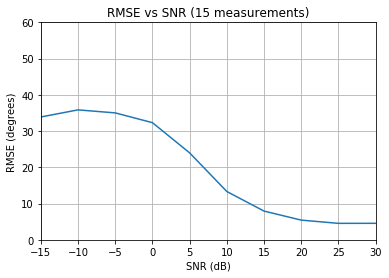

In [44]:
### Test the NN Model ###

for SNR_i in SNR:
    print("\n{} dB SNR --".format(SNR_i))
    test_pred_angles = model.predict(test_data_dict_r[SNR_i])
    print(test_pred_angles.shape)

    test_loss, test_mae, test_mse = model.evaluate(test_data_dict_r[SNR_i],  test_labels_dict_r[SNR_i], verbose=2)
    print('\tTest MSE:', test_mse)
    
    ## Compute the RMSE of the angles
    m = tf.keras.metrics.RootMeanSquaredError()
    m.update_state(test_angles_dict_r[SNR_i], test_pred_angles)
    rmse_keras = m.result().numpy()
    print('\tKeras RMSE: ', rmse_keras)
    
    RMSE_reg[SNR_i] = rmse_keras

    # Compute the predicted labels and the confusion matrix
#     test_pred_labels = np.argmax(test_predictions, 1)
#     test_confusion = tf.math.confusion_matrix(test_labels_dict[SNR_i],
#                                               test_pred_labels)
#     print(test_confusion)
#     class_confusionMat[SNR_i] = test_confusion

    ## Plot the confusion matrix (see which beams get associated with each other)
#     fig, ax = plt.subplots()
#     ax.matshow(test_confusion)
#     for (i, j), z in np.ndenumerate(test_confusion):
#         ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

#     ax.set_xticklabels(CLASSES)
#     ax.set_yticklabels(CLASSES)
#     ax.xaxis.set_label_position("top")
#     fig.set_size_inches(12, 12)
#     plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
#     plt.xlabel("Predicted angles (degrees)")
#     plt.ylabel("True angles (degrees)")
#     plt.xticks(np.arange(NUM_CLASSES))
#     plt.yticks(np.arange(NUM_CLASSES))
#     plt.savefig('../figures/confusionMatrix_reg_{}meas_{}SNR.png'.format(NUM_MEAS, SNR_i))
#     plt.show()

print("Number of results: {}".format(len(RMSE_reg)))

# Store the results
#all_test_acc[NUM_MEAS] = class_test_acc
all_RMSE_reg[NUM_MEAS] = RMSE_reg

# Plot of accuracy vs. SNR
# plt.figure()
# plt.plot(SNR, list(class_test_acc.values()))
# plt.title("Test Accuracy vs SNR ({} measurements)".format(NUM_MEAS))
# plt.xlabel("SNR (dB)")
# plt.ylabel("Test Accuracy")
# plt.grid(True)
# plt.ylim(0, 1)
# plt.xlim(-15,30)

# Plot of RMSE vs. SNR
plt.figure()
plt.plot(SNR, list(RMSE_reg.values()))
plt.title("RMSE vs SNR ({} measurements)".format(NUM_MEAS))
plt.xlabel("SNR (dB)")
plt.ylabel("RMSE (degrees)")
plt.grid(True)
plt.ylim(0, 60)
plt.xlim(-15,30)

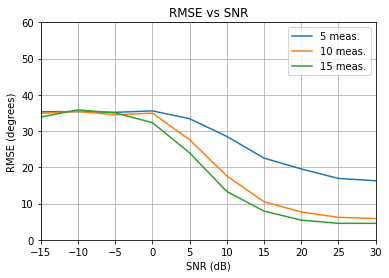

In [45]:
### Plot of the overall metric results for all measurement numbers ###
# Metrics stored in a dictionary of dictionaries
#     Top dictionary (all_*) uses the number of measurements as a key
#     Secondary dictionary (class_*) uses the SNR as a key
# Plots should overlay metric vs. SNR for each number of measurements

meas_plots = list(all_RMSE_reg.keys())
NUM_PLOTS = len(meas_plots)
label_plots = []
for i in np.arange(NUM_PLOTS):
    label_plots.append("{} meas.".format(meas_plots[i]))

# Plot of accuracy vs. SNR
# plt.figure()
# for i in np.arange(NUM_PLOTS):
#     plt.plot(SNR, list(all_test_acc[meas_plots[i]].values()))
# plt.title("Test Accuracy vs SNR")
# plt.xlabel("SNR (dB)")
# plt.ylabel("Test Accuracy")
# plt.grid(True)
# plt.ylim(0, 1)
# plt.xlim(-15,30)
# plt.legend(label_plots)
# plt.savefig('../figures/nn_accuracy.png')

# Plot of RMSE vs. SNR
plt.figure()
for i in np.arange(NUM_PLOTS):
    plt.plot(SNR, list(all_RMSE_reg[meas_plots[i]].values()))
plt.title("RMSE vs SNR")
plt.xlabel("SNR (dB)")
plt.ylabel("RMSE (degrees)")
plt.grid(True)
plt.ylim(0, 60)
plt.xlim(-15,30)
plt.legend(label_plots)
plt.savefig('../figures/nn_reg_rmse.png')


In [46]:
### Save the results to a CSV for later/combined plotting ###
all_test_res = pd.DataFrame(index=SNR.astype(int))
print(all_test_res.shape)
print(SNR)
for i in np.arange(NUM_PLOTS):
#     all_test_acc_np = np.array(list(all_test_acc[meas_plots[i]].values()))
#     all_test_res.insert(loc=int(i), 
#                         column="Accuracy_{}".format(label_plots[i]),
#                         value=all_test_acc_np)
    all_rmse_reg_np = np.array(list(all_RMSE_reg[meas_plots[i]].values()))
    all_test_res.insert(loc=int(i), 
                        column="RMSE_{}".format(label_plots[i]),
                        value=all_rmse_reg_np)

print(all_test_res)
all_test_res.to_csv("../data/regression_NN_results.csv", index=True)

(10, 0)
[-15 -10  -5   0   5  10  15  20  25  30]
     RMSE_5 meas.  RMSE_10 meas.  RMSE_15 meas.
-15     35.328289      34.888290      33.889206
-10     35.379852      35.416080      35.851391
-5      35.181820      34.488541      35.018875
 0      35.573147      34.953278      32.322292
 5      33.409790      27.597979      23.989941
 10     28.529898      17.621866      13.325187
 15     22.547327      10.511057       7.925580
 20     19.561069       7.668045       5.431944
 25     16.929165       6.201704       4.540309
 30     16.294001       5.887393       4.549653
